# Generación de datos sintéticos a partir de modelos probabilísticos

El objetivo es crear nuestro propio conjunto de datos a partir de modelos probabilísticos estudiados:

In [1]:
# To see the plots inline, even if you have not started the notebook via "ipython notebook --pylab=inline"
%pylab inline 
%config InlineBackend.figure_format = 'retina'  # [Truco] Resolución para pantallas HDPI
pylab.rcParams['figure.figsize'] = (10, 6)
plt.style.use('ggplot')

import numpy as np
import scipy.stats as st
import pandas as pd

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
X1 = st.bernoulli(0.2)  # Genero una variable con 0 y 1
X2 = st.norm(loc=176., scale=10.)  # Altura de los individuos
X3 = st.norm(loc=70., scale=5.)  # Peso de los individuos

datos = pd.DataFrame({'sexo':X1.rvs(100), 'altura':X2.rvs(100), 'peso':X3.rvs(100)})

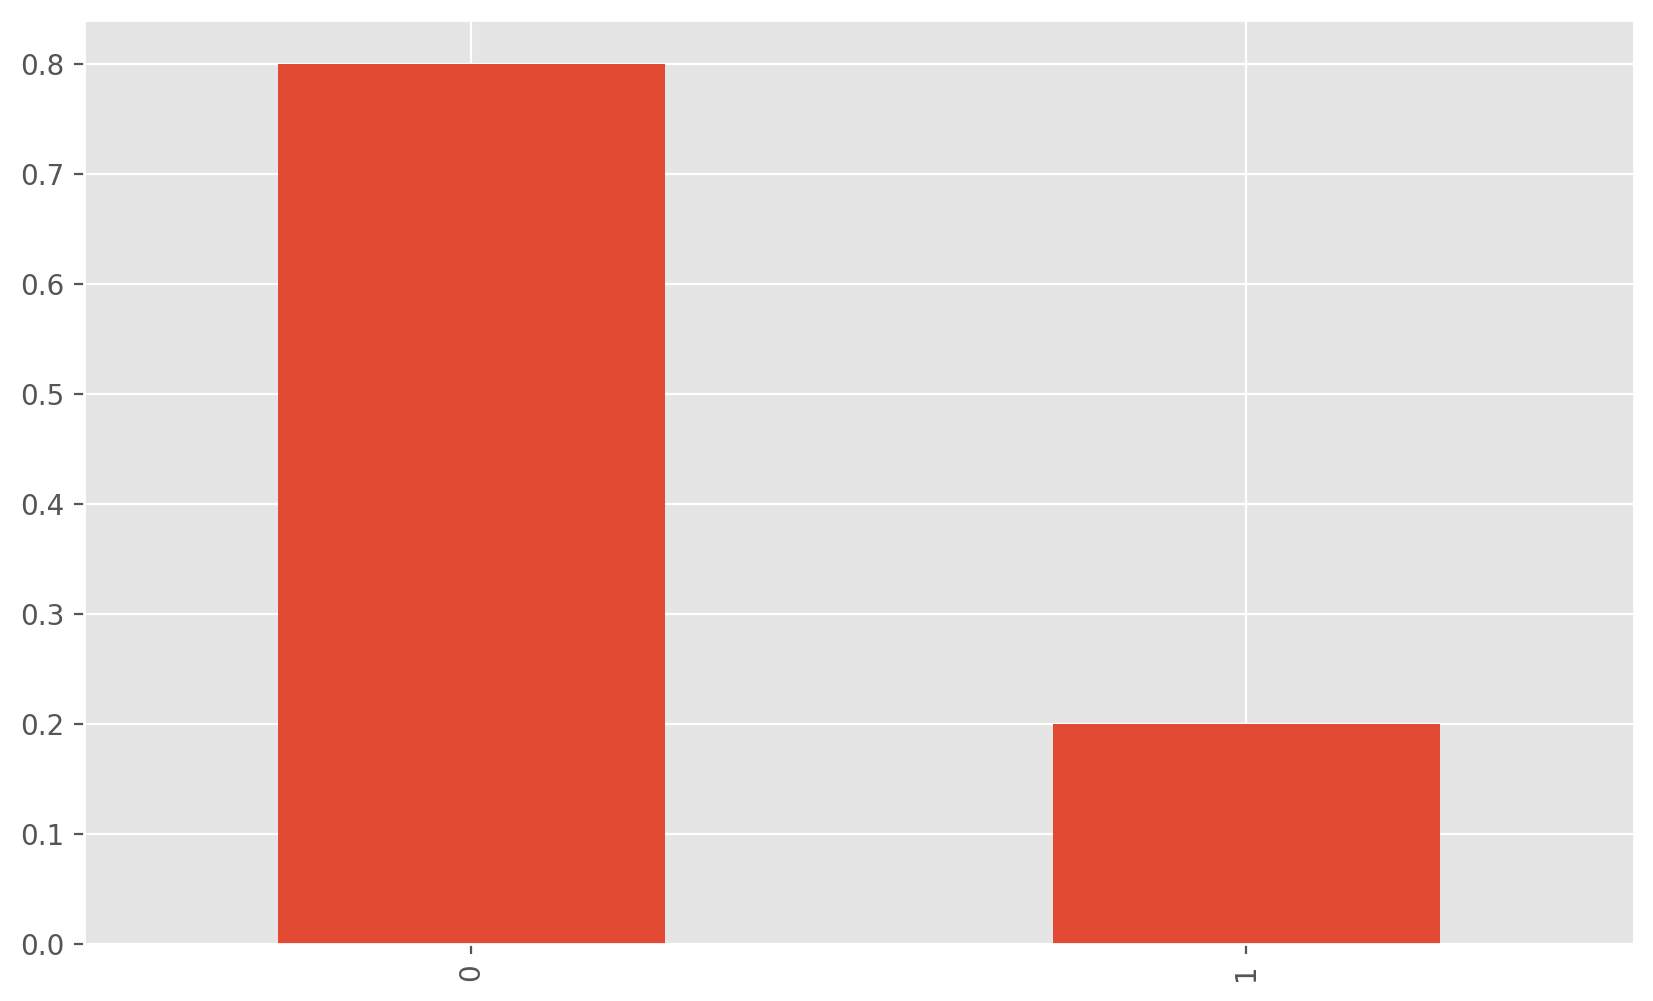

In [3]:
#datos.altura.plot(kind='hist');
#datos.peso.plot(kind='hist');
datos.sexo.value_counts(normalize=True).plot(kind='bar');

Algo más elaborado

In [4]:
altura_hombres = st.norm(loc=174., scale=10.)  # Altura de los individuos
peso_hombres = st.norm(loc=75., scale=5.)  # Peso de los individuos
datos_hombres = pd.DataFrame({'altura':altura_hombres.rvs(100), 'peso':peso_hombres.rvs(100)})

altura_mujeres = st.norm(loc=176., scale=5.)  # Altura de los individuos
peso_mujeres = st.norm(loc=55., scale=5.)  # Peso de los individuos
datos_mujeres = pd.DataFrame({'altura':altura_mujeres.rvs(50), 'peso':peso_mujeres.rvs(50)})

datos = pd.concat([datos_hombres, datos_mujeres])

datos['sexo'] = np.repeat(["hombre","mujer"], [100,50])

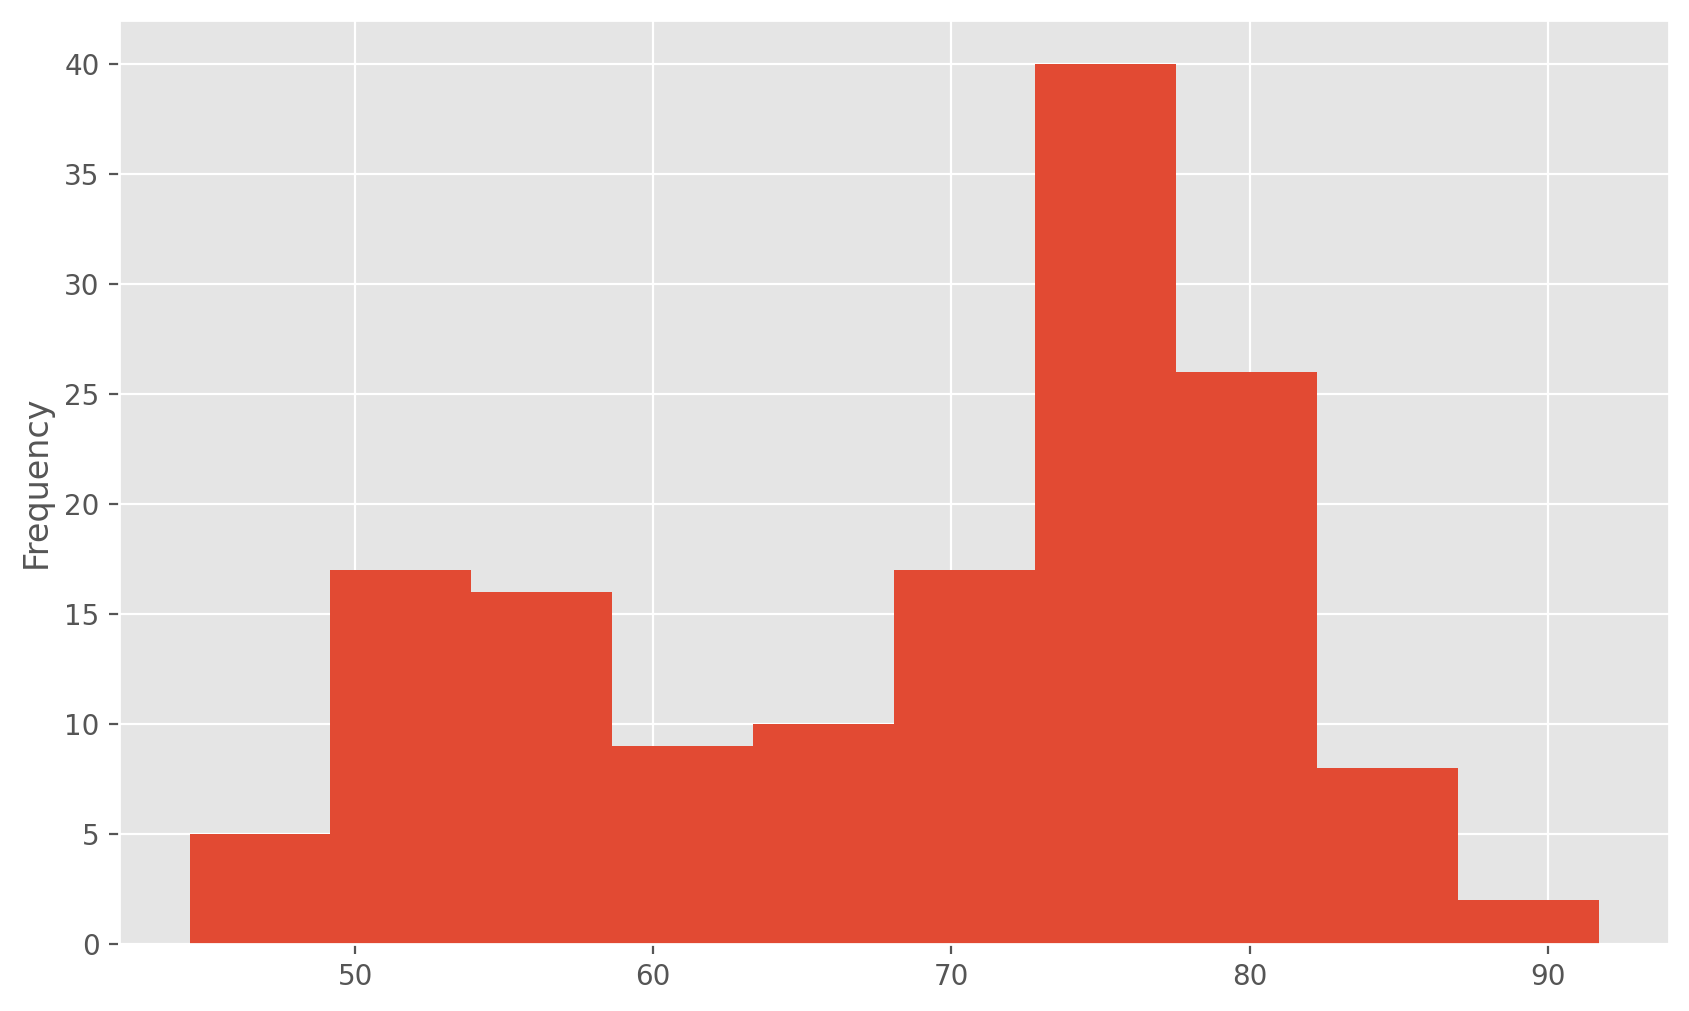

In [5]:
# datos.sexo.value_counts(normalize = True).plot(kind='bar')
datos.peso.plot(kind='hist');

In [6]:
 datos.to_csv('muestras_sinteticas.csv') # Guardamos los datos
# despues los recuperamos
# datos = pd.read_csv('muestras_sinteticas.csv') # Recordemos cargar primero import pandas as pd

# Estudios descriptivos 

Vamos a aclarar los pasos para describir un parámetro de la población (por ejemplo porcentaje de población que escribe una reclamación perjudicial para la empresa, o la estimación del salario medio de los trabajadores de una empresa). Este tipo de estudios no trata de buscar una relación causa-efecto entre las variables medidas. Busca una descripción pormenorizada del tipo de variables dentro de nuestro estudio. En general, en este tipo de estudios se busca __estimar medidas de la población a partir de la muestra dada__.

Podríamos distinguir varios pasos hasta llegar a la estimación de las medidas en nuestro estudio:

1. Realizar las transformaciones necesarias.
2. Describir a los sujetos estudiados. Sintetizar las principales características de la muestra:
    1. ¿Se adecua la muestra al problema planteado?
	2. ¿Para qué tipo de sujetos se van a obtener los resultados?
	3. ¿Puede extrapolarse los resultados del estudio a otras poblaciones?
	4. ¿Podrá replicarse el estudio por otros investigadores?
3. Evaluar la representatividad de la muestra.
4. Estimar los valores de los parámetros de interés y si es posible calcular el intervalo de confianza de dicha estimación.
5. ¿Es necesario realizar un análisis de subgrupos?

## Antes de empezar ... ¿qué tipo de datos tengo?

In [7]:
ufo = pd.read_csv('https://raw.githubusercontent.com/luis-sarro/introstats/master/datasets/ufo.csv')
ufo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18241 entries, 0 to 18240
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   City             18216 non-null  object
 1   Colors Reported  2882 non-null   object
 2   Shape Reported   15597 non-null  object
 3   State            18241 non-null  object
 4   Time             18241 non-null  object
dtypes: object(5)
memory usage: 712.7+ KB


In [8]:
ufo.tail() # Miramos el archivo CSV para cotejar el DataFrame

,City,Colors Reported,Shape Reported,State,Time
18236,Grant Park,NaN,TRIANGLE,IL,12/31/2000 23:00
18237,Spirit Lake,NaN,DISK,IA,12/31/2000 23:00
18238,Eagle River,NaN,NaN,WI,12/31/2000 23:45
18239,Eagle River,RED,LIGHT,WI,12/31/2000 23:45
18240,Ybor,NaN,OVAL,FL,12/31/2000 23:59


__NaN__ significa __Not a Number__ y ```pandas```, por razones computacionales, se etiqueta de esta manera al valor ausente (Hay que recordar que dato ausente en lenguaje ```R``` es __NA__: Not Available).

En la documentación de ```pandas``` aparece

> By “missing” we simply mean null or “not present for whatever reason”



In [9]:
ufo.isnull().tail()

,City,Colors Reported,Shape Reported,State,Time
18236,False,True,False,False,False
18237,False,True,False,False,False
18238,False,True,True,False,False
18239,False,False,False,False,False
18240,False,True,False,False,False


In [10]:
ufo.notnull().tail()

,City,Colors Reported,Shape Reported,State,Time
18236,True,False,True,True,True
18237,True,False,True,True,True
18238,True,False,False,True,True
18239,True,True,True,True,True
18240,True,False,True,True,True


In [11]:
print(ufo.isnull().sum())
print(ufo.isnull().sum(axis=0))
print(ufo.isnull().sum(axis=1))
print(ufo.shape)

City                  25
Colors Reported    15359
Shape Reported      2644
State                  0
Time                   0
dtype: int64
City                  25
Colors Reported    15359
Shape Reported      2644
State                  0
Time                   0
dtype: int64
0        1
1        1
2        1
3        1
4        1
        ..
18236    1
18237    1
18238    2
18239    0
18240    1
Length: 18241, dtype: int64
(18241, 5)


Recordad que de forma predefinida ```ufo.isnull.sum(axis=0)```

In [12]:
ufo.loc[ufo.City.isnull(),:] # Selecciono los datos que son NaN en City

,City,Colors Reported,Shape Reported,State,Time
21,NaN,NaN,NaN,LA,8/15/1943 0:00
22,NaN,NaN,LIGHT,LA,8/15/1943 0:00
204,NaN,NaN,DISK,CA,7/15/1952 12:30
241,NaN,BLUE,DISK,MT,7/4/1953 14:00
613,NaN,NaN,DISK,NV,7/1/1960 12:00
1877,NaN,YELLOW,CIRCLE,AZ,8/15/1969 1:00
2013,NaN,NaN,NaN,NH,8/1/1970 9:30
2546,NaN,NaN,FIREBALL,OH,10/25/1973 23:30
3123,NaN,RED,TRIANGLE,WV,11/25/1975 23:00
4736,NaN,NaN,SPHERE,CA,6/23/1982 23:00


### ¿Qué puedo hacer con los datos ausentes? Quitarlos o cambiarlos.

In [13]:
ufo.shape

(18241, 5)

In [14]:
ufo.dropna(how='any').shape # Elimino cualquier fila que tenga NaN

(2486, 5)

In [15]:
ufo.dropna(how='all').shape # Elimino las filas que tengan TODOS sus elementos NaN

(18241, 5)

In [16]:
ufo.dropna(subset=['City', 'Shape Reported'], how='any').shape # Elimino cualquier fila que tenga NaN en ciertas variables

(15576, 5)

In [17]:
ufo['Shape Reported'].value_counts() # De forma predefinida no se cuentan los valores NaN

LIGHT        2803
DISK         2122
TRIANGLE     1889
OTHER        1402
CIRCLE       1365
SPHERE       1054
FIREBALL     1039
OVAL          845
CIGAR         617
FORMATION     434
VARIOUS       333
RECTANGLE     303
CYLINDER      294
CHEVRON       248
DIAMOND       234
EGG           197
FLASH         188
TEARDROP      119
CONE           60
CROSS          36
DELTA           7
ROUND           2
CRESCENT        2
DOME            1
PYRAMID         1
FLARE           1
HEXAGON         1
Name: Shape Reported, dtype: int64

In [18]:
ufo['Shape Reported'].value_counts(dropna=False)

LIGHT        2803
NaN          2644
DISK         2122
TRIANGLE     1889
OTHER        1402
CIRCLE       1365
SPHERE       1054
FIREBALL     1039
OVAL          845
CIGAR         617
FORMATION     434
VARIOUS       333
RECTANGLE     303
CYLINDER      294
CHEVRON       248
DIAMOND       234
EGG           197
FLASH         188
TEARDROP      119
CONE           60
CROSS          36
DELTA           7
ROUND           2
CRESCENT        2
DOME            1
PYRAMID         1
FLARE           1
HEXAGON         1
Name: Shape Reported, dtype: int64

Vamos a cambiar los __NaN__ por el valor __VARIOUS__

In [19]:
ufo['Shape Reported'].fillna(value='VARIOUS', inplace=True)

In [20]:
ufo['Shape Reported'].value_counts(dropna=False)

VARIOUS      2977
LIGHT        2803
DISK         2122
TRIANGLE     1889
OTHER        1402
CIRCLE       1365
SPHERE       1054
FIREBALL     1039
OVAL          845
CIGAR         617
FORMATION     434
RECTANGLE     303
CYLINDER      294
CHEVRON       248
DIAMOND       234
EGG           197
FLASH         188
TEARDROP      119
CONE           60
CROSS          36
DELTA           7
ROUND           2
CRESCENT        2
DOME            1
PYRAMID         1
FLARE           1
HEXAGON         1
Name: Shape Reported, dtype: int64

# Vale, ya sé qué tipo de datos tengo, ¿cómo puedo describirlos o resumirlos?

<figure>
    <img src="https://raw.githubusercontent.com/AngelBerihuete/datasets/master/cuadroVariables.png">
</figure> 



## Describiendo una variable cualitativa (factor con varios niveles)

In [21]:
movies = pd.read_csv('https://raw.githubusercontent.com/luis-sarro/introstats/master/datasets/imdb_1000.csv')
movies.head()

,star_rating,title,content_rating,genre,duration,actors_list
0,9.3,The Shawshank Redemption,R,Crime,142,"[u'Tim Robbins', u'Morgan Freeman', u'Bob Gunt..."
1,9.2,The Godfather,R,Crime,175,"[u'Marlon Brando', u'Al Pacino', u'James Caan']"
2,9.1,The Godfather: Part II,R,Crime,200,"[u'Al Pacino', u'Robert De Niro', u'Robert Duv..."
3,9.0,The Dark Knight,PG-13,Action,152,"[u'Christian Bale', u'Heath Ledger', u'Aaron E..."
4,8.9,Pulp Fiction,R,Crime,154,"[u'John Travolta', u'Uma Thurman', u'Samuel L...."


In [22]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 979 entries, 0 to 978
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   star_rating     979 non-null    float64
 1   title           979 non-null    object 
 2   content_rating  976 non-null    object 
 3   genre           979 non-null    object 
 4   duration        979 non-null    int64  
 5   actors_list     979 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 46.0+ KB


In [23]:
movies.genre.describe()

count       979
unique       16
top       Drama
freq        278
Name: genre, dtype: object

In [24]:
movies.genre.value_counts()

Drama        278
Comedy       156
Action       136
Crime        124
Biography     77
Adventure     75
Animation     62
Horror        29
Mystery       16
Western        9
Sci-Fi         5
Thriller       5
Film-Noir      3
Family         2
History        1
Fantasy        1
Name: genre, dtype: int64

In [25]:
movies.genre.value_counts(normalize=True)

Drama        0.283963
Comedy       0.159346
Action       0.138917
Crime        0.126660
Biography    0.078652
Adventure    0.076609
Animation    0.063330
Horror       0.029622
Mystery      0.016343
Western      0.009193
Sci-Fi       0.005107
Thriller     0.005107
Film-Noir    0.003064
Family       0.002043
History      0.001021
Fantasy      0.001021
Name: genre, dtype: float64

In [26]:
movies.genre.value_counts(normalize=True).head() # Vuelve a ser una Series

Drama        0.283963
Comedy       0.159346
Action       0.138917
Crime        0.126660
Biography    0.078652
Name: genre, dtype: float64

In [27]:
movies.genre.unique()

array(['Crime', 'Action', 'Drama', 'Western', 'Adventure', 'Biography',
       'Comedy', 'Animation', 'Mystery', 'Horror', 'Film-Noir', 'Sci-Fi',
       'History', 'Thriller', 'Family', 'Fantasy'], dtype=object)

In [28]:
movies.genre.nunique()

16

In [29]:
pd.crosstab(movies.genre, movies.content_rating)
#pd.crosstab(movies.genre, movies.content_rating, normalize = 'all')
#pd.crosstab(movies.genre, movies.content_rating, normalize = 'index')
#pd.crosstab(movies.genre, movies.content_rating, normalize = 'columns')

content_rating,APPROVED,G,GP,NC-17,NOT RATED,PASSED,PG,PG-13,R,TV-MA,UNRATED,X
genre,,,,,,,,,,,,
Action,3,1,1,0,4,1,11,44,67,0,3,0
Adventure,3,2,0,0,5,1,21,23,17,0,2,0
Animation,3,20,0,0,3,0,25,5,5,0,1,0
Biography,1,2,1,0,1,0,6,29,36,0,0,0
Comedy,9,2,1,1,16,3,23,23,73,0,4,1
Crime,6,0,0,1,7,1,6,4,87,0,11,1
Drama,12,3,0,4,24,1,25,55,143,1,9,1
Family,0,1,0,0,0,0,1,0,0,0,0,0
Fantasy,0,0,0,0,0,0,0,0,1,0,0,0


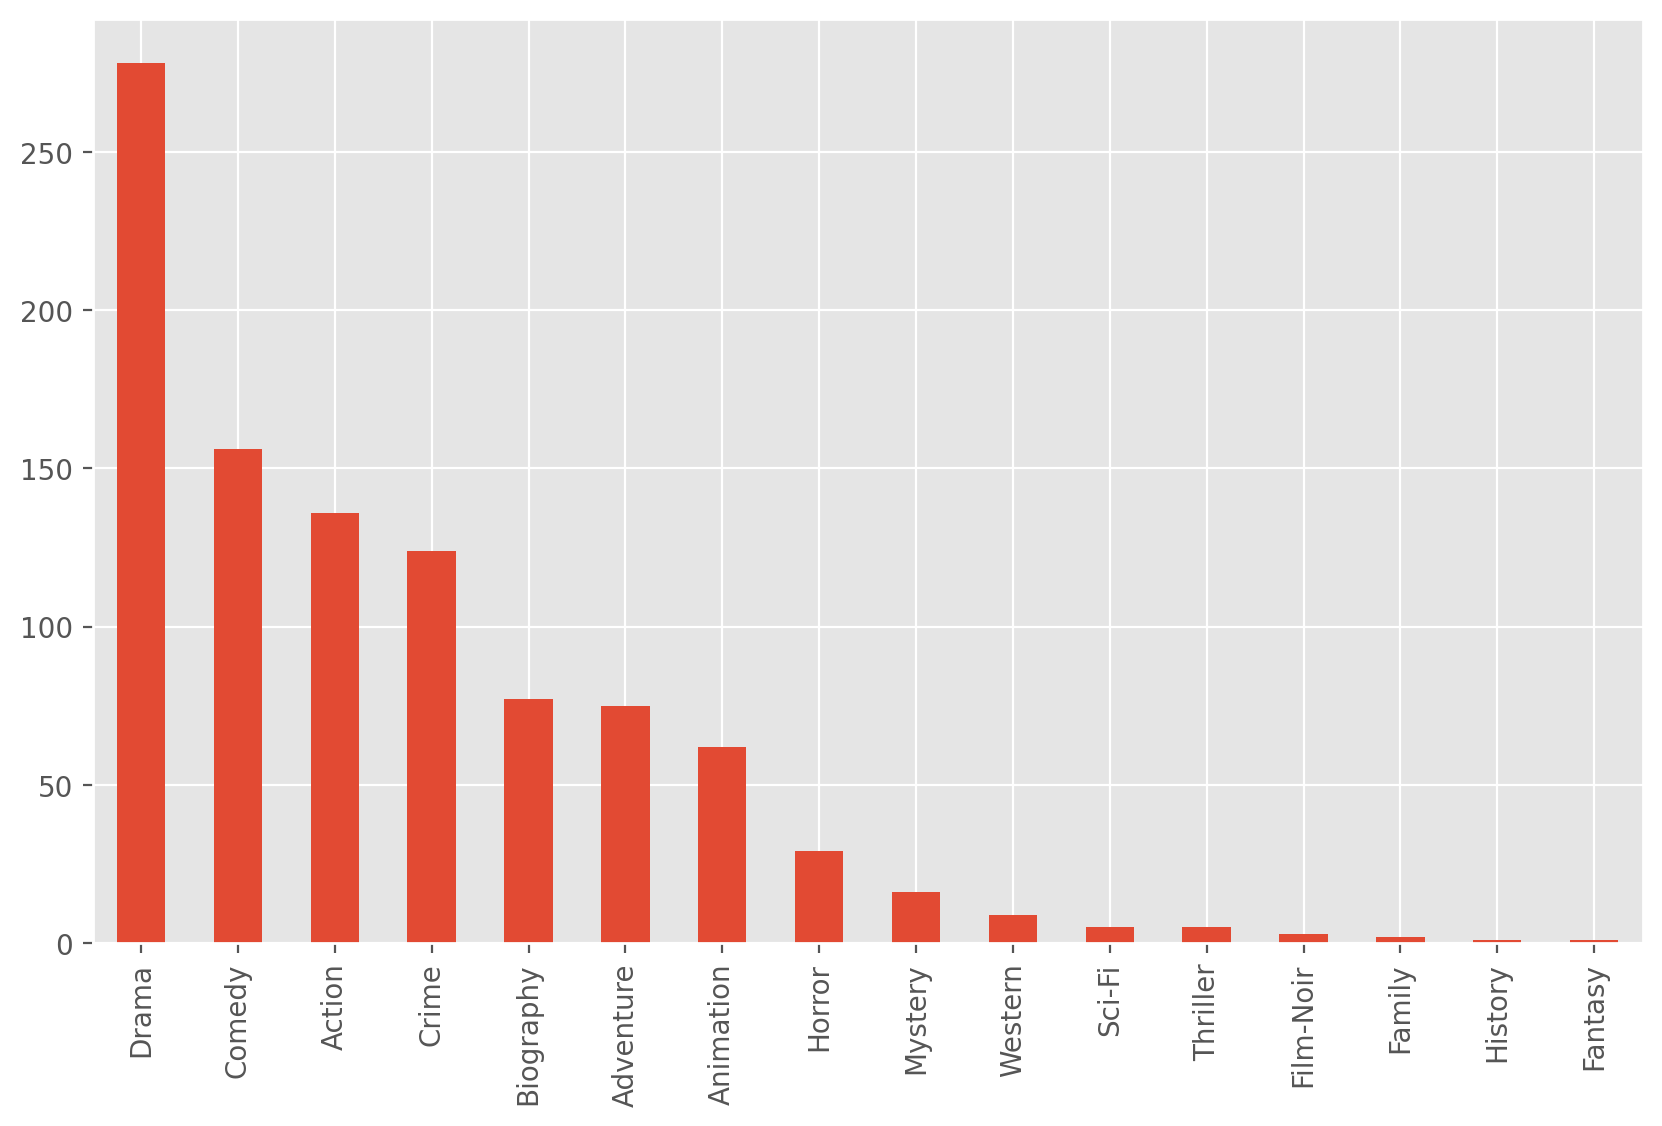

In [30]:
movies.genre.value_counts().plot(kind='bar'); # [Truco] Punto y coma final para evitar el texto del encabezado

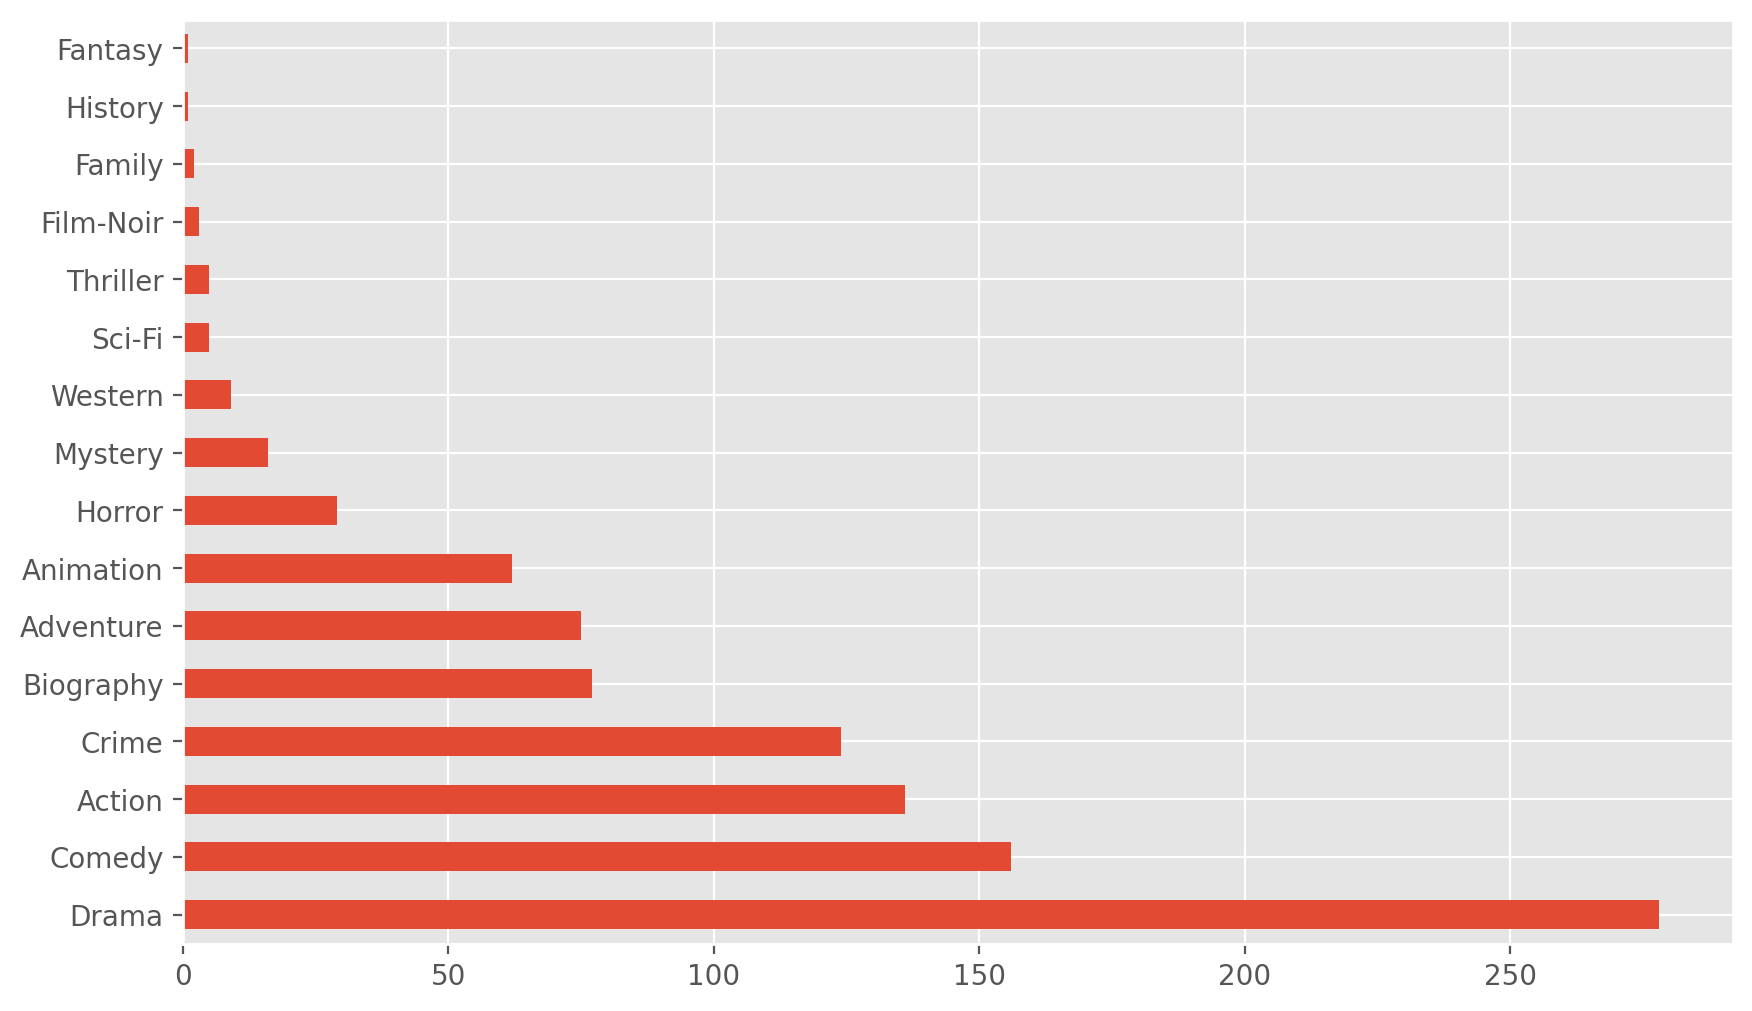

In [31]:
movies.genre.value_counts().plot(kind='barh');

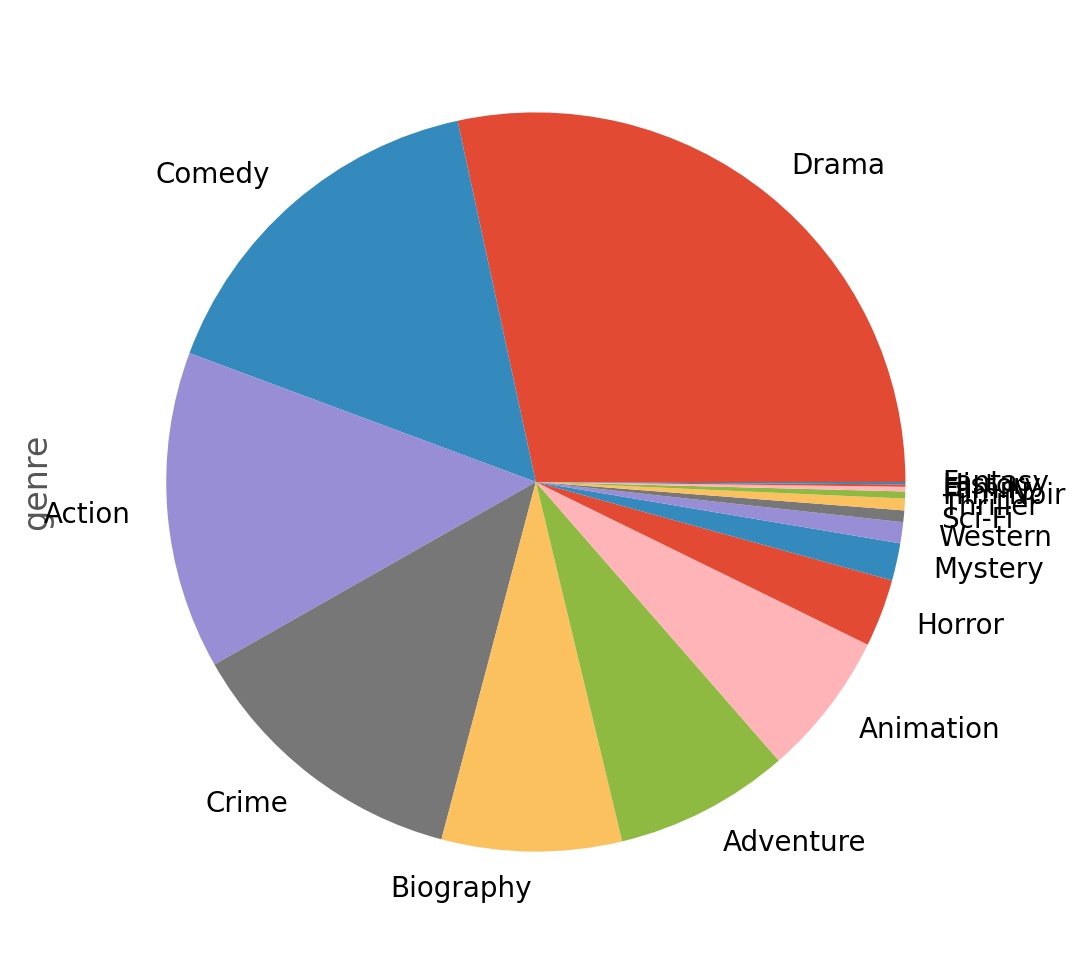

In [32]:
movies.genre.value_counts().plot(kind='pie', figsize=(6, 6));

## Describiendo una variable cuantitativa

Todas las medidas estadísticas presentadas se obtienen directamente a partir de los valores de las muestras. No utilizaremos tablas de frecuencias. En caso de tener una tabla de frecuencias para realizar cálculos, obtendremos la muestra a partir de los valores de la variable (o marca de clase en el caso de intervalos) y sus frecuencias absolutas. Por ejemplo

In [33]:
drinks = pd.read_csv('https://raw.githubusercontent.com/luis-sarro/introstats/master/datasets/drinks.csv')
drinks.head()

,country,beer_servings,spirit_servings,wine_servings,total_litres_of_pure_alcohol,continent
0,Afghanistan,0,0,0,0.0,AS
1,Albania,89,132,54,4.9,EU
2,Algeria,25,0,14,0.7,AF
3,Andorra,245,138,312,12.4,EU
4,Angola,217,57,45,5.9,AF


In [34]:
drinks.beer_servings.describe()

count    193.000000
mean     106.160622
std      101.143103
min        0.000000
25%       20.000000
50%       76.000000
75%      188.000000
max      376.000000
Name: beer_servings, dtype: float64

In [35]:
pd.cut(drinks.beer_servings, bins=5).value_counts(normalize=True)

(-0.376, 75.2]    0.497409
(75.2, 150.4]     0.196891
(150.4, 225.6]    0.139896
(225.6, 300.8]    0.119171
(300.8, 376.0]    0.046632
Name: beer_servings, dtype: float64

In [36]:
probs = pd.cut(drinks.beer_servings, bins=5).value_counts(normalize=True).values
print(probs)
print(sum(probs))

[0.49740933 0.19689119 0.13989637 0.11917098 0.04663212]
1.0


In [37]:
rv_multinomial = st.multinomial(100, probs)
n_en_cada_intervalo=rv_multinomial.rvs()
print(n_en_cada_intervalo)

[[55 19 12  9  5]]


In [38]:
x1 = st.uniform(loc=0., scale=(75.2-0.)).rvs(n_en_cada_intervalo[0][0])
x2 = st.uniform(loc=75.2, scale=(150.4-75.2)).rvs(n_en_cada_intervalo[0][1])
x3 = st.uniform(loc=150.4, scale=(225.6-150.4)).rvs(n_en_cada_intervalo[0][2])
x4 = st.uniform(loc=225.6, scale=(300.8-225.6)).rvs(n_en_cada_intervalo[0][3])
x5 = st.uniform(loc=300.8, scale=(376-300.8)).rvs(n_en_cada_intervalo[0][4])
print(x1)

[69.23387317 42.96618318  8.42680806 75.15895774 46.87751703 40.65916471
  3.19073669 13.46043746  6.92427886  9.99224102 35.66346076 15.70371051
 66.18600704 58.80457301 18.09289663 10.92705968 18.54662443  4.5511287
 21.41837251 22.49320429 73.00923353 21.79616082 11.82340524  6.09775955
 19.26674411 53.8858041  63.09984484 60.23631135 18.40139341 28.27395073
 56.20283998 24.71415689 63.74004058 14.92246564 13.97475111  0.98018733
 69.91846484 53.44518104 54.92651093  6.30703024 38.92160714  5.91738713
 20.00537686 20.19634096 71.27118117 19.44676573 34.06978902 65.58038161
 25.11208154 30.94247631 14.93477647 33.02385758 48.77997229 71.4484167
 66.41603722]


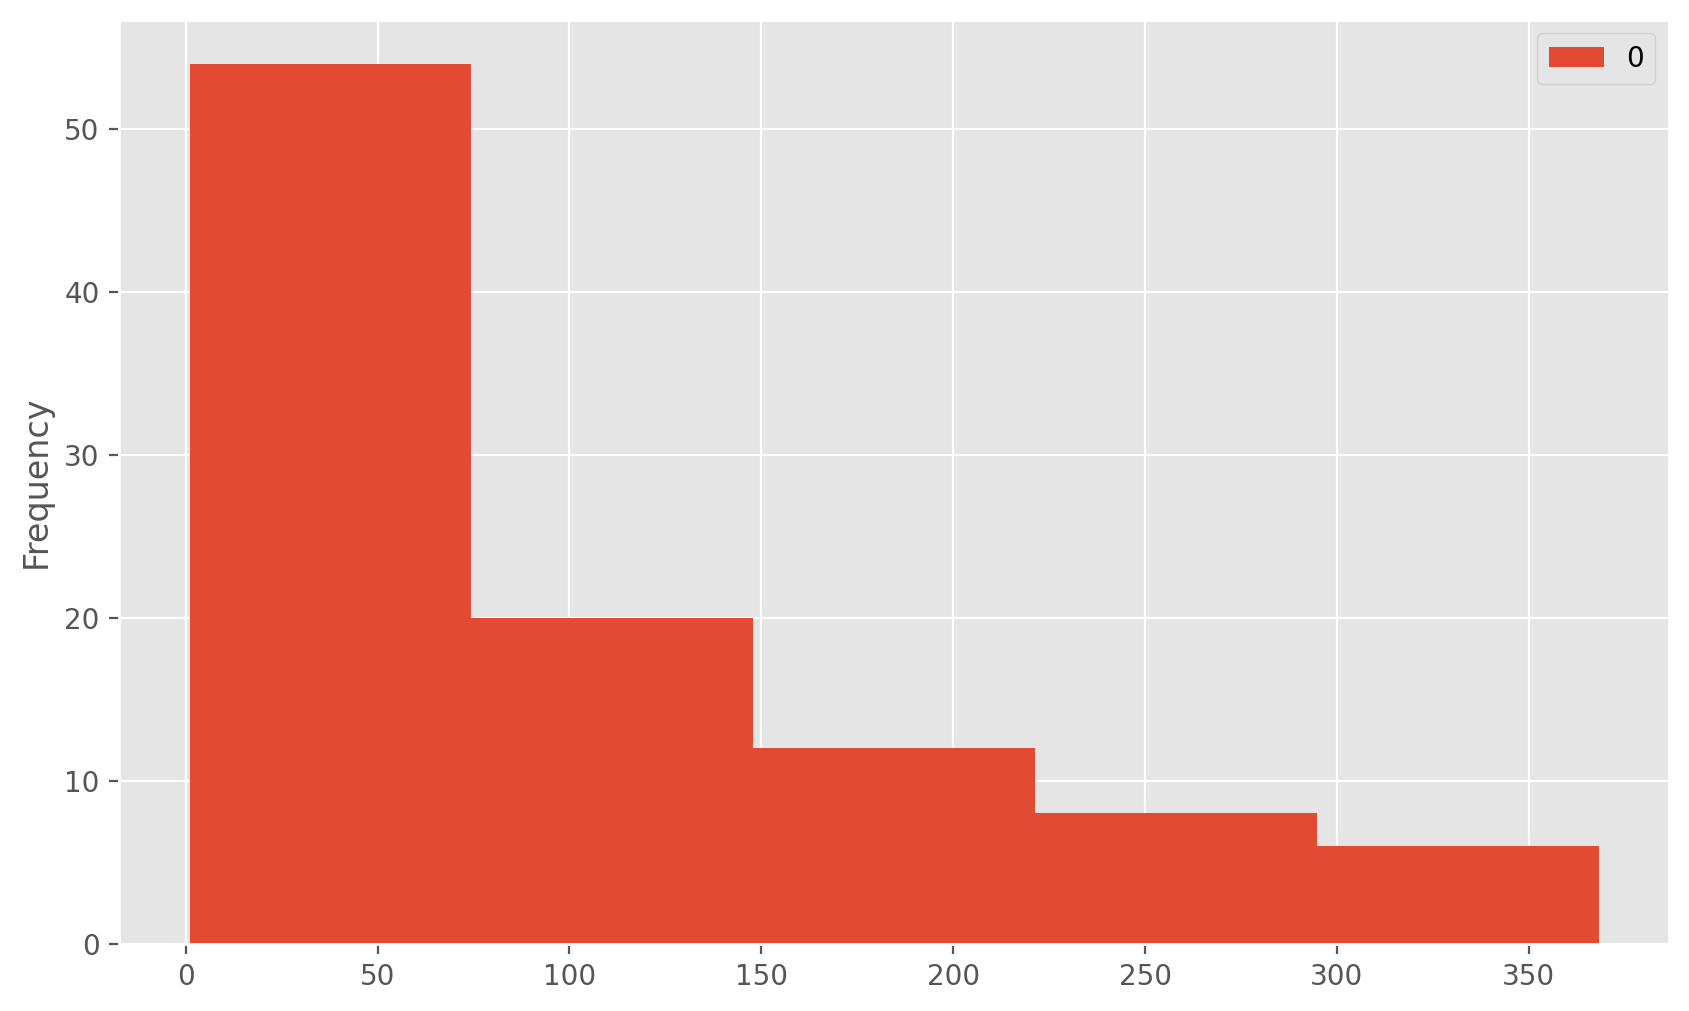

In [39]:
pd.DataFrame(np.concatenate([x1, x2, x3, x4, x5])).plot(kind="hist", bins=5);

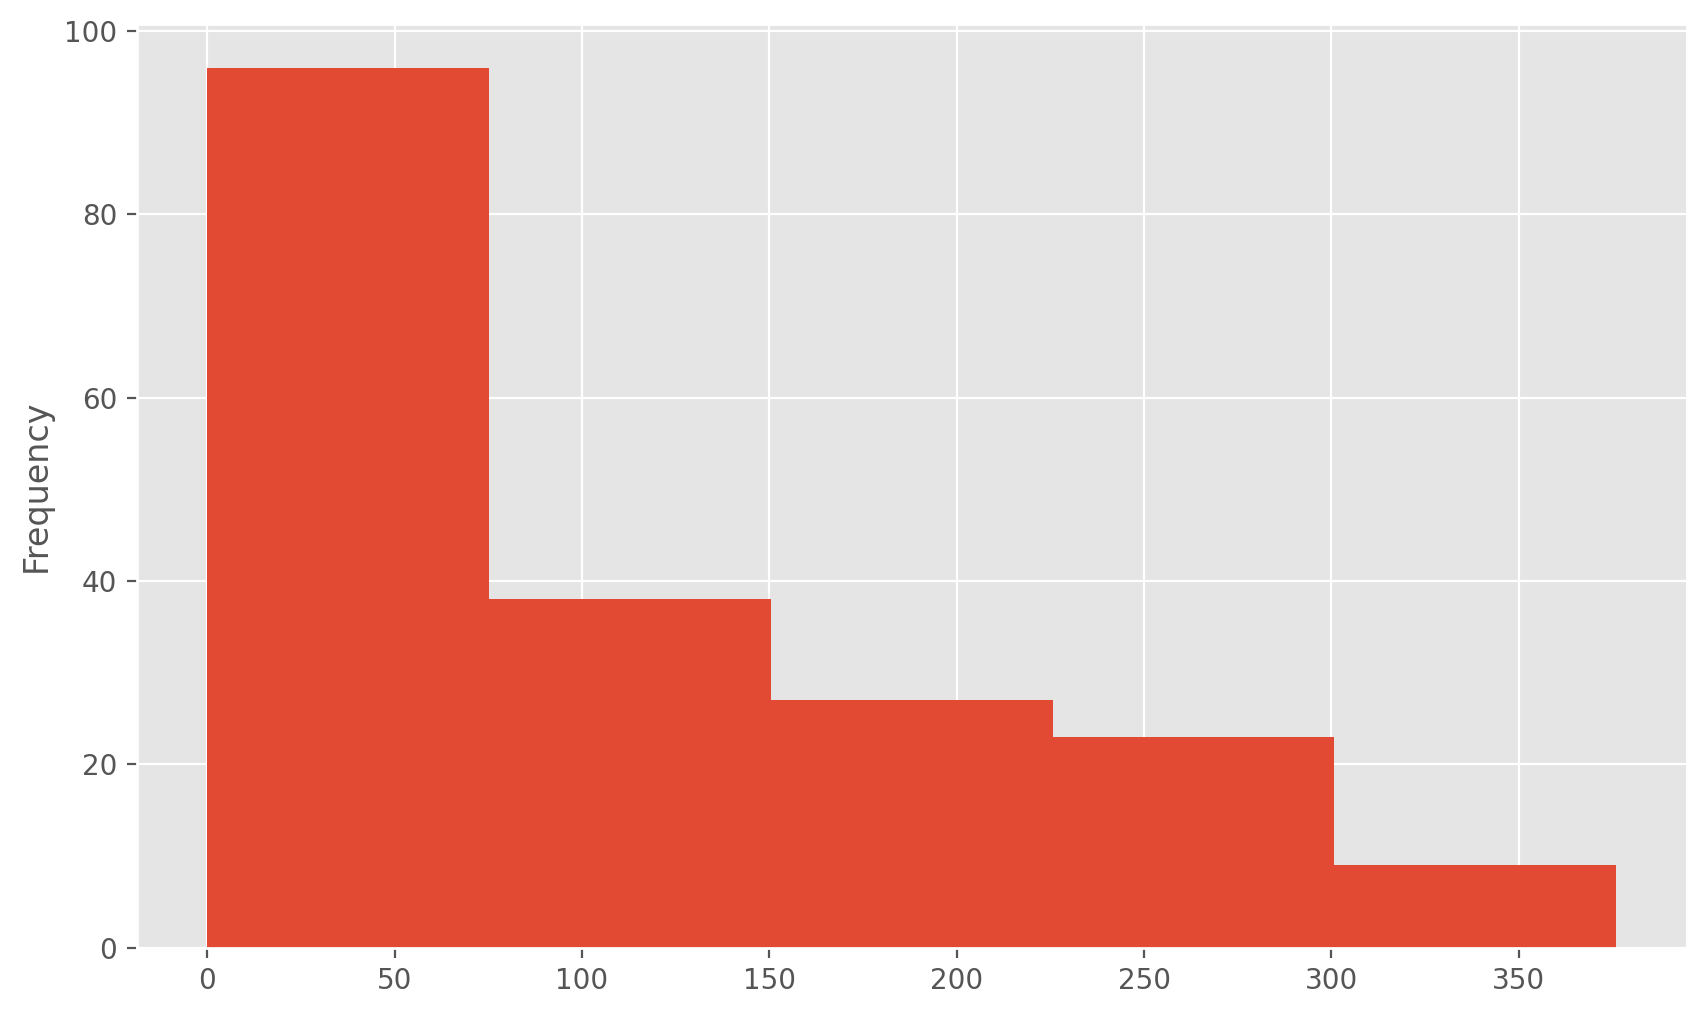

In [40]:
drinks.beer_servings.plot(kind='hist', bins=5); # Mejor densidades si hay intervalos con diferente longitud!!!
# No tiene por qué coincidir porque el histograma de arriba se construye sobre una muestra 
# aleatoria de 100 tiradas con las frecuencias observadas. 

## Descripción de datos no agruapdos

In [41]:
drinks.beer_servings.describe()

count    193.000000
mean     106.160622
std      101.143103
min        0.000000
25%       20.000000
50%       76.000000
75%      188.000000
max      376.000000
Name: beer_servings, dtype: float64

In [42]:
# Tabla de frecuencias: distribución de los datos

intervalos = np.arange(0, 376, 25) # primero creamos los intervalos.
frec = pd.cut(drinks.beer_servings, intervalos) # luego asignamos cada valor al intervalo correspondiente
tabla_frec = pd.value_counts(frec) #por último hacemos el recuento de los intervalos para armar la tabla de frecuencia.
#tabla_frec = pd.value_counts(frec, normalize=True)
tabla_frec

(0, 25]       44
(25, 50]      20
(75, 100]     18
(50, 75]      17
(125, 150]    11
(225, 250]    11
(175, 200]    10
(100, 125]     9
(150, 175]     9
(200, 225]     8
(275, 300]     7
(250, 275]     5
(325, 350]     5
(300, 325]     2
(350, 375]     1
Name: beer_servings, dtype: int64

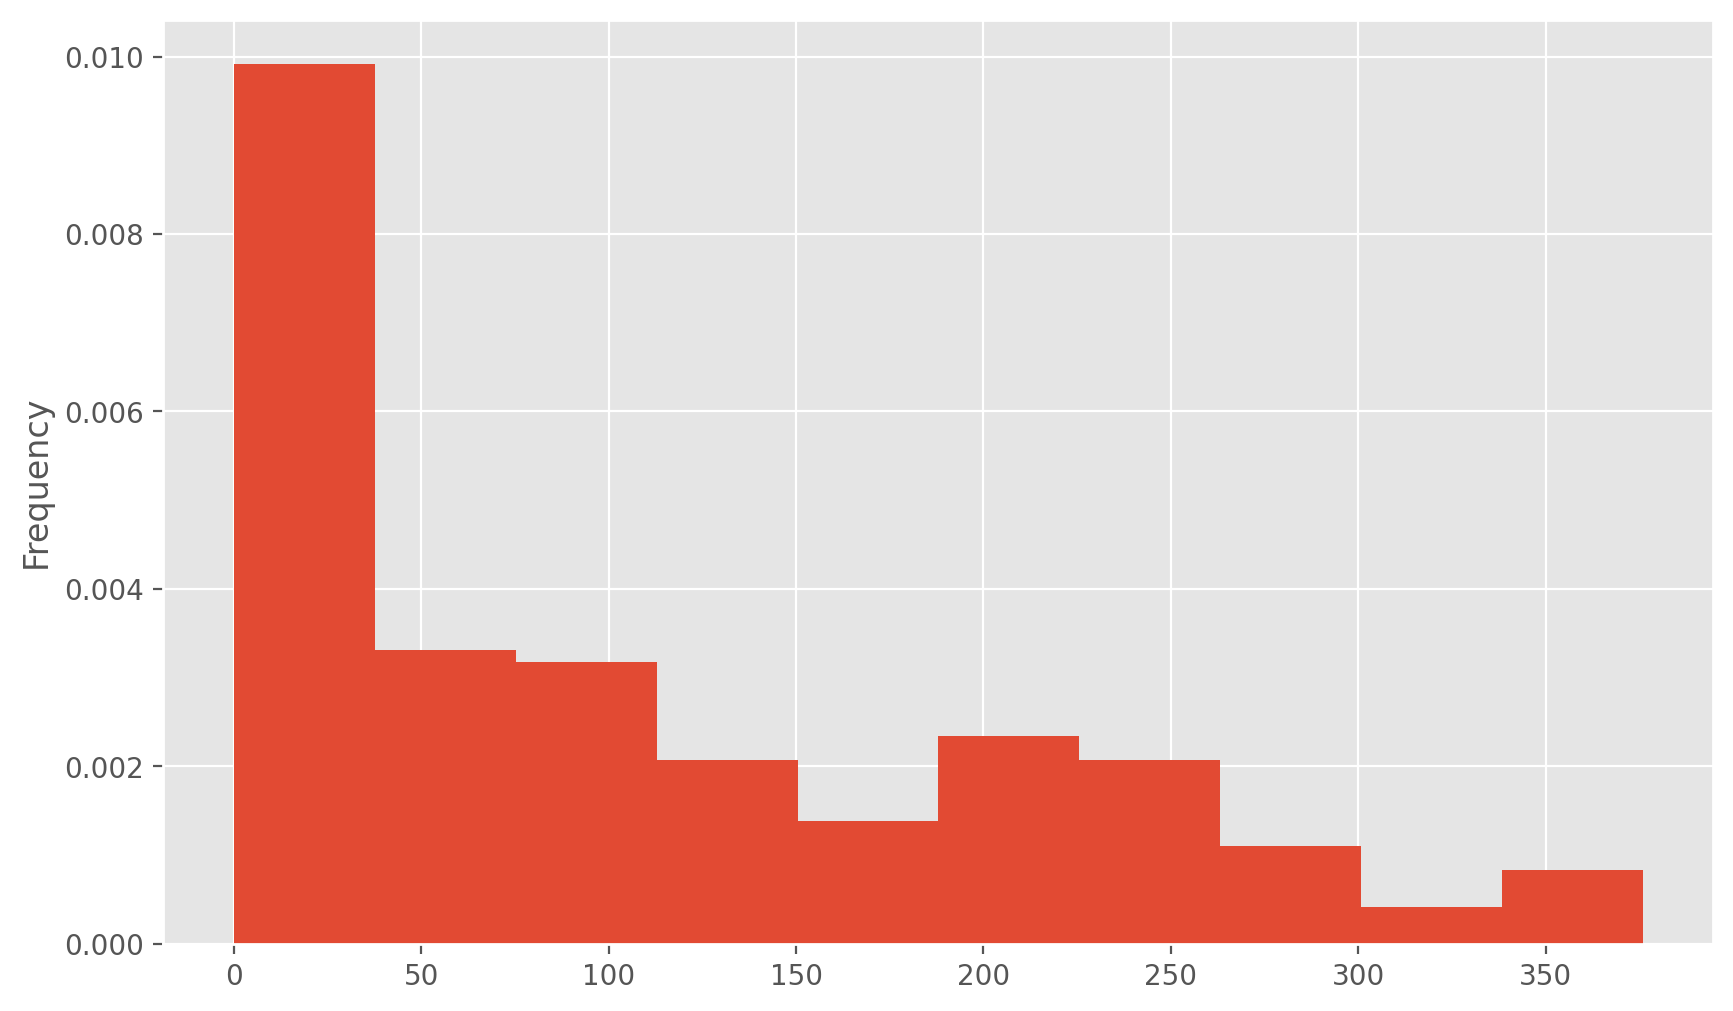

In [43]:
drinks.beer_servings.plot(kind='hist', density=True); # Mejor densidades si hay intervalos con diferente longitud!!!
# drinks.beer_servings.plot(kind='hist')
# drinks.beer_servings.plot(kind='hist', bins = 5)
# drinks.beer_servings.plot(kind='hist', bins = np.linspace(0.0, 380.0, num=5))

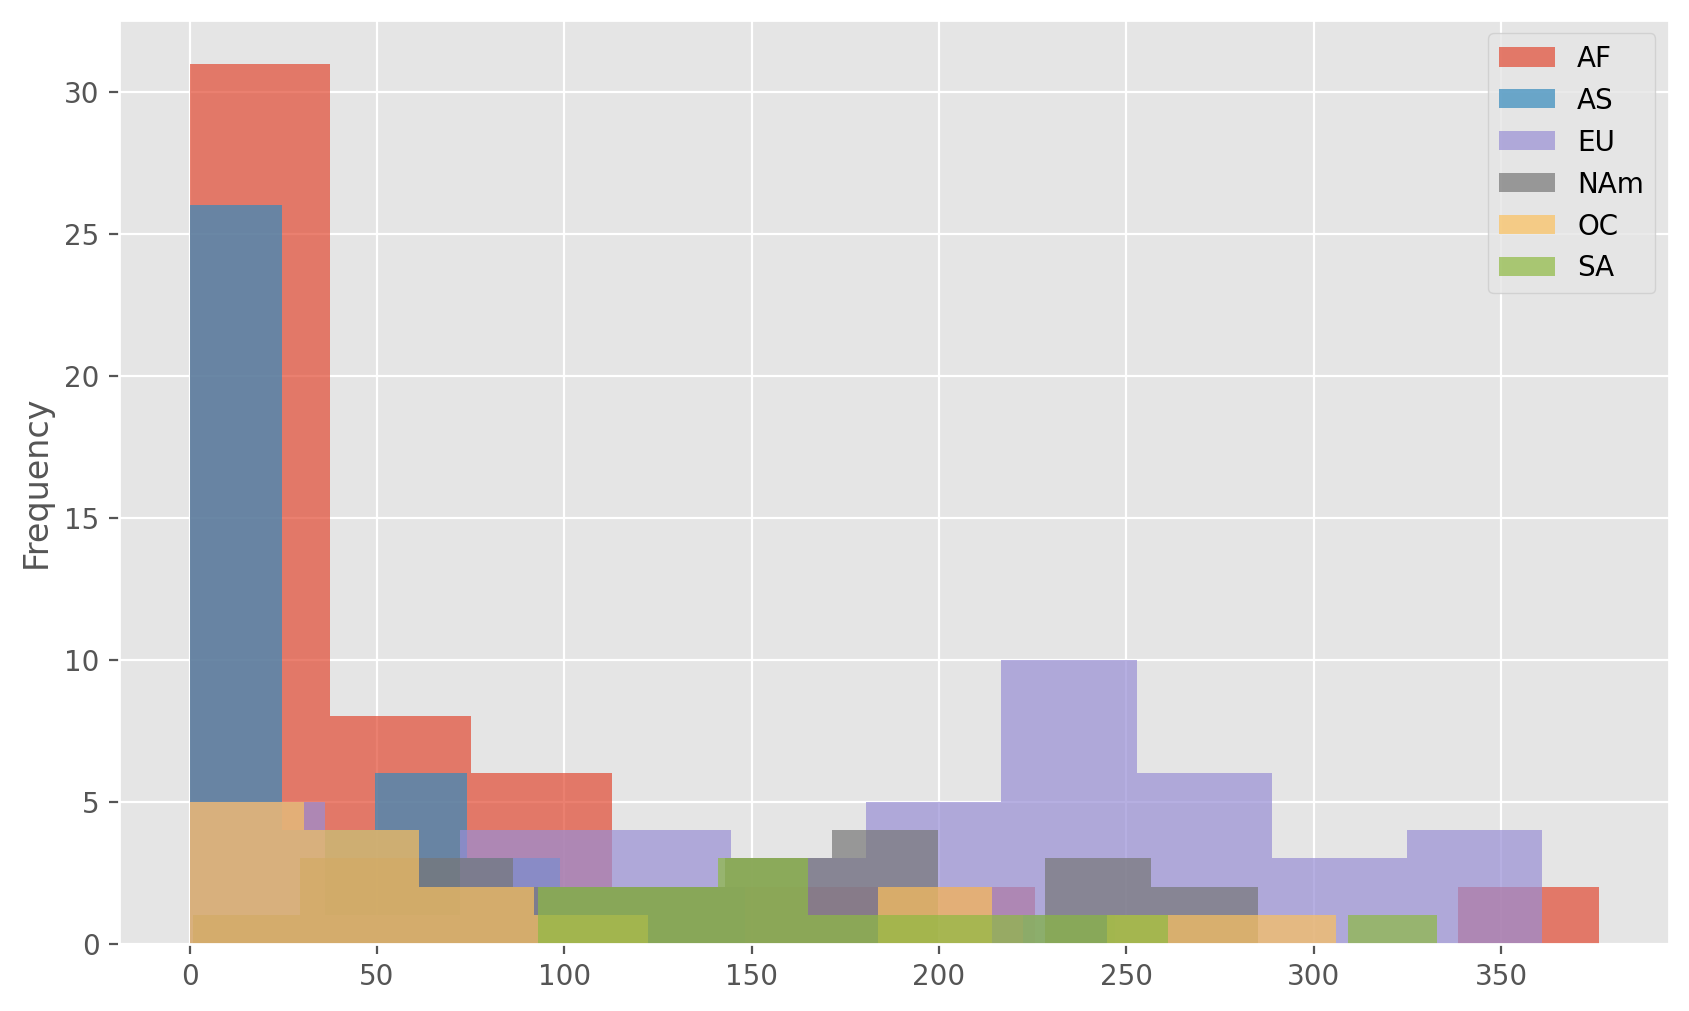

In [44]:
drinks.groupby('continent').beer_servings.plot(kind='hist', legend = True, alpha=0.7);

## Medidas de posición centrales (medidas de centralización)

Las medidas de posición central sirven para representar globalmente el comportamiento de los datos observados y localizar la distribución de frecuencias.

### Media

Dada la distribución de valores de una variable aleatoria $\{x_i\}_{i=1,2,...,N}$,
se llama media aritmética al valor: $$\overline{x} =
\displaystyle{\frac{\displaystyle{\sum_{i=1}^N
x_i}}{N}}$$

#### A tener en cuenta:

1. Esta medida utiliza todos los valores de la variable (los valores ausentes no los tiene en cuenta).
2. Valores de la variable anormalmente extremos pueden distorsionar la media aritmética. La solución será eliminarlos o calcular otra medida de posición que no se vea afectada por los mismos.


In [45]:
drinks.mean(numeric_only=True)

beer_servings                   106.160622
spirit_servings                  80.994819
wine_servings                    49.450777
total_litres_of_pure_alcohol      4.717098
dtype: float64

In [46]:
drinks.beer_servings.mean()

106.16062176165804

In [47]:
drinks.groupby('continent').beer_servings.mean()

continent
AF      61.471698
AS      37.045455
EU     193.777778
NAm    145.434783
OC      89.687500
SA     175.083333
Name: beer_servings, dtype: float64

In [48]:
drinks.groupby('continent').mean(numeric_only=True)

,beer_servings,spirit_servings,wine_servings,total_litres_of_pure_alcohol
continent,,,,
AF,61.471698,16.339623,16.264151,3.007547
AS,37.045455,60.840909,9.068182,2.170455
EU,193.777778,132.555556,142.222222,8.617778
NAm,145.434783,165.739130,24.521739,5.995652
OC,89.687500,58.437500,35.625000,3.381250
SA,175.083333,114.750000,62.416667,6.308333


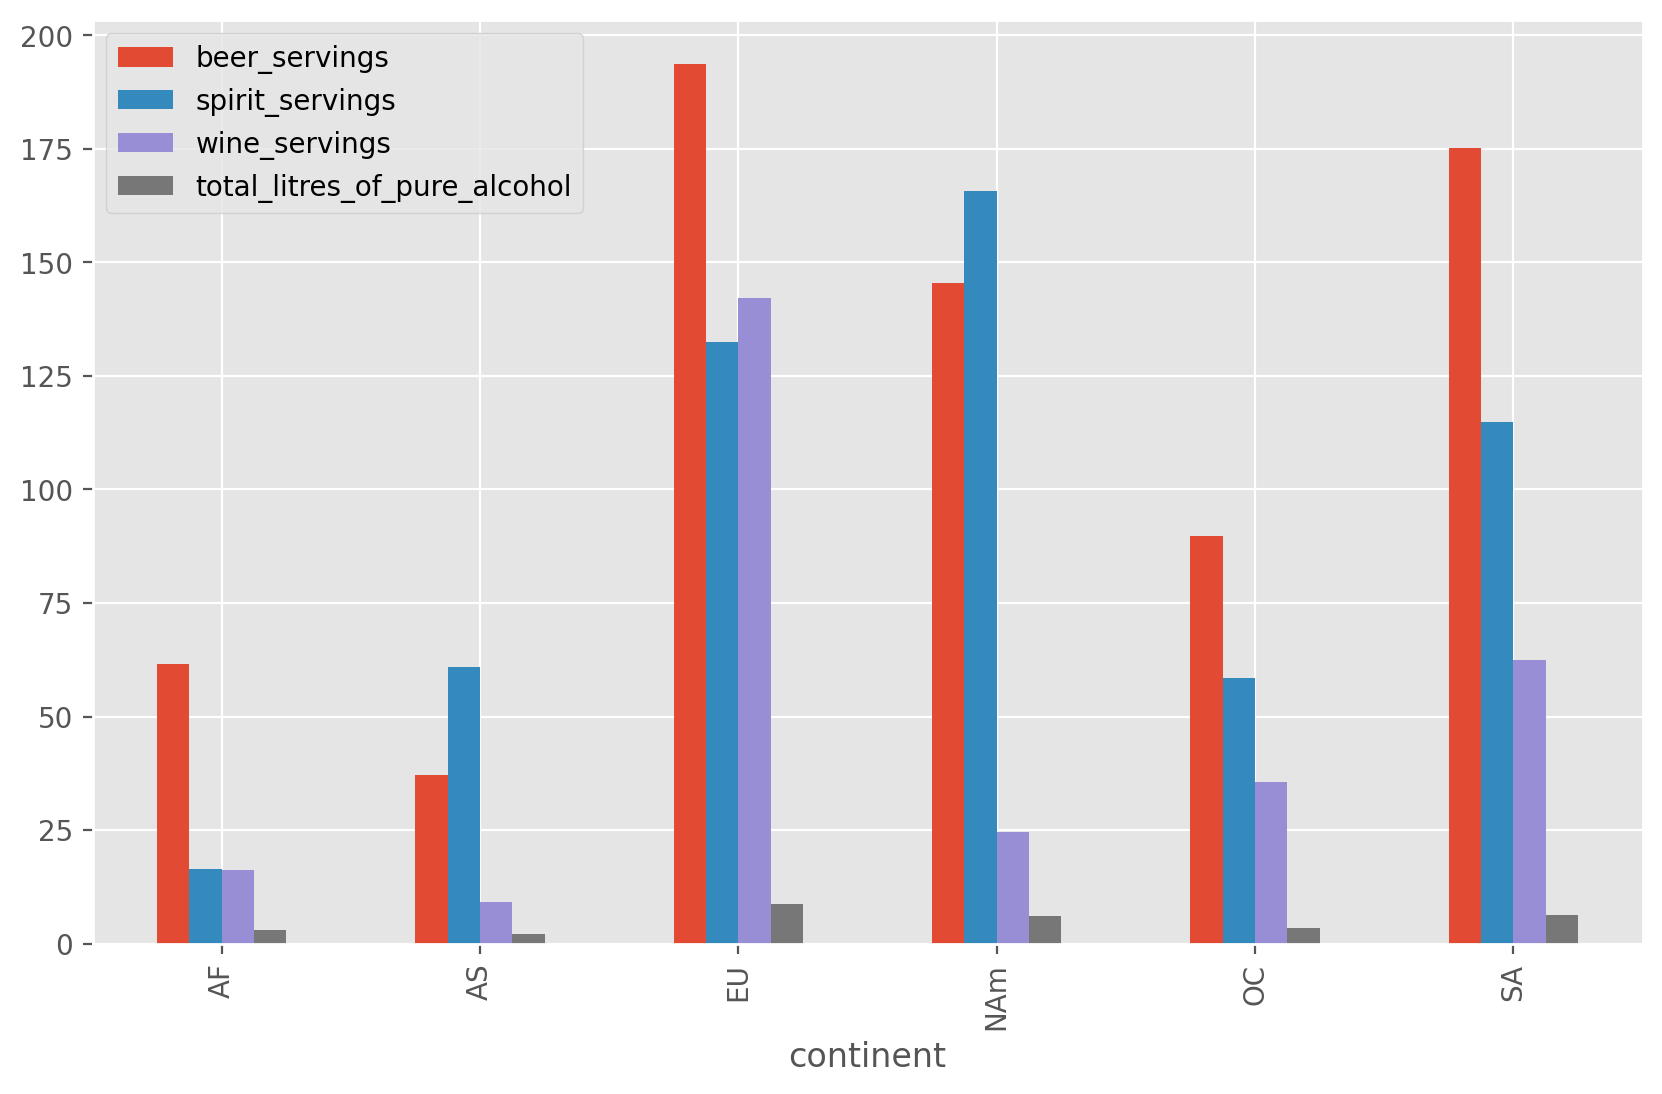

In [49]:
drinks.groupby('continent').mean(numeric_only=True).plot(kind='bar');

### Mediana

La mediana, $M_e$, es un valor tal que, ordenados los valores de
la distribución de menor a mayor, separa a los mismos en dos
partes que contienen el mismo número de datos.


In [50]:
drinks.median(numeric_only=True)

beer_servings                   76.0
spirit_servings                 56.0
wine_servings                    8.0
total_litres_of_pure_alcohol     4.2
dtype: float64

### Moda

La moda, $M_o$, es el valor de la variable que más se repite. Existen distribuciones que pueden tener más de una moda. Distribuciones no agrupadas en intervalos. La moda es el valor de la variable de mayor frecuencia absoluta.

In [51]:
print(drinks.beer_servings.mode())
print(drinks.beer_servings.value_counts())

0    0
Name: beer_servings, dtype: int64
0      15
5       5
25      4
21      4
31      4
       ..
234     1
69      1
28      1
142     1
64      1
Name: beer_servings, Length: 130, dtype: int64


## Medidas de posición no centrales

Los cuantiles son valores que, una vez ordenada de menor a mayor
la distribución, la dividen en partes iguales, es decir, en
intervalos que comprenden el mismo número de valores.

### Cuartiles

Los cuartiles. Son tres valores que, una vez ordenada de menor a
mayor la distribución, la dividen en cuatro partes iguales. Es
decir, en cuatro intervalos dentro de cada uno de los cuales está
contenido un $25 \%$ de los valores. Los representaremos por
$Q_{r/4}$ con $r=1,2,3$. (Observemos que $Q_{1/2}=M_e$)

### Deciles

Los deciles. Son nueve valores que, una vez ordenada de menor a
mayor la distribución, la dividen en diez partes iguales. Dentro
de cada una está contenido un $10 \%$ de los valores de la
distribución. Los expresaremos como $Q_{r/10}$ con $r=1,2, ...,9$.
($Q_{5/10}=M_e$)

### Percentiles

Los percentiles. Son 99 valores que dividen a la distribución en
cien partes iguales, una vez ordenada de menor a mayor. De este
modo, entre dos percentiles consecutivos encontramos un $1 \%$ de
los datos. Escribiremos $Q_{r/100}$ con $r=1,2, ...,99$.
($Q_{50/100}=M_e$)

In [52]:
drinks.beer_servings.quantile([.20, .30])

0.2    13.8
0.3    25.0
Name: beer_servings, dtype: float64

## Medidas de dispersión

Se llama dispersión o variabilidad, a la menor o mayor separación
de los valores respecto a otro que se pretende sea la síntesis.

### Medidas de dispersión absoluta

El __recorrido__ es la diferencia entre el mayor y el menor valor de
la variable: $$R= \max _ix_i - \min _ix_i$$

In [53]:
drinks.max(numeric_only=True) - drinks.min(numeric_only=True)

beer_servings                   376.0
spirit_servings                 438.0
wine_servings                   370.0
total_litres_of_pure_alcohol     14.4
dtype: float64

In [54]:
drinks.groupby('continent').beer_servings.max()

continent
AF     376
AS     247
EU     361
NAm    285
OC     306
SA     333
Name: beer_servings, dtype: int64

In [55]:
drinks.groupby('continent').beer_servings.agg(['count', 'min', 'max'])

,count,min,max
continent,,,
AF,53,0,376
AS,44,0,247
EU,45,0,361
NAm,23,1,285
OC,16,0,306
SA,12,93,333


* Ventajas del recorrido
    * Es una medida de fácil cálculo
    * Es útil en situaciones en las que se requiera medir la dispersión
    con mucha frecuencia y sobre pocos valores.

* Inconvenientes del recorrido
    * Total dependencia de los valores extremos de la serie de datos.
    * No tiene en cuenta los valores intermedios de la variable, así que
    puede no ser muy precisa.
    * No puede ser calculado si el valor máximo o el mínimo no están
    determinados.

El __recorrido intercuartílico__ (también llamado __rango intercuartílico__) nos indica la amplitud del intervalo donde
están comprendidos el $50 \%$ central de los valores, y se calcula:
$$R_I=Q_{3/4}-Q_{1/4}$$

Presenta como ventaja respecto al recorrido, la eliminación del posible
efecto que pudieran tener algunos valores extremos.

In [56]:
drinks.describe()

,beer_servings,spirit_servings,wine_servings,total_litres_of_pure_alcohol
count,193.000000,193.000000,193.000000,193.000000
mean,106.160622,80.994819,49.450777,4.717098
std,101.143103,88.284312,79.697598,3.773298
min,0.000000,0.000000,0.000000,0.000000
25%,20.000000,4.000000,1.000000,1.300000
50%,76.000000,56.000000,8.000000,4.200000
75%,188.000000,128.000000,59.000000,7.200000
max,376.000000,438.000000,370.000000,14.400000


In [57]:
drinks.describe().loc['75%', 'beer_servings'] - drinks.describe().loc['25%', 'beer_servings']

168.0

### Diagrama de caja y bigotes

Se trata de una síntesis gráfica de una distribución en la que
intervienen las siguientes medidas: media aritmética, mediana, cuartiles
primero y tercero. Su construcción es como sigue:

1.  Tomamos una escala que contenga el recorrido de la variable.

2.  Se dibuja una caja, rectángulo, cuyos lados horizontales vayan desde
    el primer hasta el tercer cuartil.

3.  Dibujamos en el interior de la caja una barra horizontal en la
    posición de la mediana y una marca allí donde se sitúe la media
    aritmética.

4.  Desde los lados horizontales de la caja se dibujan dos segmentos
    verticales (los bigotes) que se extienden arribay abajo
    hasta los valores más alejados de la variable que no que superen
    $1,5$ veces el recorrido intercuartílico. Los valores que queden más allá de estos segmentos se consideran datos atípicos (outliers).

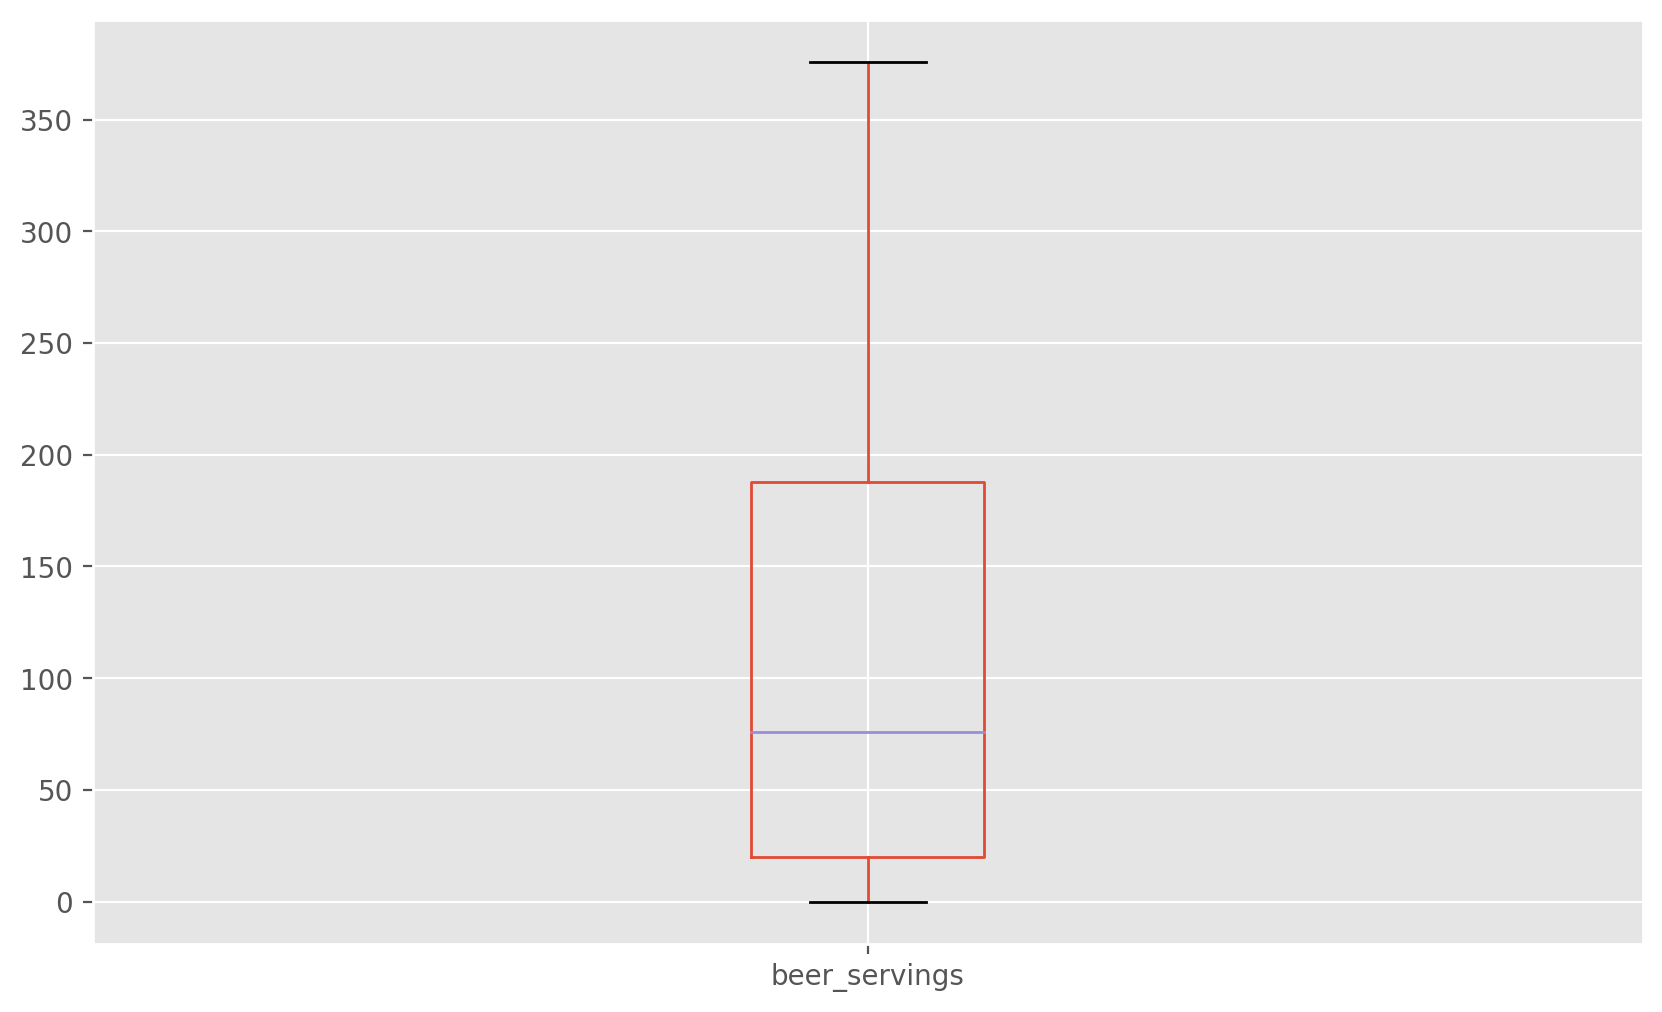

In [58]:
drinks.boxplot(column='beer_servings');

1.  Con esta representación se consigue una impresión rápida de
    ciertas características básicas de un conjunto de datos: posición,
    dispersión y simetría o asimetría.

2.  La caja del diagrama contiene la mitad central de los datos.

3.  A medida que la mediana esté más centrada en la caja, y cuanto más
    similares sean las longitudes de los bigotes, más simétrica es la
    distribución.


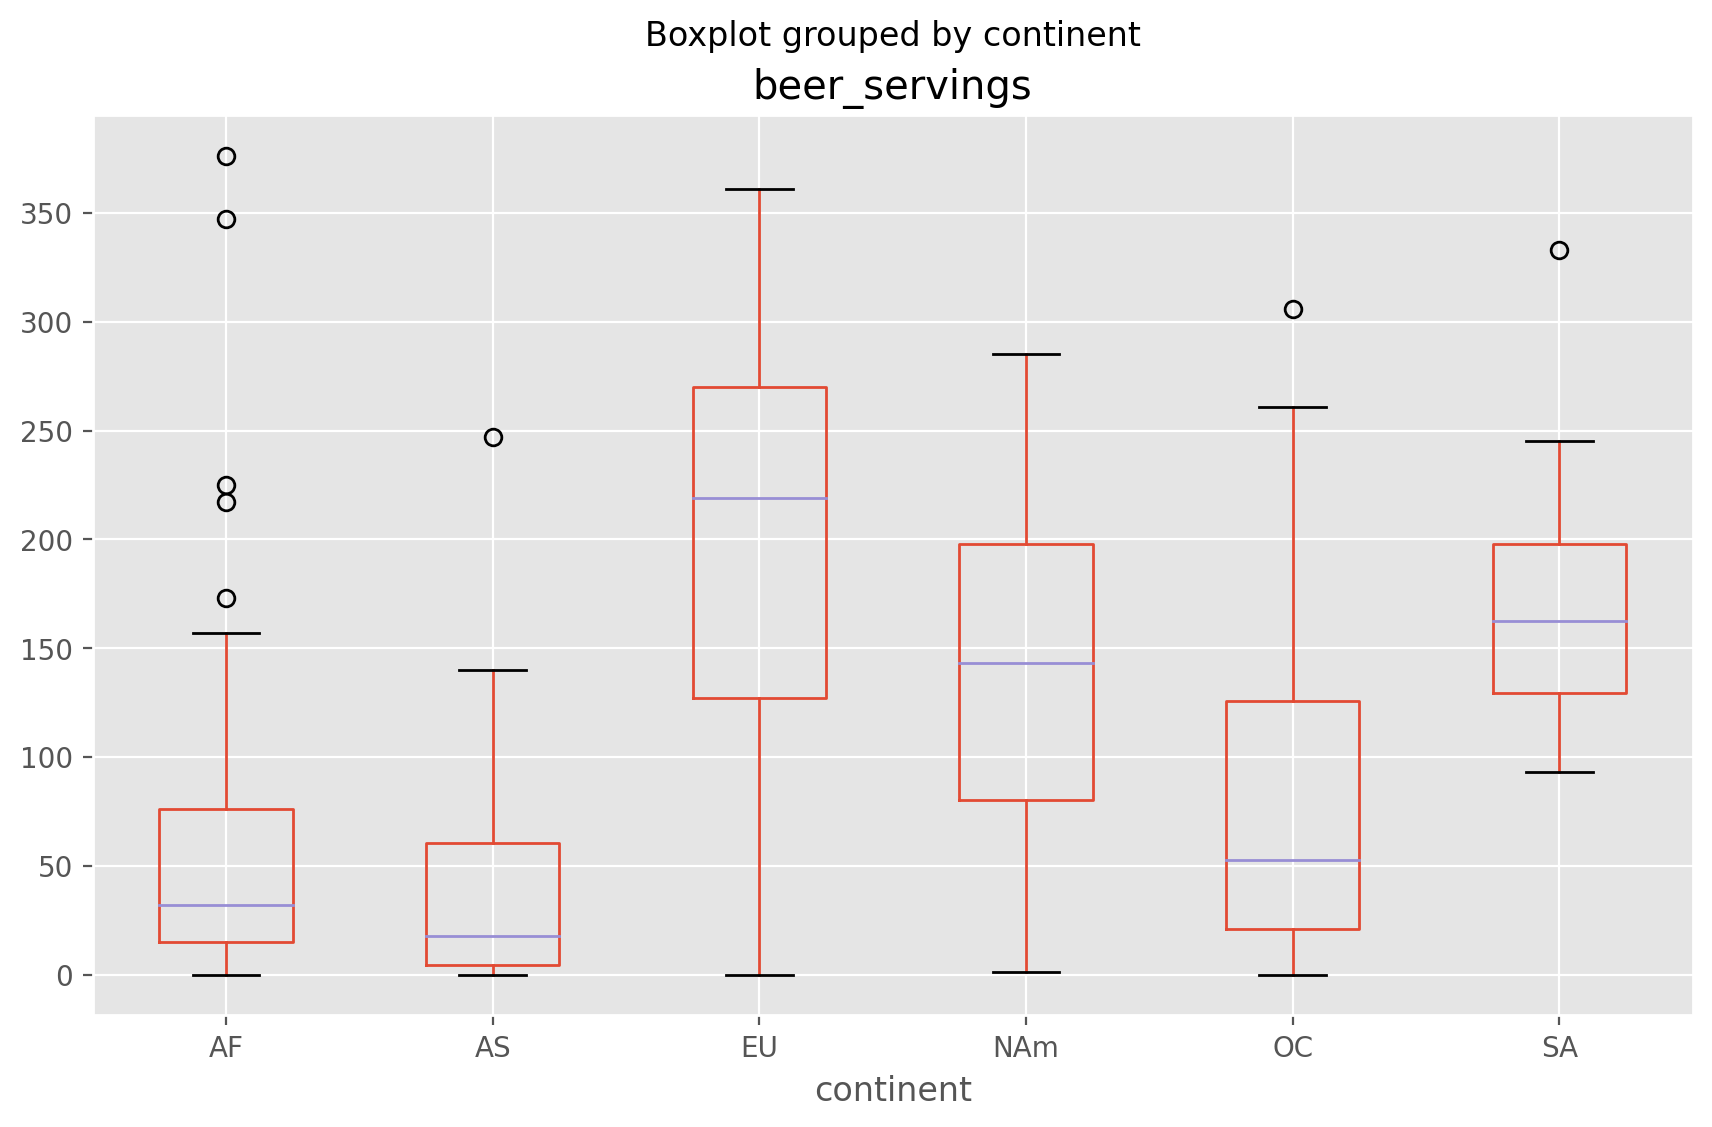

In [59]:
drinks.boxplot(column='beer_servings', by='continent');

#### Varianza y desviación típica

Son las dos medidas de dispersión absoluta más importantes.

La varianza es la media aritmética de los cuadrados de las desviaciones
de los datos respecto a la media. Es decir,
$$s^2=\displaystyle{\frac{1}{N}\sum_{i=1}^N (x_i-\overline{x})^2}$$

A veces se usa también la cuasivarianza, definida por:
$$s_c^2=\displaystyle{\frac{1}{N-1} \sum_{i=1}^N (x_i-\overline{x})^2}$$ 

Evidentemente: $Ns^2= (N-1) \cdot s_c^2$

__[Nota]__ Si $N$ es grande, entonces $s^2$ y $s_c^2$ son prácticamente iguales.

#### Propiedades de la varianza

1.  La varianza es siempre mayor o igual que cero, por ser suma de
    cuadrados, y se anula solamente cuando todos los valores de la
    variable son iguales entre sí.

2.  __(Teorema de König)__ La varianza es la medida cuadrática de dispersión óptima ya que,
    para cualquier valor $p$ se verifica que:
    $$s^2=\displaystyle{\frac{1}{N} \sum_{i=1}^N (x_i-\overline{x})^2} \leq \frac{1}{N} \displaystyle{\sum_{i=1}^N (x_i-p)^2 \cdot}$$ 

3.  Se verifica que $s^2= \displaystyle{\frac{1}{N}\sum_{i=1}^N x_i^2}- \left( \overline{x} \right) ^2$

4.  Viene expresada en las unidades de la variable elevadas al cuadrado.

Se define la desviación típica como la raíz cuadrada positiva de la
varianza. Es decir: 

$$ s=+\sqrt{s^2}=+\displaystyle{\sqrt{\displaystyle{\frac{1}{N}\sum_{i=1}^N
(x_i-\overline{x})^2}}}$$

#### Propiedades de la desviación típica

1.  Es siempre mayor o igual que cero.

2.  Es una medida de dispersión óptima.

3.  Valores pequeños de la desviación típica indican poca dispersión de
    las observaciones con respecto a la media.

4.  Viene medida en las mismas unidades de la variable.

5.  El intervalo $(\overline{x}-2s,\overline{x}+2s)$ contiene al menos
    el 75 % de los valores de la distribución (el 95% para una distribución Gaussiana).

In [60]:
drinks.var(numeric_only=True) # Return unbiased variance over requested axis.

beer_servings                   10229.927191
spirit_servings                  7794.119765
wine_servings                    6351.707200
total_litres_of_pure_alcohol       14.237779
dtype: float64

In [61]:
drinks.std(numeric_only=True) # Return sample standard deviation

beer_servings                   101.143103
spirit_servings                  88.284312
wine_servings                    79.697598
total_litres_of_pure_alcohol      3.773298
dtype: float64

### Medidas de dispersión relativa

Supongamos que tenemos dos distribuciones de frecuencias cuyas medidas
de posición son $p_1$ y $p_2$. Como tales medidas pueden venir expresadas en distintas
unidades, no podremos comparar la representatividad de ambas utilizando
las medidas de dispersión absoluta.

Es preciso construir medidas de dispersión adimensionales, es decir,
medidas que resulten independientes de la unidad con que se miden los
valores de cada variable. Son las medidas de dispersión relativa.

#### Recorridos

El recorrido relativo viene dado por la expresión:
$$R_r=\displaystyle{\frac{R}{\overline{x}}}=
\displaystyle{\frac{\displaystyle{\max _ix_i - \min
_ix_i}}{\overline{x}}}$$ Nos proporciona el número de veces que el
recorrido contiene a la media aritmética.

El recorrido semiintercuartílico se define como: $$R_{SI}=
\displaystyle{\frac{\displaystyle{\frac{Q_{3/4}-Q_{1/4}}{2}}}{\displaystyle{\frac{Q_{1/4}+Q_{3/4}}{2}}}}=
\displaystyle{\frac{Q_{3/4}-Q_{1/4}}{Q_{1/4}+Q_{3/4}}}$$ Compara la
semidistancia entre los cuartiles primero y tercero con el punto medio
de dicho intervalo.

#### El coeficiente de variación de Pearson

Se define por la expresión: $$V=
\displaystyle{\frac{s}{|\overline{x}|}}$$

* Propiedades del coeficiente de variación de Pearson

    * Es una medida adimensional y suele expresarse multiplicada por cien,
    es decir en forma de porcentaje.
    * Representa el número de veces que la desviación típica contiene a
    $|\overline{x}|$. Cuanto mayor es $V$ menos representativa es
    $\overline{x}$.
    * La máxima representatividad de $\overline{x}$ se tiene cuando $V=0$. Dudaremos de la representatividad de $\overline{x}$ si $V>0.5$.
    * Si $\overline{x}=0$, $V$ no es calculable.

In [62]:
drinks.std(numeric_only=True)/drinks.mean(numeric_only=True).abs()

beer_servings                   0.952737
spirit_servings                 1.090000
wine_servings                   1.611655
total_litres_of_pure_alcohol    0.799919
dtype: float64

### Simetría

Ahora damos un paso más al intentar precisar la forma de la
distribución. Las medidas de forma se dirigen a elaborar valores que
midan el aspecto de la representación gráfica de la distribución sin
necesidad de llevarla a cabo.

Si por $\overline{x}$ trazamos una perpendicular al eje horizontal y la
tomamos como eje de simetría, diremos que la distribución es simétrica
si existe el mismo número de valores a ambos lados del eje y
equidistantes de él hay pares de valores con la misma frecuencia.

Si la distribución no es simétrica, puede ocurrir:

1.  Que los valores bajos de la variable sean los más frecuentes.
    Gráficamente observaríamos una cola alargada hacia la derecha de la moda y la
    distribución se dirá que es asimétrica a derechas o que tiene
    asimetría positiva.

2.  Que los valores altos sean los más frecuentes. Gráficamente se
    observaría una cola alargada hacia la izquierda de la moda y la distribución se
    dirá que es asimétrica a izquierdas o que tiene asimetría negativa.

En las distribuciones simétricas, las desviaciones de los valores a la
izquierda de la media son igualmente frecuentes que las de los valores a
la derecha y, por tanto, todos los promedios calculados con potencias
impares de ellas serán nulos.

No debemos considerar potencias pares porque nos interesa tener en
cuenta el signo de las desviaciones a la media. Tampoco debemos usar el
promedio de las desviaciones a la media, ya que es cero en cualquier
caso. Por tanto, recurriremos al promedio calculado con las potencias
terceras de las desviaciones. Este promedio acentúa las desviaciones a
la media de los valores altos y bajos de la variable cuando no hay
simetría, representando así un índice del sesgo de la distribución.

#### Coeficiente de asimetría de Fisher

Se define el coeficiente de asimetría de Fisher como la expresión:
$$g_1= \frac{\displaystyle{\sum_{i=1}^N (x_i-\overline{x})^3}}{N s^3}$$

El coeficiente de asimetría de Fisher es una medida adimensional.

1.  Si la distribución es simétrica $\Rightarrow$
    $\displaystyle{\sum_{i=1}^k (x_i-\overline{x})^3}$ $\Rightarrow$
    $g_1=0$. El recíproco no es cierto, en general, como podemos
    observar en el ejemplo siguiente:

    Se considera la distribución siguiente:
    $$\begin{array}{|c|c|c|c|c|c|}
      \hline
       l_{i-1}-l_i & x_i & n_i & x_in_i & (x_i-\overline{x})^3 \cdot n_i & h_i \\
        \hline\hline
       -1 - 1 & 0 & 2 &  0 & -128 & 2/12 \\
        4-6 & 5 & 3 & 15 & 3 & 3/12  \\
        8- 10 & 9 & 1 & 9 & 125 & 1/12  \\
            \hline
         & & 6 & 24 & 0 & \\
        \hline
      \end{array}$$

    y que, claramente, muestra una distribución no simétrica y para la
    que observamos en la tabla que
    $\displaystyle{\sum_{i=1}^k (x_i-\overline{x})^3}=0$ $(\Rightarrow$
    $g_1=0)$.

2.  Si $g_1>0$ debe ser que la distribución está desplazada a la derecha
    de $\overline{x}$ $\Rightarrow$ Asimétrica a derechas.

3.  Si $g_1<0$ debe ser que la distribución está desplazada a la
    izquierda de $\overline{x}$ $\Rightarrow$ Asimétrica a izquierdas.

In [63]:
drinks.skew(numeric_only=True) # Return unbiased skew over requested axis Normalized by N-1

beer_servings                   0.816881
spirit_servings                 1.292148
wine_servings                   1.909473
total_litres_of_pure_alcohol    0.428704
dtype: float64

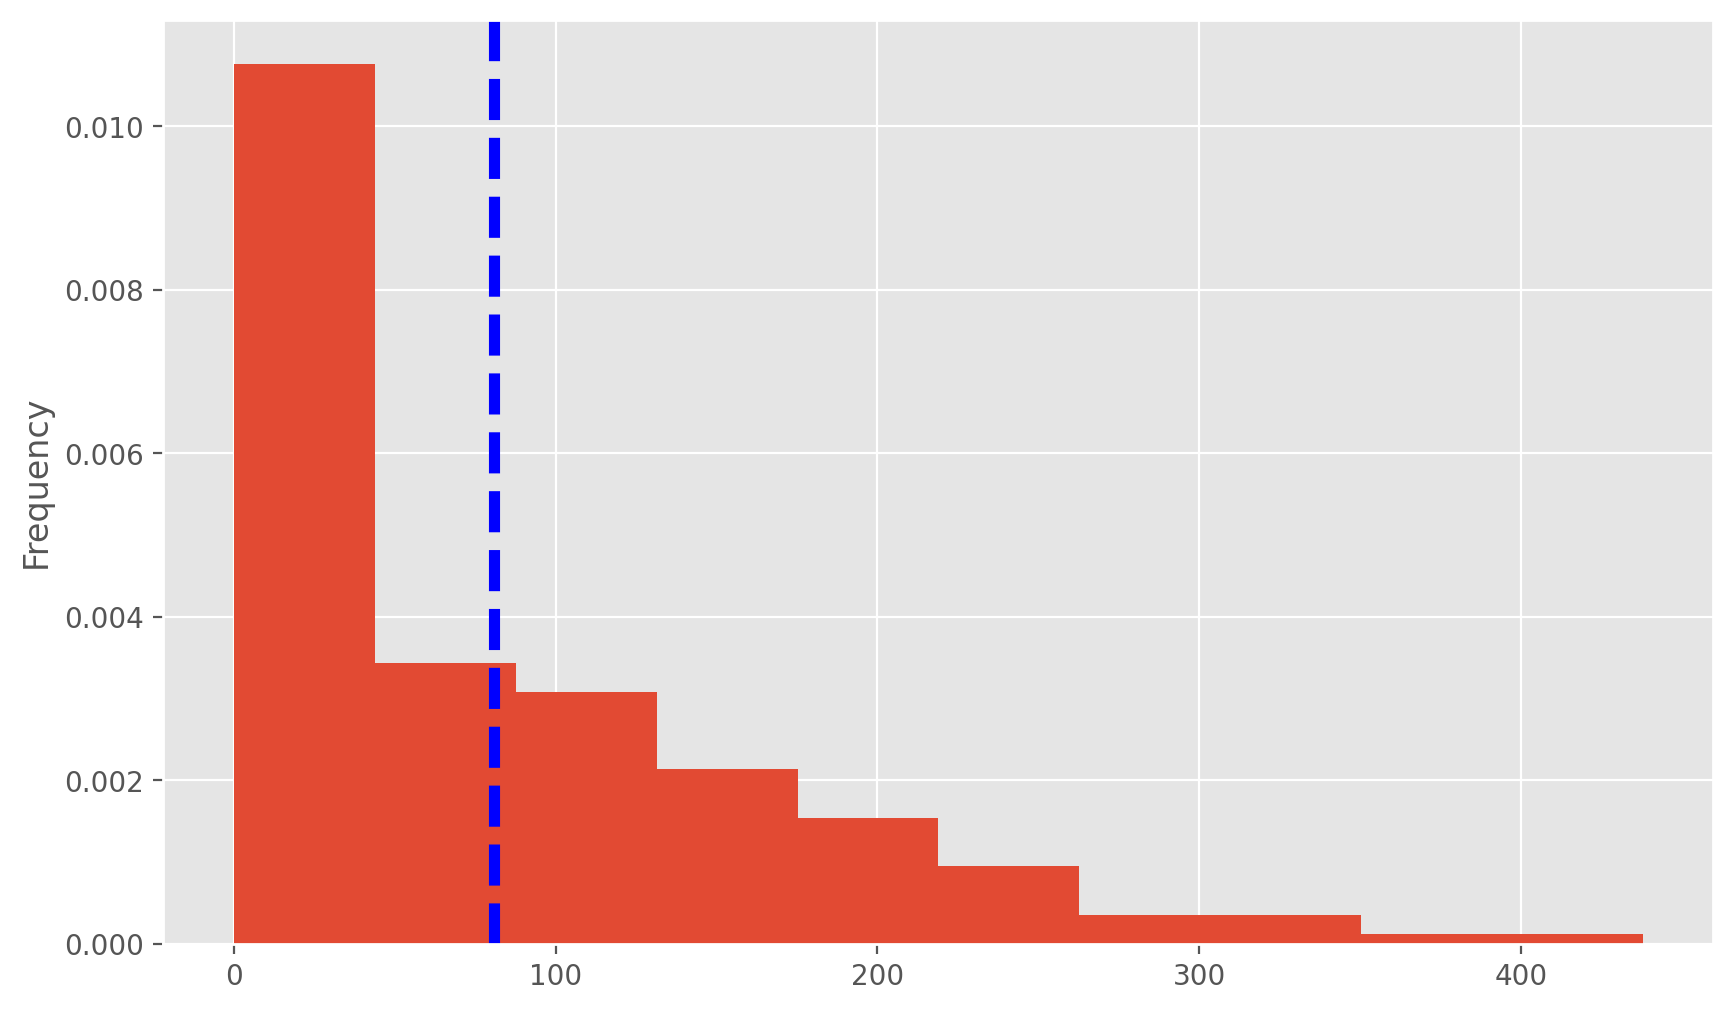

In [64]:
drinks.spirit_servings.plot(kind='hist', density=True,bins=10)
m = drinks.spirit_servings.mean()
plt.axvline(m, color = 'b', linestyle = 'dashed', linewidth = 4);

# Otros detalles de interés


## Efecto sobre la media aritmética de una transformación lineal

Nos disponemos a estudiar cómo se ve afectada la media ante una
transformación lineal que puedan sufrir los datos.

1.  Dada una distribución de frecuencias $\{(x_i;n_i)\}_{i=1,2,...,k}$,
    vamos a considerar una nueva distribución
    $\{(x'_i;n_i)\}_{i=1,2,...,k}$, donde $x'_i= x_i +b$ para todo valor
    de $i$. Se verifica que: $$\overline{x'} =
    \displaystyle{\frac{\displaystyle{\sum_{i=1}^k x'_in_i}}{N}}=
    \displaystyle{\frac{\displaystyle{\sum_{i=1}^k (x_i+b)n_i}}{N}}=
    \displaystyle{\frac{\displaystyle{\sum_{i=1}^k x_in_i}}{N}} +b
    \cdot \displaystyle{\frac{\displaystyle{\sum_{i=1}^k n_i}}{N}}=
    \overline{x}+b$$ Por tanto, si a todos los valores de una variable
    le sumamos una constante $b$, la media aritmética queda también
    aumentada en esa constante. Es decir, **la media aritmética queda
    afectada por los cambios de origen**.

2.  Dada una distribución de frecuencias $\{(x_i;n_i)\}_{i=1,2,...,k}$,
    vamos a considerar una nueva distribución
    $\{(x'_i;n_i)\}_{i=1,2,...,k}$, donde $x'_i= ax_i$ para todo valor
    de $i$. Se verifica que: $$\overline{x'} =
    \displaystyle{\frac{\displaystyle{\sum_{i=1}^k x'_in_i}}{N}}=
    \displaystyle{\frac{\displaystyle{\sum_{i=1}^k (ax_i)n_i}}{N}}= a
    \cdot \displaystyle{\frac{\displaystyle{\sum_{i=1}^k x_in_i}}{N}}= a
    \cdot \overline{x}$$ Por tanto, si todos los valores de una variable
    los multiplicamos por una constante $a$, la media aritmética queda
    también multiplicada por esa constante. Es decir, **la media
    aritmética queda afectada por los cambios de escala**.

#### Consecuencia

Dada una distribución de frecuencias $\{(x_i;n_i)\}_{i=1,2,...,k}$, si
consideramos una nueva distribución $\; \{(x'_i;n_i)\}_{i=1,2,...,k}$
que sea una transformación lineal de la primera, es decir, $x'_i=ax_i+b$
para todo valor de $i$, entonces se verifica que:
$$\overline{x'}=a\overline{x}+b$$

Si tenemos $$\left. \begin{array}{c}
  \overline{x}=10 \\
  x'_i=3x_i+2
\end{array}\right\} \Rightarrow \overline{x'}=3\overline{x}+2=3 \times 10 +2= 32$$

## Efecto sobre la varianza de una transformación lineal

A continuación estudiemos cómo se ven afectadas la varianza, y la
desviación típica, ante una transformación lineal que puedan sufrir los
datos.

1.  Dada una distribución de frecuencias $\{(x_i;n_i)\}_{i=1,2,...,k}$,
    vamos a considerar una nueva distribución
    $\{(x'_i;n_i)\}_{i=1,2,...,k}$, donde $x'_i= x_i +b$ para todo valor
    de $i$. Se verifica que: $$s'^2 =$$ $$=\displaystyle{\sum_{i=1}^k
    (x'_i-\overline{x'})^2 \cdot \frac{n_i}{N}}=
    \displaystyle{\sum_{i=1}^k [x_i+b-(\overline{x}+b)]^2 \cdot
    \frac{n_i}{N}}= \displaystyle{\sum_{i=1}^k (x_i-\overline{x})^2
    \cdot \frac{n_i}{N}}=s^2$$ Por tanto, si a todos los valores de una
    variable le sumamos una constante $b$, la varianza (y la desviación
    típica) no varían. Es decir, **a la varianza (y a la desviación
    típica) no le afectan los cambios de origen**.

2.  Dada una distribución de frecuencias $\{(x_i;n_i)\}_{i=1,2,...,k}$,
    vamos a considerar una nueva distribución
    $\{(x'_i;n_i)\}_{i=1,2,...,k}$, donde $x'_i= ax_i$ para todo valor
    de $i$. Se verifica que: $$s'^2=$$ $$= \displaystyle{\sum_{i=1}^k
    (x'_i-\overline{x'})^2 \cdot \frac{n_i}{N}}=
    \displaystyle{\sum_{i=1}^k [ax_i-(a \overline{x})]^2 \cdot
    \frac{n_i}{N}}= a^2 \cdot \displaystyle{\sum_{i=1}^k
    (x_i-\overline{x})^2 \cdot \frac{n_i}{N}}=a^2 \cdot s^2$$ Por tanto,
    si todos los valores de una variable los multiplicamos por una
    constante, la varianza queda multiplicada por el cuadrado de la
    constante (y la desviación típica por el valor absoluto de dicha
    constante).

#### Consecuencia

Dada una distribución de frecuencias $\{(x_i;n_i)\}_{i=1,2,...,k}$, si
consideramos una nueva distribución $\{(x'_i;n_i)\}_{i=1,2,...,k}$, que
sea una transformación lineal de la primera, es decir, $x'_i=ax_i+b$
para todo valor de $i$, entonces se verifica que: $$s'^2= a^2\cdot s^2$$ o, alternativamente, $$s'=|a|\cdot s.$$

Si tenemos $$\left. \begin{array}{c}
  s^2=2 \\
  x'_i=3x_i+2
\end{array}\right\} \Rightarrow s'^2=3^2 s^2=9 \times 2= 18$$

## Normalización o tipificación

Desde el punto de vista estadístico, la transformación lineal más
importante es la conocida como tipificación o normalización.

Dada una variable estadística $X$, con media $\overline{x}$ y desviación
típica $s_X$, entonces la tipificación consiste en la transformación:
$$z= \displaystyle{\frac{x-\overline{x}}{s_X}}=
\displaystyle{\frac{1}{s_X}}\cdot x + \displaystyle{\left(
\frac{-\overline{x}}{s_X} \right)}$$

1.  Teniendo en cuenta como afectan a la media y a la varianza las
    transformaciones lineales, se tiene que $\overline{z}=0$ y
    $s_Z^2=1$.

2.  La variable tipificada expresa el número de desviaciones típicas que
    cada observación dista de la media. Así podremos comparar la
    posición relativa de datos de diferentes distribuciones.

# Simulaciones a partir de modelos probabilísticos conocidos

Los modelos probabilísticos nos permiten generar datos de manera aleatoria. El poder generar datos a partir de un modelo probabilístico nos da la ventaja de que podemos recrear la realidad sobre cierta magnitud que queremos medir a partir de datos simulados, sabiendo en todo momento las propiedades de la población ($\mu$, $\sigma$, etc.). 

Por ejemplo, los sueldos medios de hombres y mujeres en cierta empresa se distribuyen según $X_1 \sim \mathcal{N}(7000, 1000)$ y $X_2 \sim \mathcal{N}(7000, 500)$, respectivamente. En este caso __conocemos__ las medias y desviaciones típicas __verdaderas__, pudiendo simular sueldos a partir de sus modelos probabilísticos:

In [65]:
X1 = st.norm(loc=7000, scale=1000)
X2 = st.norm(loc=7000, scale=500)

# Generamos 1000 datos aleatoriamente de dicha distribución.
dataset = pd.DataFrame({'hombres': X1.rvs(500), 'mujeres': X2.rvs(500)})

dataset.describe()

,hombres,mujeres
count,500.000000,500.000000
mean,7062.089649,6997.281384
std,1001.173649,490.280365
min,4022.586295,5681.150102
25%,6385.753398,6647.131850
50%,7044.447537,6999.730697
75%,7710.759902,7350.557205
max,11341.230753,8349.094843


Podemos comparar los datos simulados a partir de los diagramas de caja y bigote:

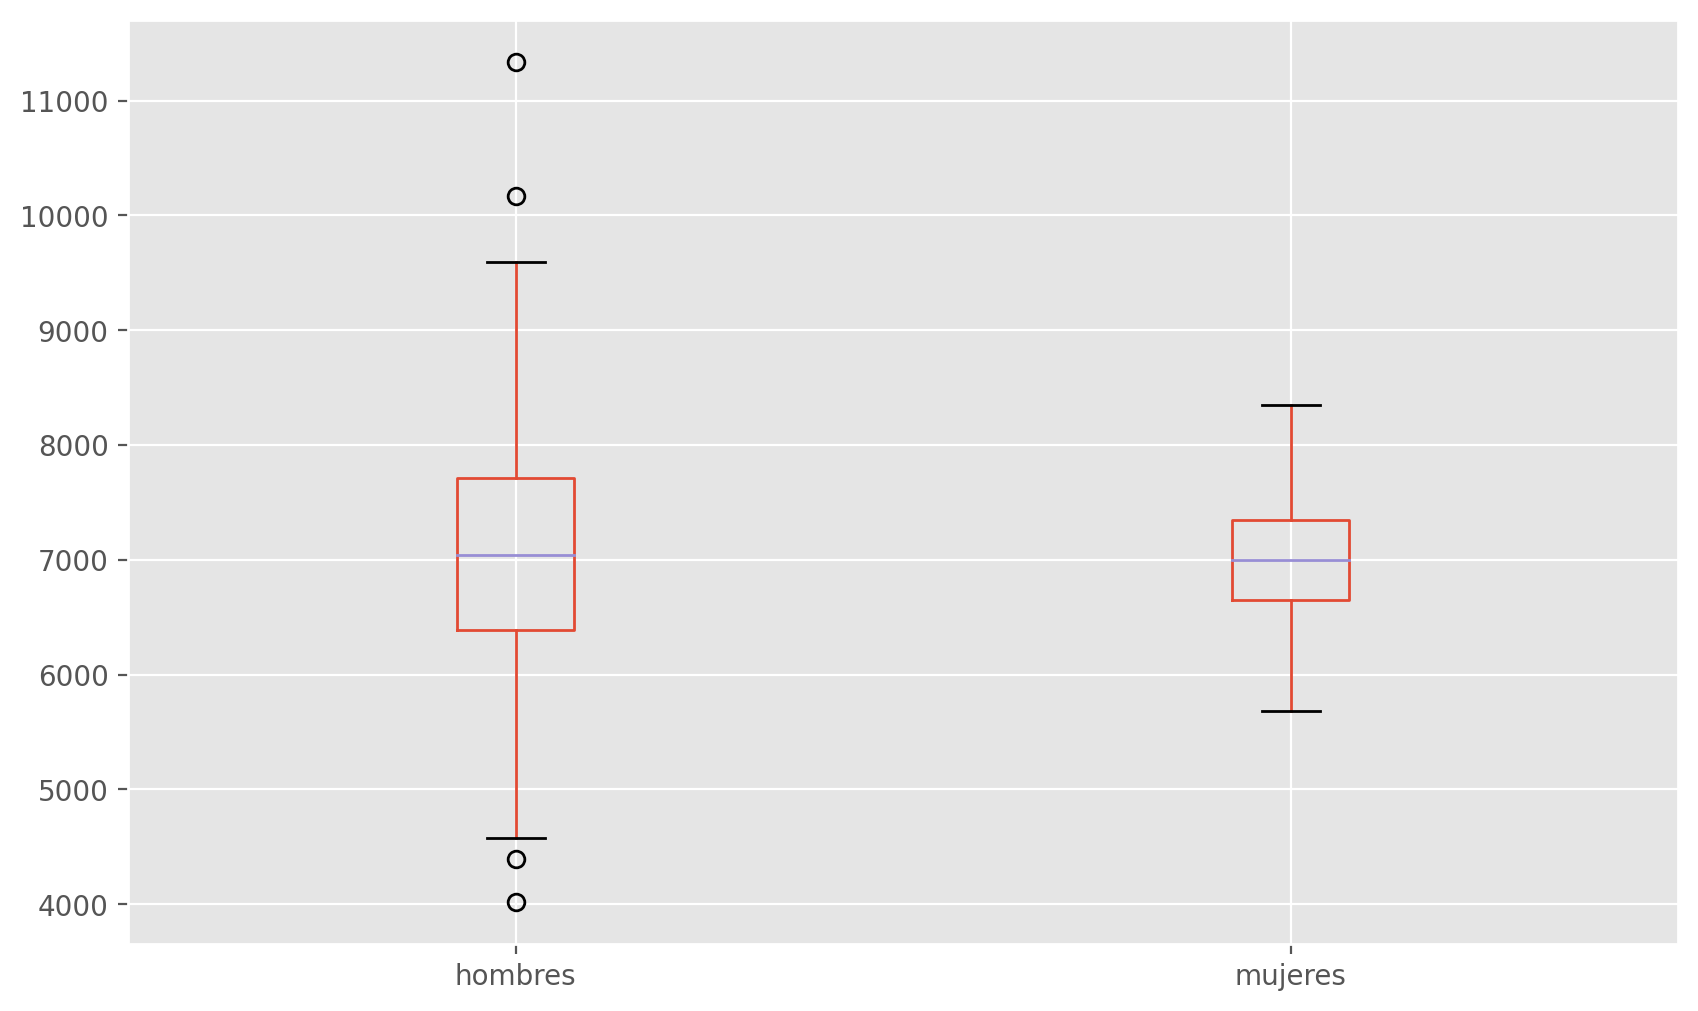

In [66]:
dataset.boxplot();

Si queremos comparar los sueldos mínimos de ambas poblaciones podemos hacerlo en términos absolutos o tipificados:

In [67]:
hombres_min = dataset.hombres.min()
mujeres_min = dataset.mujeres.min()

print('Sueldo mínimo en hombres=', hombres_min, 'Sueldo mínimo en mujeres=', mujeres_min)

Sueldo mínimo en hombres= 4022.58629487196 Sueldo mínimo en mujeres= 5681.150101610135


In [68]:
Z_min_hombres = (dataset.hombres.min() - dataset.hombres.mean())/dataset.hombres.std()
Z_min_mujeres = (dataset.mujeres.min() - dataset.mujeres.mean())/dataset.mujeres.std()

print('Sueldo mínimo en hombres tipificado=', Z_min_hombres, 'Sueldo mínimo en mujeres tipificado=', Z_min_mujeres)

Sueldo mínimo en hombres tipificado= -3.035940225998984 Sueldo mínimo en mujeres tipificado= -2.6844462396551085


### Ejercicio

Jugar con los modelos probabilísticos anteriores cambiando las medias y desviaciones típicas poblacionales.

# Inferencia estadística (I). Intervalos de confianza

Vamos a responder a preguntas que nos hacemos como investigadores sobre características de la población a partir de una muestra. Las herramientas más utilizadas para responder a este tipo de problemas se llaman: **estimación paramétrica**, **intervalos de confianza** y **contrastes de hipótesis**.

<figure>
    <img src="https://raw.githubusercontent.com/AngelBerihuete/datasets/master/cuadroVariables.png">
</figure> 



## Estimación paramétrica

* __Estadístico__: Cualquier función de los valores muestrales que puede utilizarse para múltiples objetivos: estimar parámetros, para ayudarnos a decidir ante las posibles respuestas a una pregunta o hipótesis sobre la población...

* __Estimador__: función de los valores muestrales (es decir, estadístico) obtenido para dar una aproximación del parámetro correspondiente de la población de la que se tomó la muestra. Es decir, es un estadístico especial que está ligado a un parámetro del modelo porque pretende ser una estimación.

> __El valor de un estimador depende de la muestra__

### Distribución en el muestreo de un estadístico:

Los estadísticos y estimadores son variables aleatorias que tendrán una distribución de probabilidad con una media y una desviación típica.

> Ejemplo:
Si llamamos $X$ a la variable aleatoria cuyos valores resultan de obtener
las medias de muestras del mismo tamaño $(n)$, $\overline{X}$ será una variable
aleatoria y, por tanto, tendrá una media y una varianza (y desv. típica):

$$\mu_{\overline{X}}, \quad \sigma_{\overline{X}}$$ 

Y si fuera posible saber cómo se distribuye (con qué modelo), podríamos
calcular probabilidades de que X se encuentre en el intervalo que nos interese.

* Nuestra muestra nos proporciona uno de los posibles valores del estimador o estadístico. 
* Cuando el valor esperado de los posibles valores coincide con el parámetro que quiere estimarse, se dice que el estimador es __insesgado__: 

$$ E(\overline{X}) = \mu, \quad E(S^2) = \frac{n-1}{n} \sigma^2, \quad E(S_c^2) = \sigma^2 $$

*  Para medir cuánto de fiable es el valor de la estimación de nuestra muestra, se tiene el error estándar del estimador, que trata de captar la variabilidad que tienen los valores del estimador en todas las posibles muestras de un tamaño determinado.

$$ Var(\overline{X}) = \frac{\sigma^2}{n}, \quad Var(p) = \frac{p(1-p)}{n} $$


# Teorema Central del límite

Si $x_1, x_2, x_3, \dots, x_n$ es una muestra aleatoria procedente de una población cualquiera con media $\mu$ y desviación típica $\sigma$, puede deducirse que cuando n crece, $\overline{x}$ tiene una distribución 

$$\overline{X} \sim \mathcal{N} \left( \mu, \frac{\sigma}{\sqrt{n}} \right)$$

Y tipificando: 

$$Z = \frac{\overline{X}-\mu}{\sigma / \sqrt{n}} \sim \mathcal{N} (0, 1)$$


__Demostración empírica__. Vamos a generar datos simulados a partir de $X_1, X_2 \dots X_{100}$ tales que $X_i \sim \mathcal{B} (10, 0.31)$:

In [69]:
n = 10
p = 0.31
X = st.binom(n, p)
muestras = X.rvs([500,100])
df = pd.DataFrame(muestras)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,5,2,4,1,2,3,4,3,3,6,...,4,1,5,6,2,1,4,1,0,4
1,5,2,2,5,5,3,4,3,2,4,...,3,3,3,5,3,3,2,4,1,3
2,4,4,4,3,4,3,2,6,2,6,...,5,1,2,2,0,3,3,1,4,6
3,5,3,4,3,1,1,5,1,2,6,...,3,4,2,3,4,3,5,4,4,2
4,5,3,6,5,3,3,6,4,6,2,...,3,5,1,2,0,1,2,3,3,1


Recordemos que la media y la desviación estándar de $X_i$ es

In [70]:
print("media=", X.mean(), "desv. std=", X.std())

media= 3.1 desv. std= 1.4625320509308504


Así pues, según el __Teorema central del límite__, tenemos que 

$$\overline{X} = \frac{X_1+X_2+ \dots X_{100}}{100} \sim \mathcal{N} \left( \mu, \frac{\sigma}{\sqrt{100}} \right)$$

siendo $\mu$ y $\sigma$ la media y la desviación típica de la Binomial:

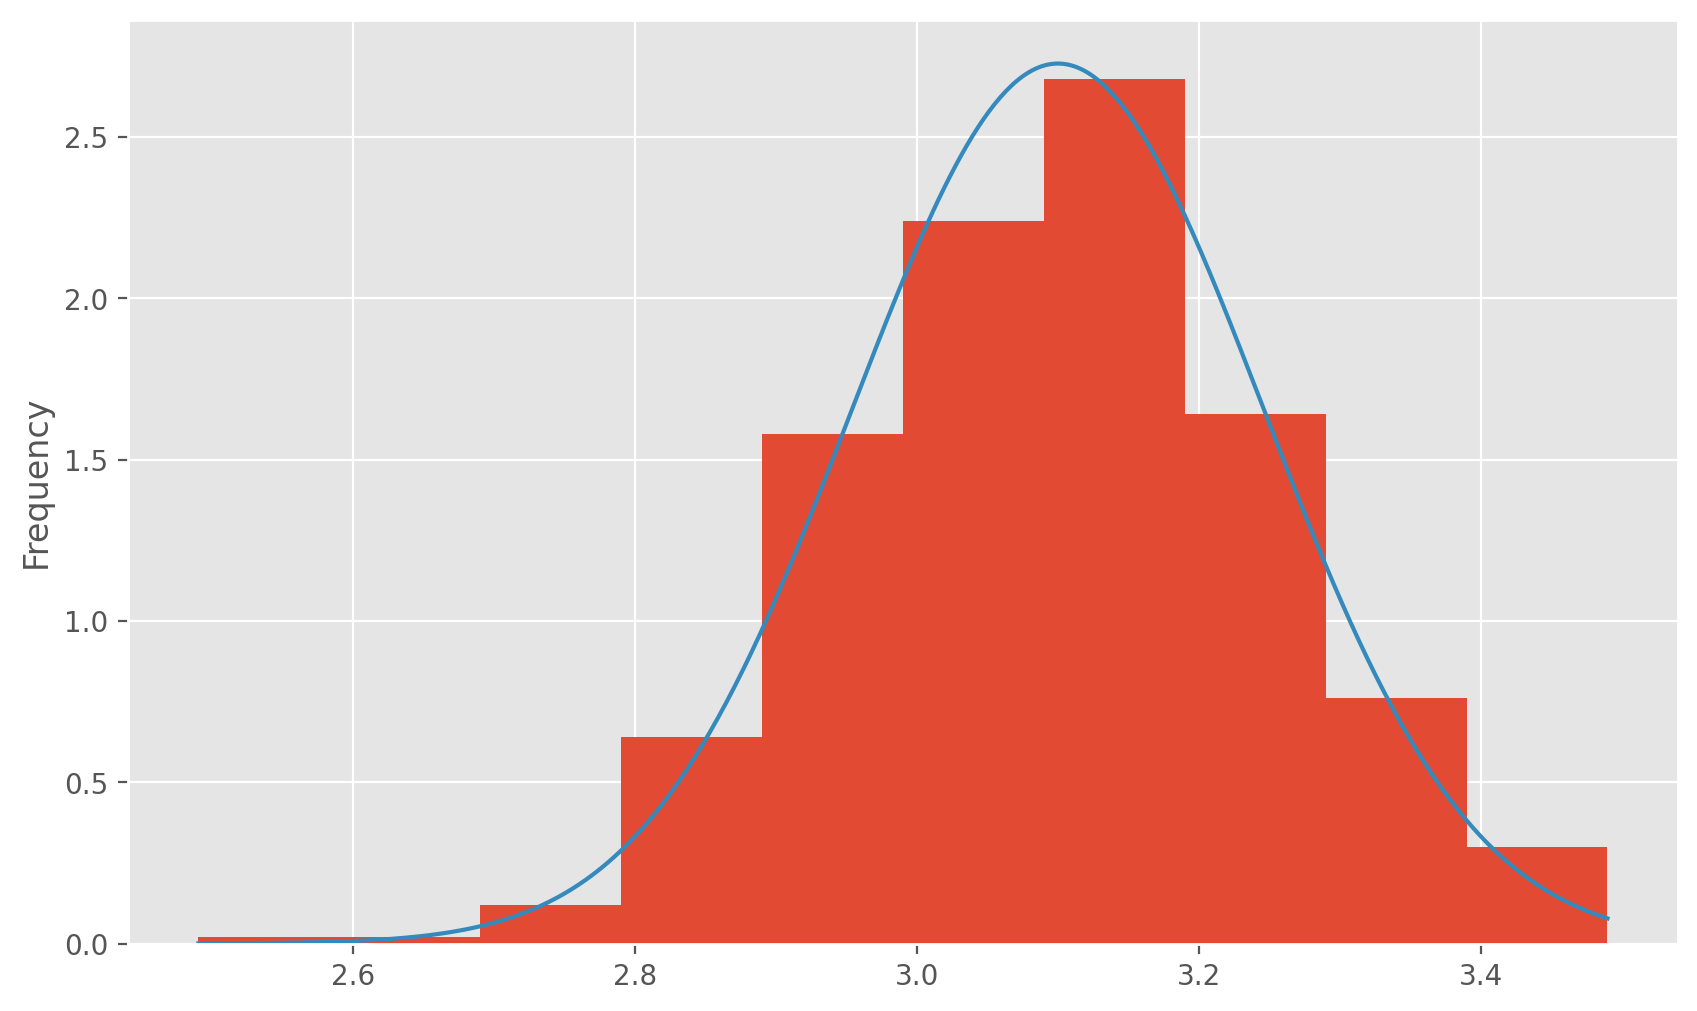

In [71]:
# Muestras (parte izquierda de la ecuación)
ax = df.T.mean().plot(kind='hist', density=True);  
# Hay que trasponer para que haga la media por filas

# Modelo teórico (parte derecha de la ecuación)
x = np.linspace(df.T.mean().min() ,df.T.mean().max(),500)
y = st.norm(loc=X.mean(), scale=X.std()/np.sqrt(100)).pdf(x)
ax.plot(x,y);

## Propiedad

En el caso de que la muestra aleatoria $X_1, X_2, \dots X_n$ provenga de una distribución $N(\mu, \sigma)$ y siendo


$$ \overline{X} = \frac{\sum_{i=1}^n X_i }{n} \quad S^2 = \frac{\sum_{i=1}^n (X_i - \mu)^2}{n-1}$$

entonces se verifica

$$Z=\frac{\overline{X}-\mu}{\sigma/\sqrt{n}} \sim N(0,1), \quad T=\frac{\overline{X}-\mu}{S/\sqrt{n}} \sim t(n-1),
\quad X^2 = \frac{(n-1) S^2}{\sigma^2} \sim \chi^2(n-1)$$

__Ejemplo__ Vamos a generar $X_1, X_2, \dots , X_{100}$ tales que $X_i \sim \mathcal{N} (12, 10)$, entonces

$$\overline{X} = \frac{X_1 + X_2 + \dots + X_{100}}{100} \sim \mathcal{N} \left( 12, \frac{10}{\sqrt{100}} \right)$$

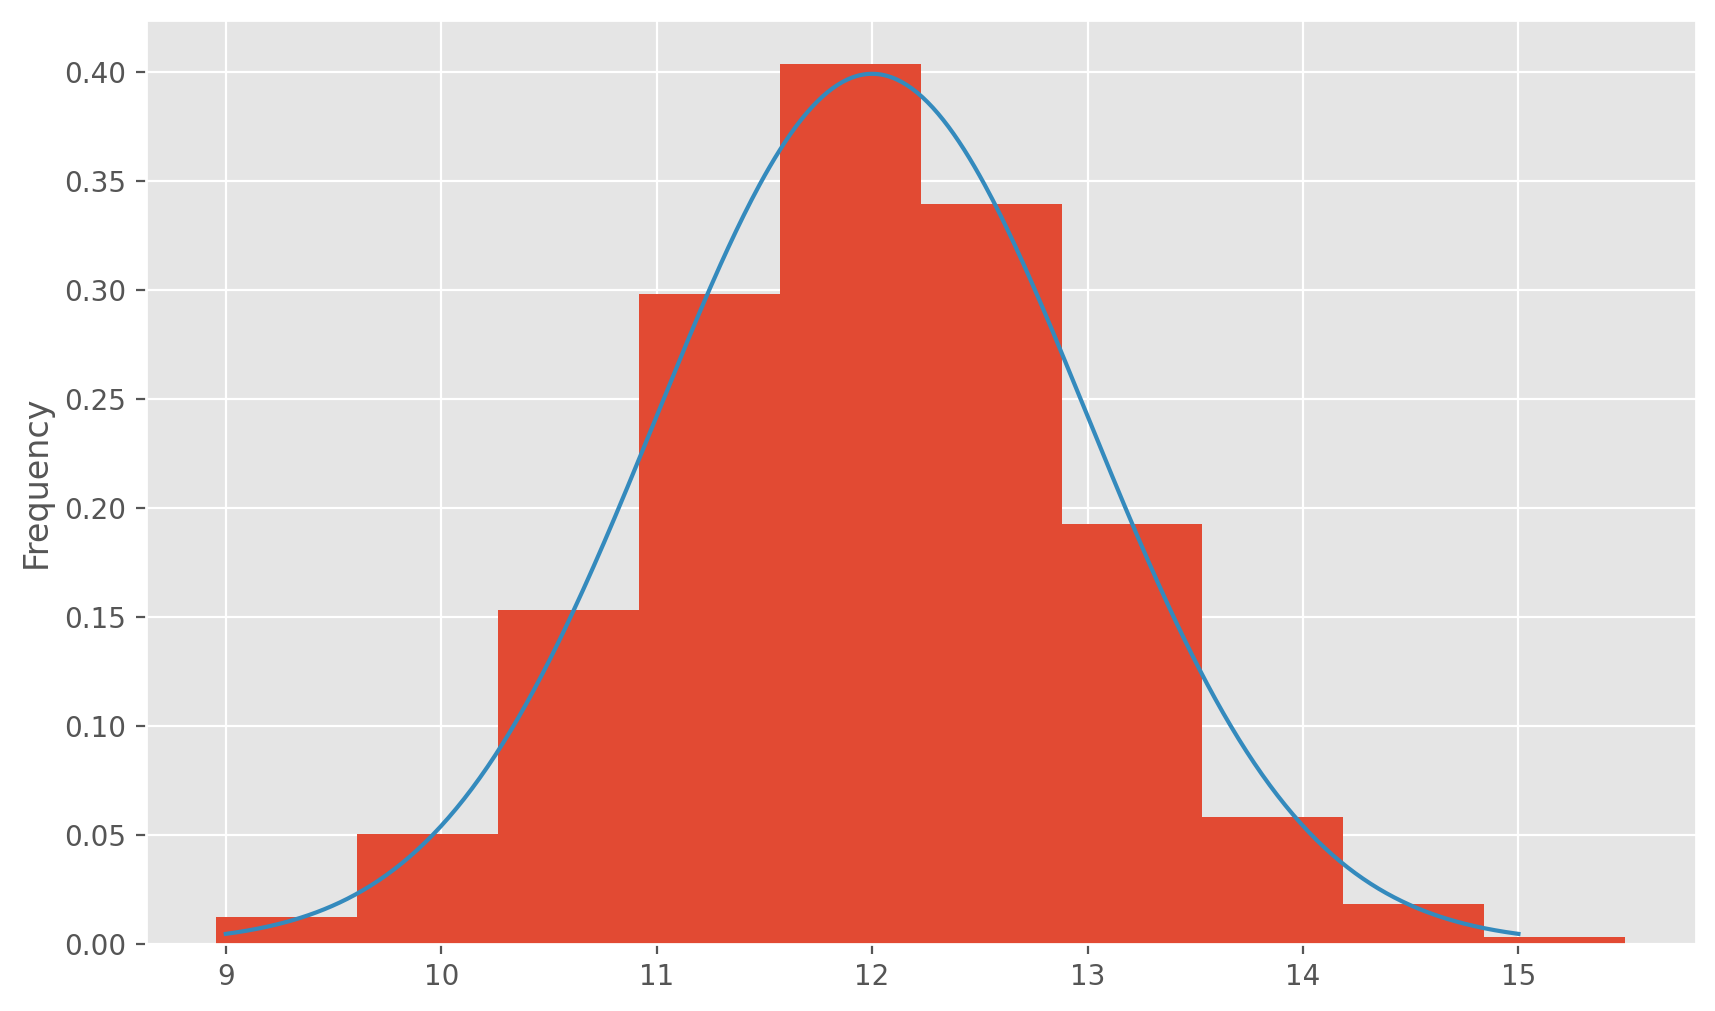

In [72]:
X = st.norm(loc=12.0, scale=10.0)
samples = pd.DataFrame(X.rvs(size=100000).reshape(1000,100))
ax = samples.T.mean().plot(kind='hist', density = True);  # Hay que trasponer para que haga la media por filas!

Xbarra = st.norm(loc=12.0, scale=10.0/np.sqrt(100.))

x = np.linspace(9 ,15, 500)
y = st.norm(loc=X.mean(), scale=X.std()/np.sqrt(100)).pdf(x)
ax.plot(x,y); 

Del mismo modo, podemos ver cómo son las aproximaciones $Z$, $T$ y $X^2$ definidas anteriormente:

In [73]:
Z=(samples.T.mean()-12)/(10.0/np.sqrt(100.0))
T=(samples.T.mean()-12)/(samples.std()/np.sqrt(100.0))
X2=99.0*samples.T.var()/100.0

Para el caso de $Z \sim \mathcal{N}(0,1)$, una distribución normal estandarizada:

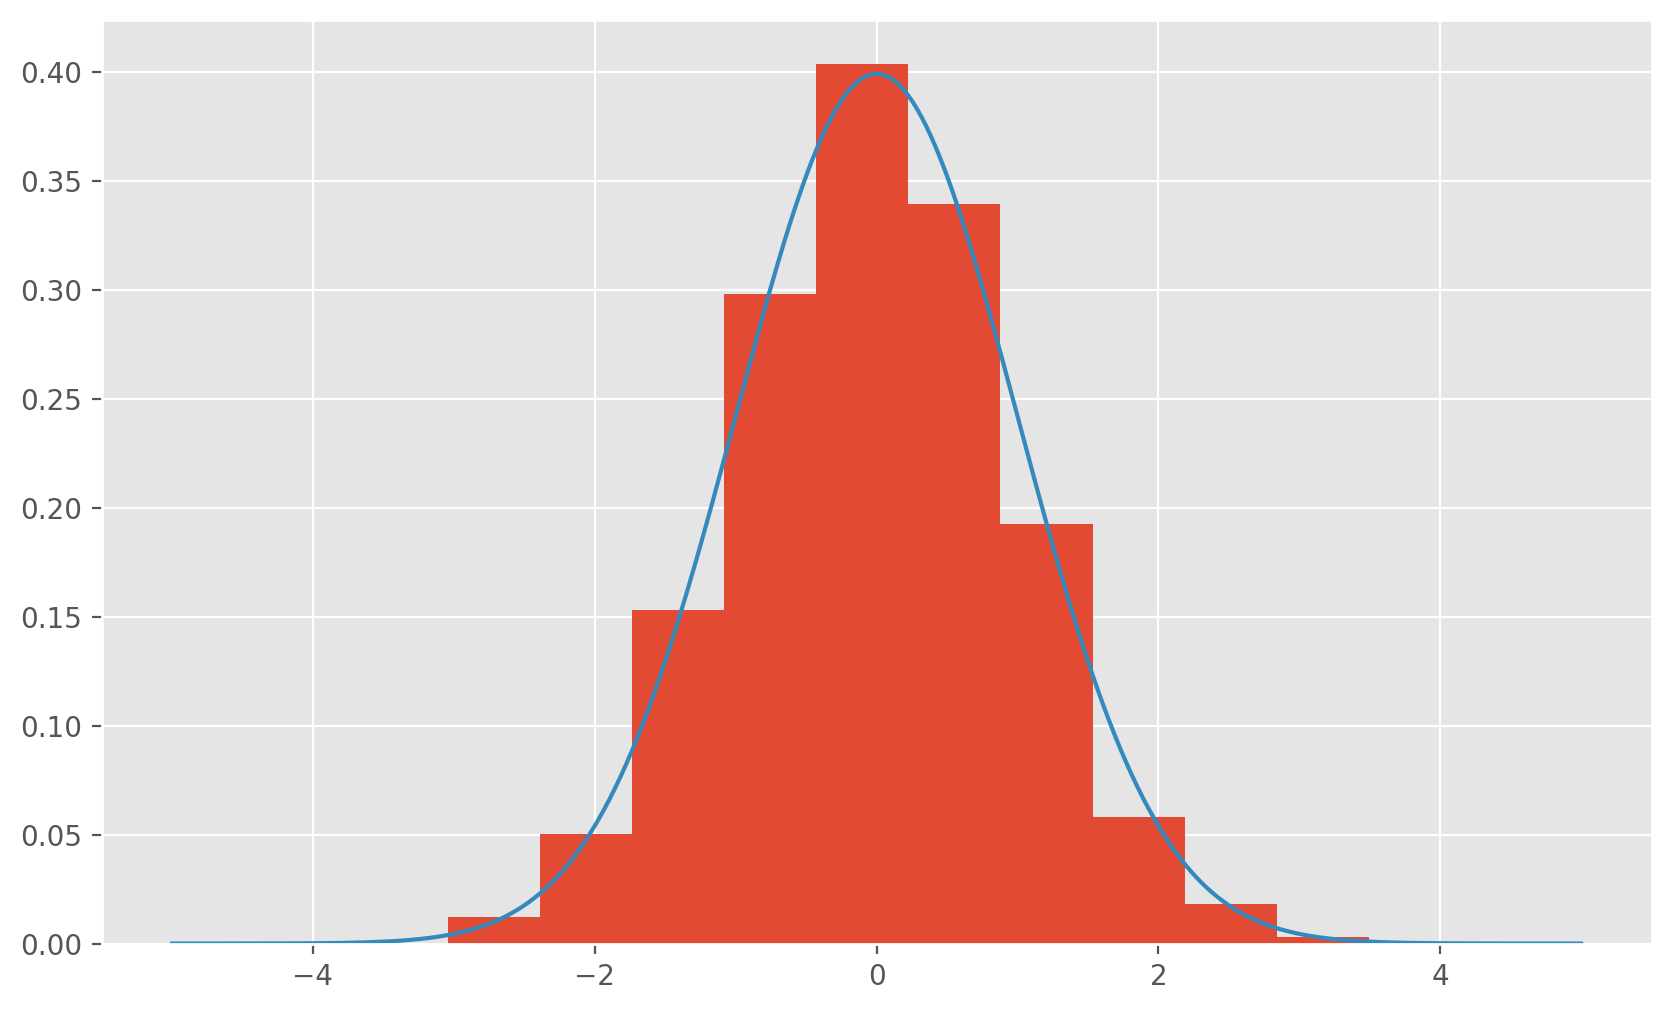

In [74]:
Z.hist(density=True)

x = np.linspace(-5,5,1000)
y = st.norm(loc=0.0, scale=1.0).pdf(x)
plot(x,y);

Para el caso de $T \sim t(n-1)$, una t-Student con $n-1$ grados de libertad:

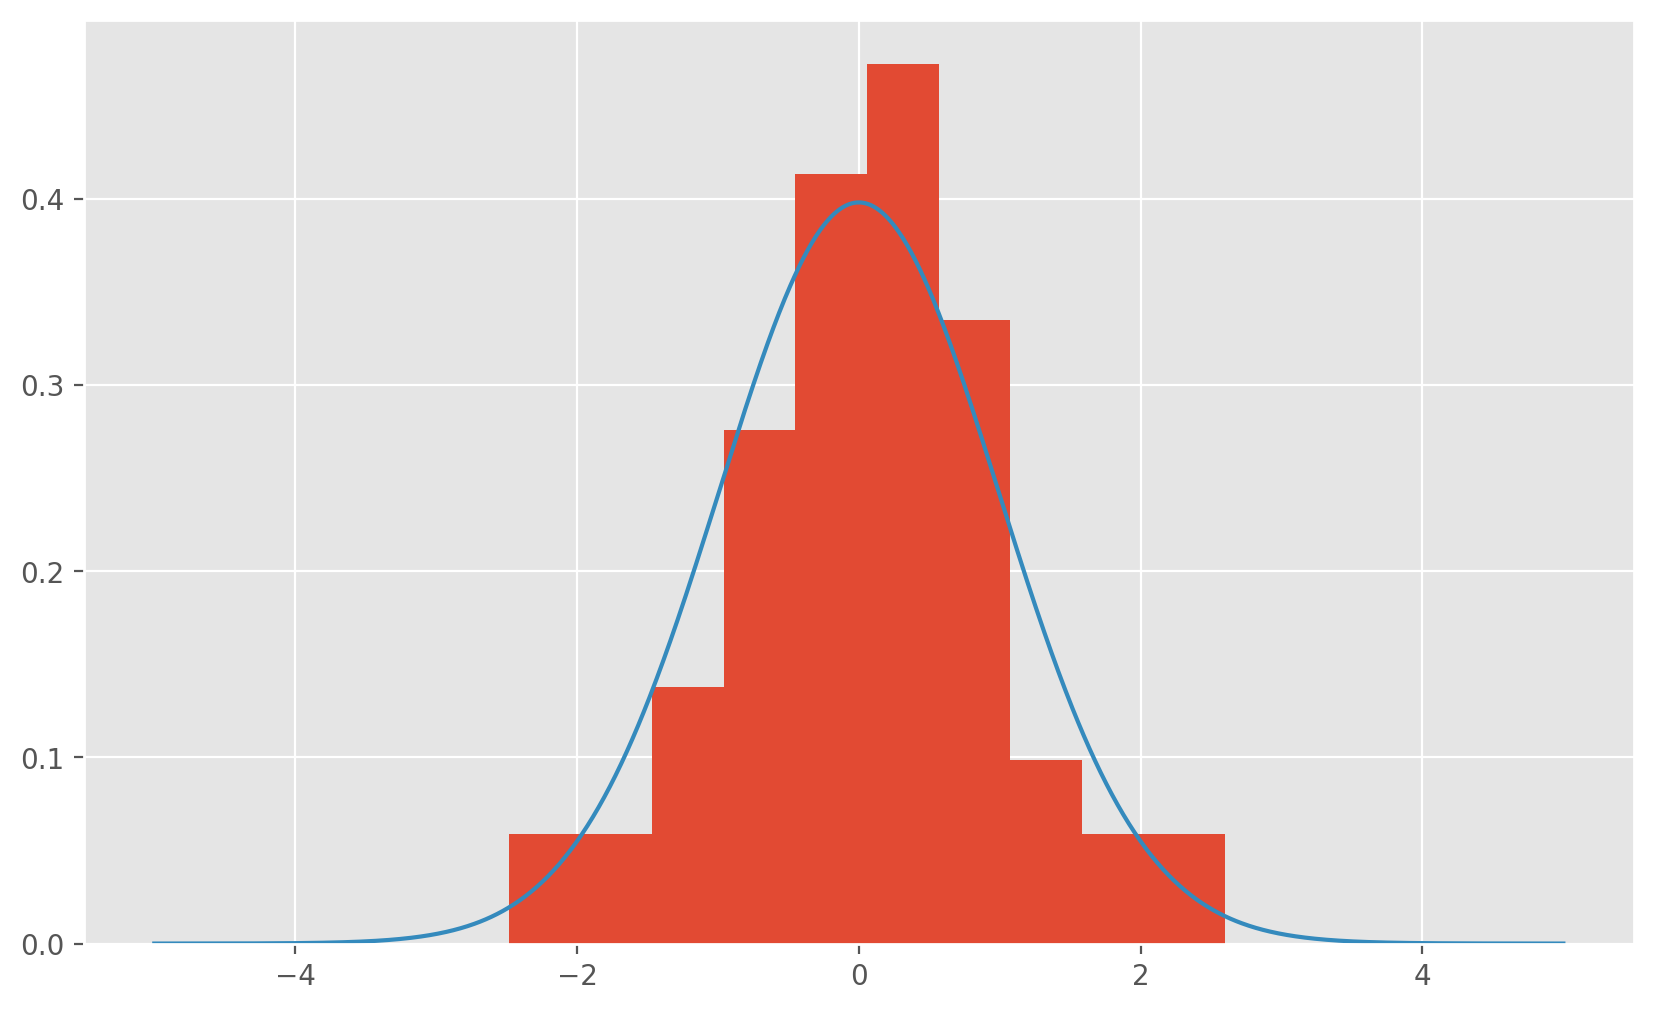

In [75]:
T.hist(density=True)

x = np.linspace(-5,5,1000)
y = st.t(df=99).pdf(x)
plot(x,y);

Para el caso de $X^2 \sim \chi^2(n-1)$, una chi-cuadrado con $n-1$ grados de libertad:

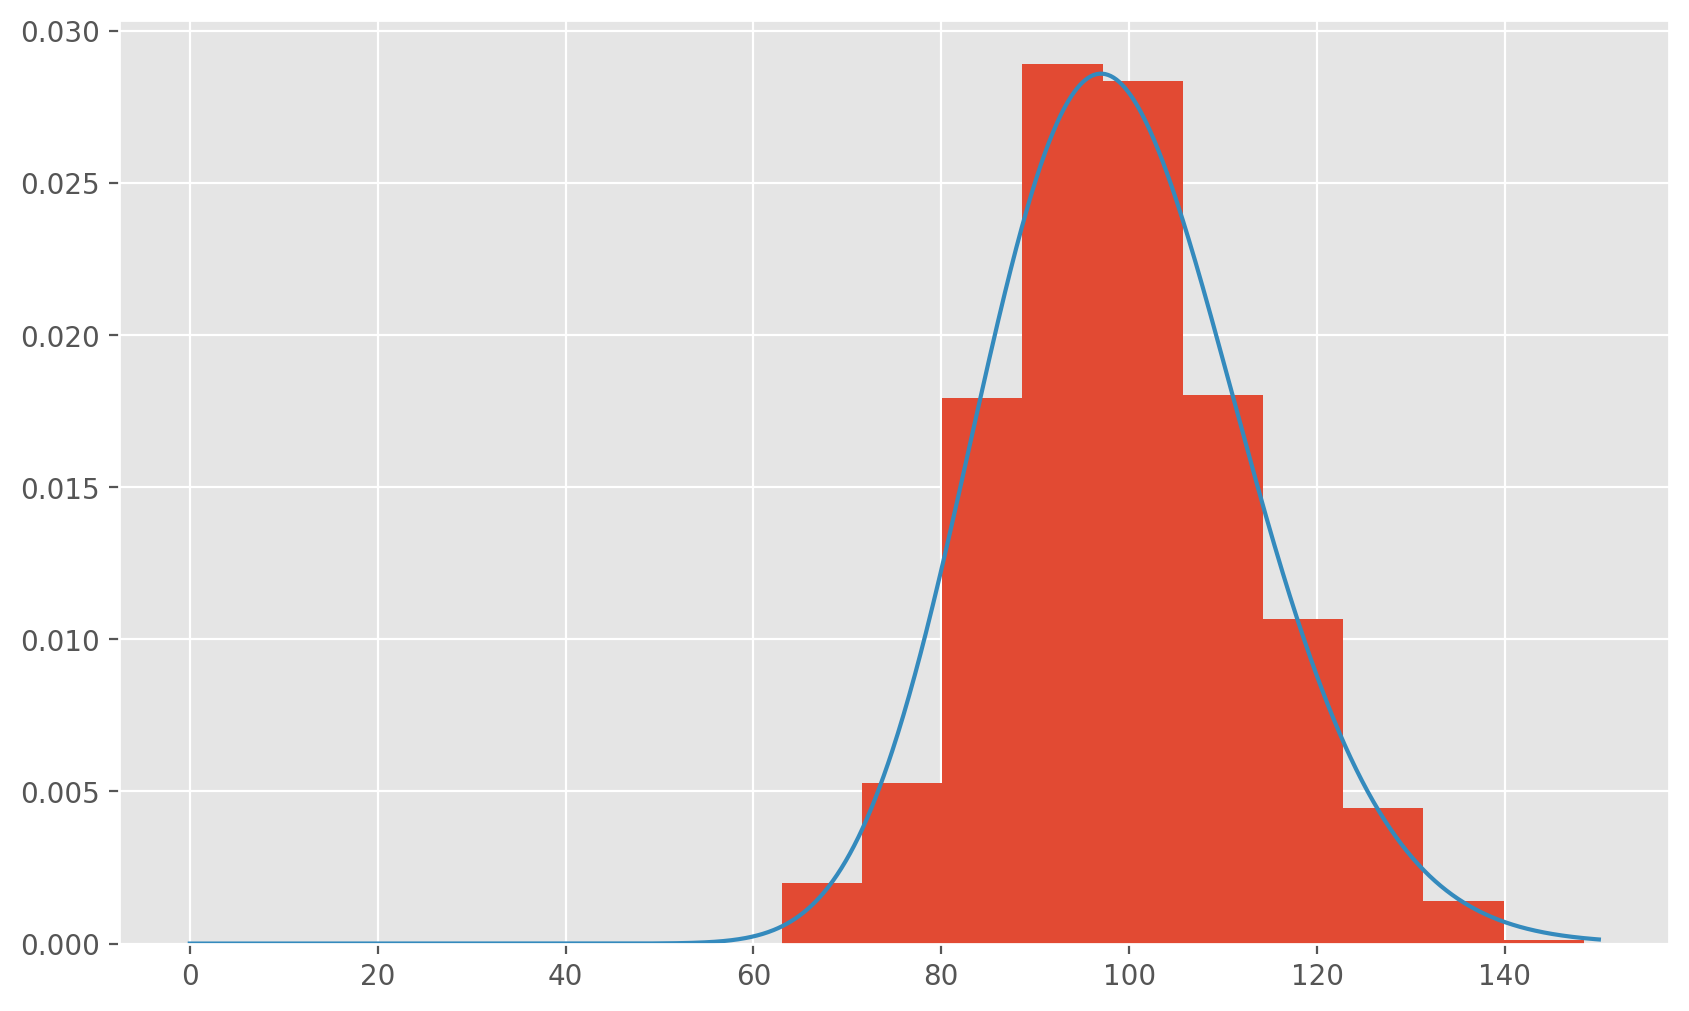

In [76]:
X2.hist(density=True)

x = np.linspace(0,150,1000)
y = st.chi2(df=99).pdf(x)
plot(x,y);

# Intervalos de confianza (UNA POBLACIÓN)

* Los estimadores proporcionan una estimación puntual de los parámetros de la población, pero no proporcionan ninguna idea de la precisión de tal estimación ni de la probabilidad de que tal estimación sea la correcta.
* Los **intervalos de confianza** son un medio de conocer el valor de un parámetro en una población, midiendo el grado de error debido al azar que lleva implícito el proceso.

#### Definición:

Un intervalo de confianza es un método de estimación que permite estimar un
parámetro poblacional a partir de un intervalo aleatorio $(L_1, L_2)$ del que se tiene
una cierta confianza, medida en probabilidad, de que contiene al verdadero valor
del parámetro poblacional.

Su construcción se basa en obtener los extremos $L_1$ y $L_2$ (estadísticos) a partir de las
distribuciones en el muestreo.


Cargamos la biblioteca que calcula intervalos de confianza:

In [77]:
import statsmodels.stats.api as sms

### Intervalo de confianza para $\mu$ de $N(\mu, \sigma)$ con $\sigma$  CONOCIDA

Si $X_1, X_2, \dots X_n$ es una muestra aleatoria procedente de una
población $N(\mu, \sigma)$ con $\sigma$ __conocida__, hemos visto que 

$$Z=\frac{\overline{X}-\mu}{\sigma/\sqrt{n}} \sim N(0,1)$$

y utilizando el percentil $z_{1- \frac{\alpha}{2}}$ de la $N(0,1)$ se tendrá que:

$$P \left(
-z_{1- \frac{\alpha}{2}} <
\frac{\overline{X}-\mu}{\sigma/\sqrt{n}} <
z_{1- \frac{\alpha}{2}}
\right) = 1-\alpha
$$


1.959963984540054


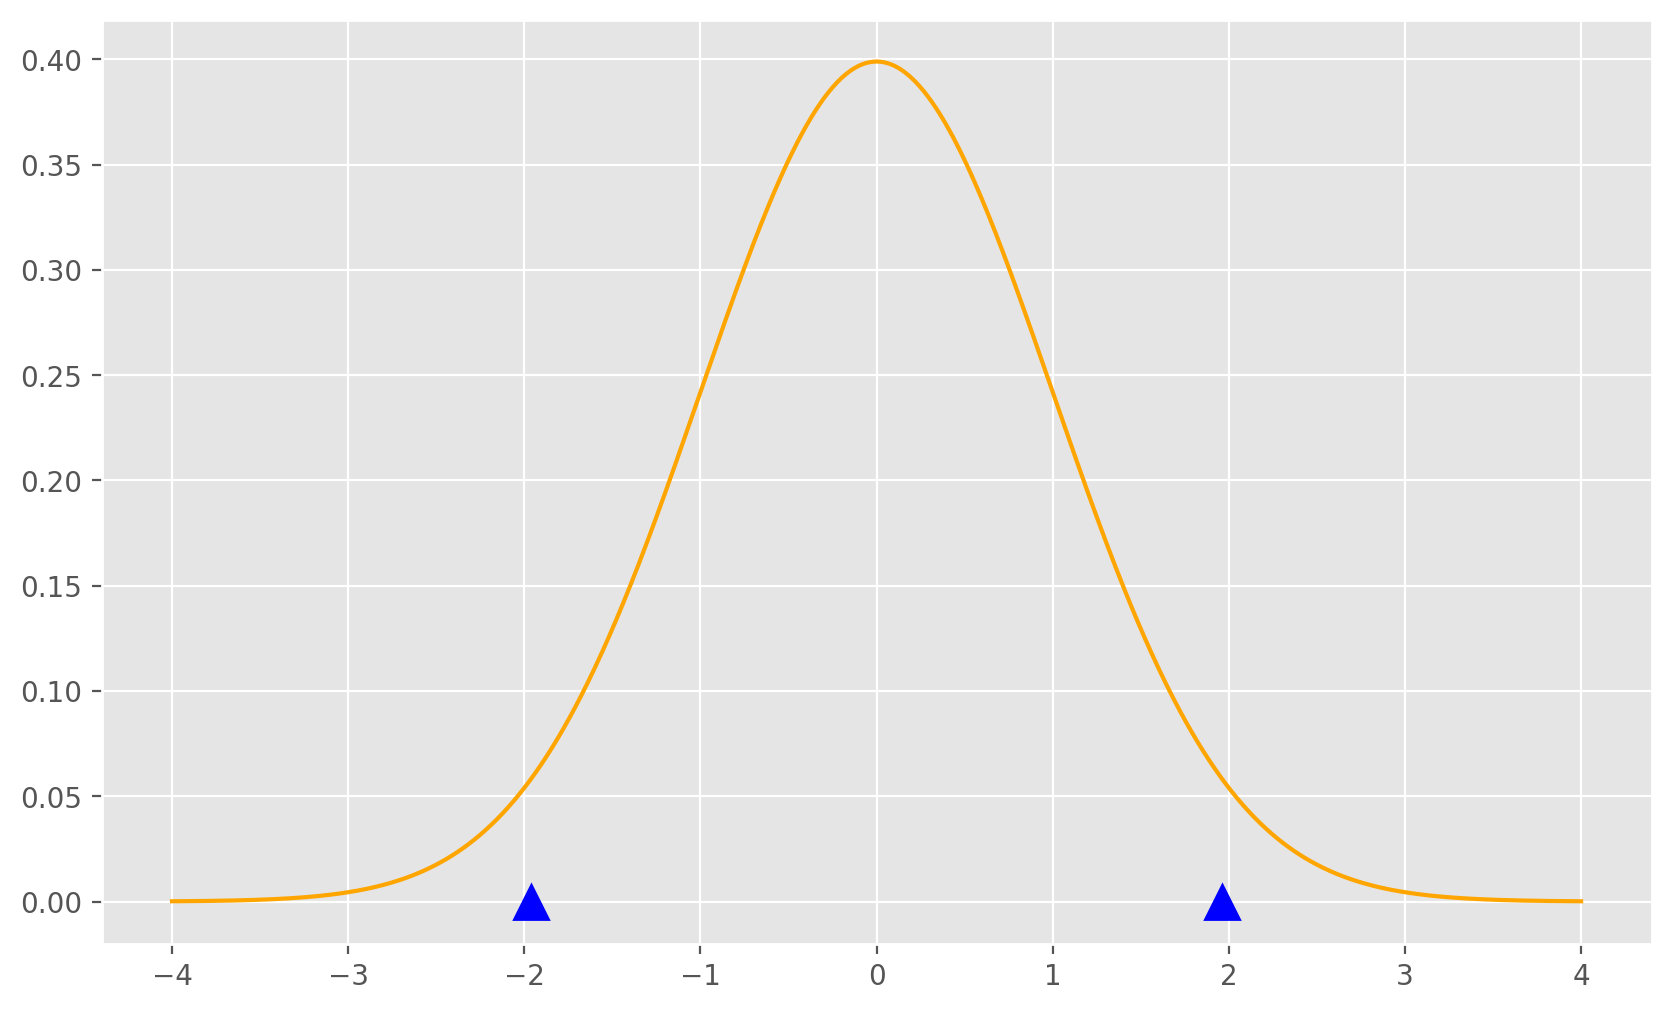

In [78]:
# Pintamos la densidad de la distribución Normal N(0,1)
rv_normal = st.norm(loc=0., scale=1.)
x = np.linspace(-4,4,1000)
y = rv_normal.pdf(x)
fig, ax = plt.subplots(1,1)
ax.plot(x,y,color='orange')

# Pintamos los cuantiles
α=0.05
z_ = rv_normal.ppf(1.-α/2)  # Percent point function (inverse of cdf — percentiles).
print(z_)
ax.plot(z_,0, color='blue', marker='^', markersize=12)
ax.plot(-z_,0, color='blue', marker='^', markersize=12);

De la expresión anterior se deduce que: 

$$ P \left(
\overline{X}-z_{1- \frac{\alpha}{2}} \cdot \frac{\sigma}{\sqrt{n}} <
\mu <
\overline{X}+z_{1- \frac{\alpha}{2}} \cdot \frac{\sigma}{\sqrt{n}} \right) = 1 - \alpha
$$

indicando que hay una probabilidad de $(1-\alpha)$ de que el verdadero valor de la media $\mu$ de la población se encuentre entre las cantidades 

$$L_1=\overline{X}-z_{1- \frac{\alpha}{2}} \cdot \frac{\sigma}{\sqrt{n}} \quad \mbox{ y } \quad L_2 = \overline{X}+z_{1- \frac{\alpha}{2}} \cdot \frac{\sigma}{\sqrt{n}}
$$

Por tanto, el intervalo al $100\cdot (1 - \alpha) \%$ de confianza para $\mu$ cuando **SE CONOCE** $\sigma$ es

$$ IC_{100\cdot(1-\alpha) \%} (\mu) = \left(
\overline{x}-z_{1- \frac{\alpha}{2}} \cdot \frac{\sigma}{\sqrt{n}},
\overline{x}+z_{1- \frac{\alpha}{2}} \cdot \frac{\sigma}{\sqrt{n}}
\right) =  \overline{x} \pm z_{1- \frac{\alpha}{2}} \cdot \frac{\sigma}{\sqrt{n}} $$

In [79]:
# SIGMA CONOCIDA
# --------------

def mean_confidence_interval(data, scale=1.0, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m = np.mean(a)
    h = st.norm.ppf(1.0 - (1.0 - confidence)/2.)*(scale / np.sqrt(n))
    return print(m, "+/-", h)
    
a = st.norm(loc=12.0, scale=10.0).rvs(20)
mean_confidence_interval(a, scale=10.0) # X = st.norm(loc=12.0, scale=10.0)

12.373697885907252 +/- 4.382612702882908


In [80]:
sms.zconfint(a)

(8.1541631383019, 16.593232633512603)

No coincide. ¿Por qué?

Pensad en el argumento que le hemos pasado a la función zconfint... ¿Conoce la función zconfint el valor verdadero de la varianza?¿Qué valor habrá utilizado entonces?

### Intervalo de confianza para $\mu$ de $N(\mu, \sigma)$ con $\sigma$  DESCONOCIDA

Si $X_1, X_2, \dots X_n$ es una muestra aleatoria procedente de una
población $N(\mu, \sigma)$ con $\sigma$ __desconocida__, hemos visto que

$$ T=\frac{\overline{X}-\mu}{s/\sqrt{n}} \sim t(n-1) $$

Entonces

$$ IC_{100\cdot(1-\alpha) \%} (\mu)  = \left(\overline{x}-t(n-1)_{1- \frac{\alpha}{2}} \cdot \frac{s}{\sqrt{n}}, \overline{x}+t(n-1)_{1- \frac{\alpha}{2}} \cdot \frac{s}{\sqrt{n}} \right) =  \overline{x} \pm t(n-1)_{1- \frac{\alpha}{2}} \cdot \frac{s}{\sqrt{n}} $$

Por ejemplo, para los datos anteriores, podemos utilizar dos bibliotecas diferentes. Con la biblioteca __statmodels__:

In [81]:
# SIGMA CONOCIDA
# --------------

def mean_confidence_interval2(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m = np.mean(a)
    scale = np.std(a)
    h = st.t(n-1).ppf(1.0 - (1.0 - confidence)/2.)*(scale / np.sqrt(n))
    return print(m, "+/-", h)

mean_confidence_interval2(a)

12.373697885907252 +/- 4.3919005642020394


In [82]:
print((sms.DescrStatsW(a).tconfint_mean(alpha=0.05)[1]-
sms.DescrStatsW(a).tconfint_mean(alpha=0.05)[0])/2)

4.505994903381866


Con la biblioteca __scipy.stats__

In [83]:
grados_de_libertad = len(a)-1.0
media_muestral = a.mean()

error_estandar_de_la_media = st.sem(a)
#print(st.sem(a))
#print(np.std(a)/np.sqrt(19))
#print(np.std(a)/np.sqrt(20))
#error_estandar_de_la_media = np.std(a)/np.sqrt(20)

itvl = st.t.interval(0.95, df=grados_de_libertad, #alpha is a poor name for the parameter, thus omitted
                     loc=media_muestral, 
                     scale=error_estandar_de_la_media)
print(itvl)
print((itvl[1]-itvl[0])/2)

(7.867702982525384, 16.87969278928912)
4.505994903381868


La diferencia respecto de nuestra implementación de arriba es que definen el parámetros de escala como $\frac{\sigma}{\sqrt{n-1}}$

### Intervalo de confianza para $\sigma^2$ de $N(\mu, \sigma)$

Si $X_1, X_2, \dots X_n$ es una muestra aleatoria procedente de una
población $N(\mu, \sigma)$, hemos visto que

$$ X^2 = \frac{(n-1) S^2}{\sigma^2} \sim \chi^2(n-1) $$

Entonces

$$ IC_{100\cdot(1-\alpha) \%} (\sigma^2) = \left(
\frac{(n-1) \cdot s^2}{\chi^2_{1-\frac{\alpha}{2}}(n-1)},
\frac{(n-1) \cdot s^2}{\chi^2_{\frac{\alpha}{2}}(n-1)}
\right) $$


In [84]:
a.var() # X = st.norm(loc=12.0, scale=10.0)

88.06159639571625

In [85]:
(a.size-1.0)*a.var()/st.chi2.ppf(1.-0.05/2., a.size-1.0)


50.93004031527876

In [86]:
(a.size-1.0)*a.var()/st.chi2.ppf(0.05/2., a.size-1.0)

187.85911808531793

In [87]:
def var_confidence(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    s2 = a.var()
    c1 = st.chi2.ppf((1. -0.05/2.), a.size-1.0)
    c2 = st.chi2.ppf(0.05/2., a.size-1.0)
    linf = (n-1)*s2/c1
    lsup = (n-1)*s2/c2
    return print(linf, lsup)

var_confidence(a)

50.93004031527876 187.85911808531793


### Intervalo de confianza para una proporción aproximado por la normal

Si $X_1, X_2, \dots , X_n$ es una muestra aleatoria procedente de una población donde los individuos pueden presentar o no una característica con probabilidad $\pi$ (proporción poblacional), y $X$ es el número de los que la presentan entre los $n$ elegidos, entonces si llamamos $p = X/n$ (proporción muestral) se cumple que 


$$X \sim N \left( n\pi, \sqrt{n \pi (1-\pi)} \right), \quad \mbox{es decir} \quad
p = \frac{X}{n} \sim N \left( \pi, \sqrt{\pi (1- \pi) / n} \right) $$

__siempre que__ $n \cdot p > 5$, $p > 0.05$, $n \cdot (1-p) > 5$ y $(1-p) > 0.05$

El resultado anterior obtenido en el muestreo, nos permite construir un intervalo de confianza para la proporción poblacional $\pi$, dado por

$$ IC_{100\cdot(1-\alpha) \%} (\pi)  = \left(
p-z_{1- \frac{\alpha}{2}} \cdot \sqrt{\frac{p(1-p)}{n}} - \frac{1}{2n}, p+z_{1- \frac{\alpha}{2}} \cdot \sqrt{\frac{p(1-p)}{n}} + \frac{1}{2n}
\right) $$


#### [Ejemplo]

En el caso de querer estimar mediante un IC al 90% de la proporción de
fumadores en una población, a partir de una muestra de 80 individuos,
de los cuales 37 fumaban, se tendrá:

In [88]:
37/80-st.norm.ppf(1-0.1/2)*np.sqrt((37/80)*(1-37/80)/80) - 1/(2.*80)

0.3645588613168146

In [89]:
37/80

0.4625

In [90]:
37/80+st.norm.ppf(1-0.1/2)*np.sqrt((37/80)*(1-37/80)/80) + 1/(2.*80)

0.5604411386831855

__[Ejercicio]__ Crear una función que calcule el intervalo de confianza para una proporción poblacional.  

# Intervalos de confianza (DOS POBLACIONES)

### Intervalo de confianza para $\mu_1 -\mu_2$:

Sean $X \sim N(\mu_1,\sigma_1)$, $Y \sim N(\mu_2,\sigma_2)$ __INDEPENDIENTES__:
    
* Conocemos $\sigma^2_1$ y $\sigma^2_2$. Dados los tamaños de las muestras $n$ y $m$:

$$IC_{100\cdot(1-\alpha) \%}(\mu_1 -\mu_2)= (\overline{x}- \overline{y}) \mp z_{1- \frac{\alpha }{2}} \cdot \sqrt{\frac{\sigma^2_1}{n}+\dfrac{\sigma^2_2}{m}}$$
    
* Desconocemos $\sigma^2_1$ y $\sigma^2_2$, pero es verosímil que $\sigma^2_1= \sigma^2_2$:
    
$$IC_{100\cdot(1-\alpha) \%}(\mu_1 -\mu_2)= (\overline{x}- \overline{y}) \mp t(n+m-2)_{1- \frac{\alpha }{2}} \cdot \sqrt{\dfrac{(n-1) s_1^2 + (m-1) s_2^2}{n+m-2}} \cdot \sqrt{\frac{1}{n}+\dfrac{1}{m}}$$

* Desconocemos $\sigma^2_1$ y $\sigma^2_2$, pero es verosímil que $\sigma^2_1 \neq \sigma^2_2$:

$$IC_{100\cdot(1-\alpha) \%}(\mu_1 -\mu_2)= (\overline{x}- \overline{y}) \mp t(n+m-2-g)_{1- \frac{\alpha }{2}} \cdot \sqrt{\dfrac{s_1^2}{n}+\dfrac{s_2^2}{m}}$$
            siendo $g= \dfrac{[(m-1)T_1-(n-1)T_2]^2}{(m-1)T_1^2+(n-1)T_2^2}$, $T_1= \dfrac{s_1^2}{n}$ y $T_2= \dfrac{s_2^2}{m}$


In [91]:

def diffmean_confidence_interval(data1,data2,confidence=0.95):
#    a = 1.0 * np.array(data)
    n = len(data1)
    m = len(data2)
    xbar = np.mean(data1)
    ybar = np.mean(data2)
    scale1 = np.var(data1)
    scale2 = np.var(data2)
    T1 = scale1/n
    T2 = scale2/m
    g = ((m-1)*T1-(n-1)*T2)**2/((m-1)*T1**2+(n-1)*T2**2)
    degfree = round(m+n-2-g)
    alpha = (1-confidence)
    h = st.t(df=degfree).ppf(1.0 - (alpha/2.))*np.sqrt(T1+T2)
    return print(xbar-ybar, "+/-", h)


## Ejercicio con simulaciones

Propuesta: intentad calcular el intervalo de confianza para la diferencia de las medias las simulaciones que hicimos más arriba en este mismo notebook para la muestra de salarios de hombres y mujeres.


In [92]:
X1 = st.norm(loc=7000, scale=1000)
X2 = st.norm(loc=7000, scale=2000)

# Generamos 1000 datos aleatoriamente de dicha distribución.
dataset = pd.DataFrame({'hombres': X1.rvs(500), 'mujeres': X2.rvs(500)})

dataset.describe()

,hombres,mujeres
count,500.000000,500.000000
mean,6956.824975,7007.196181
std,1002.630362,1993.273144
min,4046.203134,1120.556561
25%,6226.517716,5558.031574
50%,7038.825614,6892.645869
75%,7660.913003,8268.129360
max,10374.819489,13964.424374


#### Primera hipótesis: ¿los datos provienen de una distribución normal? 

Esto lo vamos a dejar para el notebook de los contrastes de hipótesis

#### Segunda hipótesis: ¿las poblaciones son independientes?

Esto lo vamos a dejar para el notebook de los contrastes de hipótesis

#### Tercera hipótesis: ¿conocemos $\sigma_1^2$ y $\sigma_2^2$? 

No los conocemos, y tampoco sabemos si pueden considerarse iguales o no. Lo dejamos para el notebook de los contrastes de hipótesis. Por ahora vamos a suponer que son distintas.

In [93]:
sms.CompareMeans.from_data(dataset.hombres,dataset.mujeres).tconfint_diff(alpha=0.05, usevar='unequal')

(-246.26590559387049, 145.52349340520348)

In [94]:
diffmean_confidence_interval(dataset.hombres,dataset.mujeres)

-50.3712060943335 +/- 195.698845803863


## Ejercicio con muestras

Vamos a preguntarnos por la diferencia de las medias de muestras de consumo de bebidas en diferentes paises.

In [95]:
drinks = pd.read_csv('https://raw.githubusercontent.com/luis-sarro/introstats/master/datasets/drinks.csv')
drinks.head()

,country,beer_servings,spirit_servings,wine_servings,total_litres_of_pure_alcohol,continent
0,Afghanistan,0,0,0,0.0,AS
1,Albania,89,132,54,4.9,EU
2,Algeria,25,0,14,0.7,AF
3,Andorra,245,138,312,12.4,EU
4,Angola,217,57,45,5.9,AF


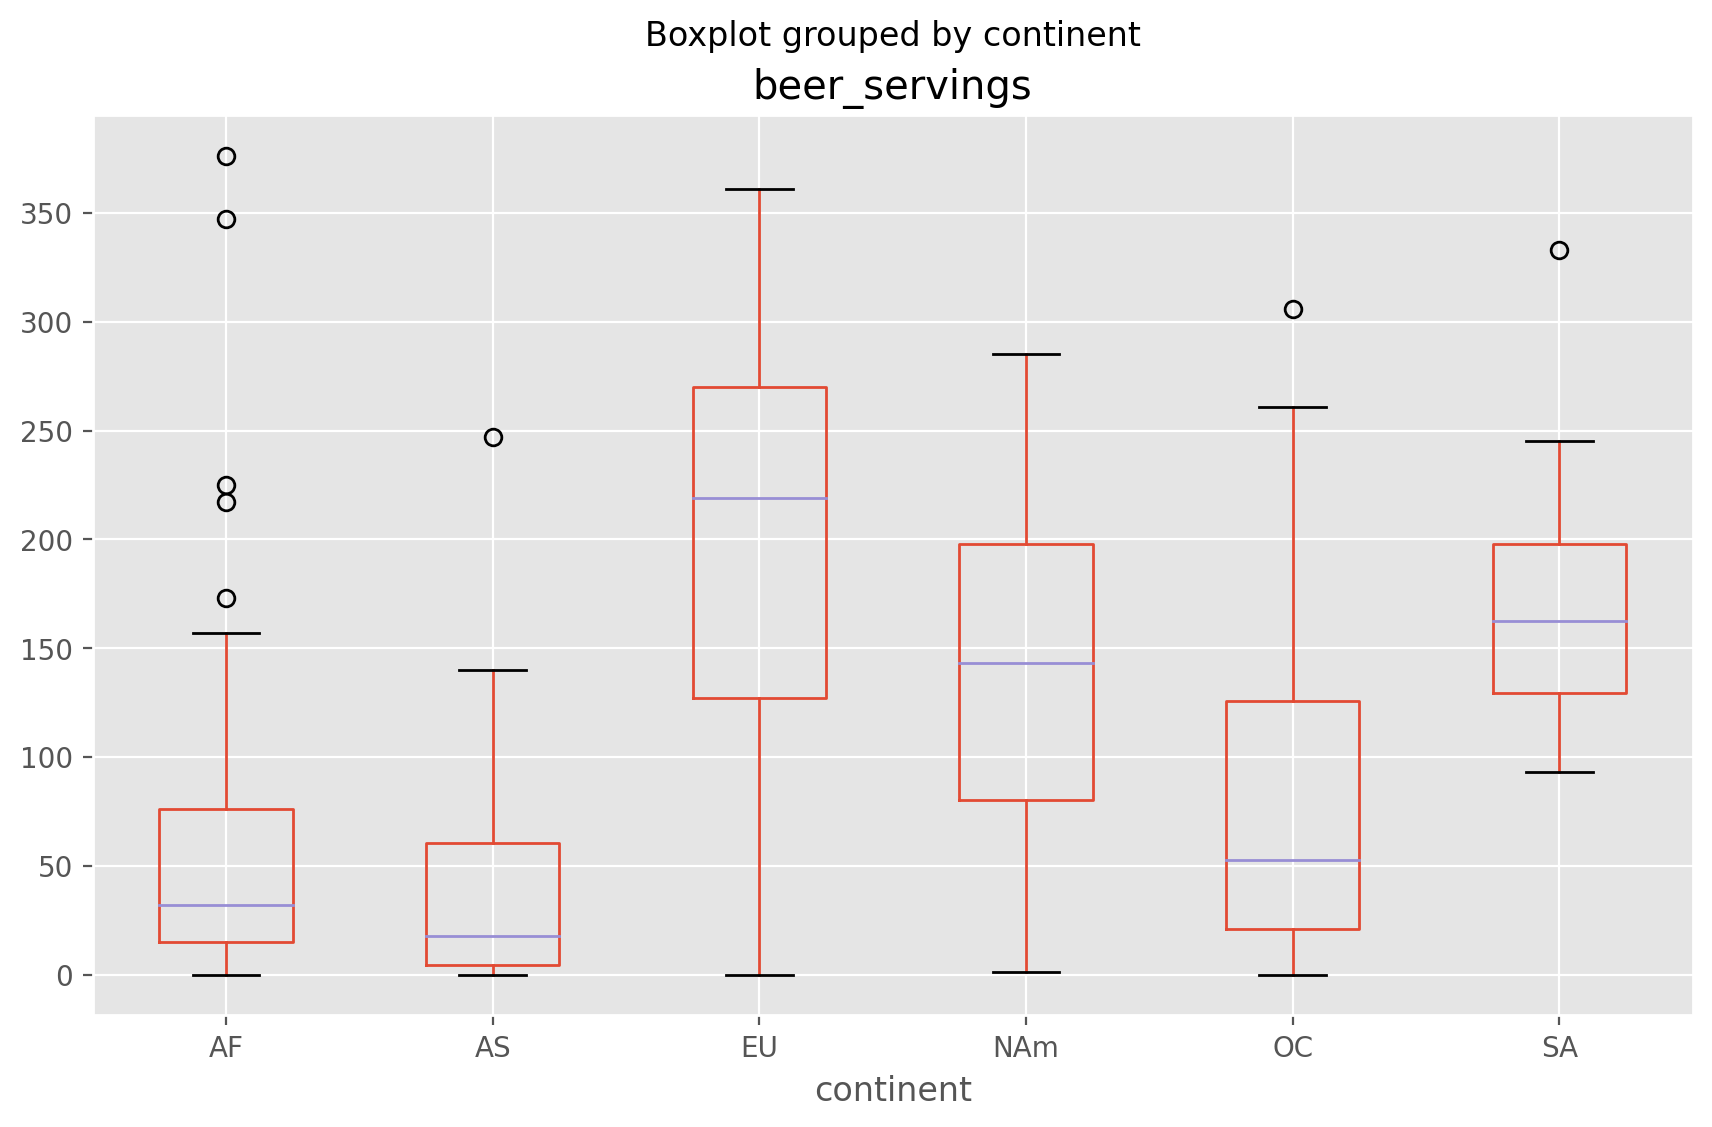

In [96]:
drinks.boxplot(column='beer_servings', by='continent');

In [97]:
muestra1 = drinks[drinks.continent=='EU']
muestra2 = drinks[drinks.continent=='AS']

In [98]:
print(sms.DescrStatsW(muestra1.beer_servings).mean)
print(muestra1.beer_servings.describe())

193.77777777777777
count     45.000000
mean     193.777778
std       99.631569
min        0.000000
25%      127.000000
50%      219.000000
75%      270.000000
max      361.000000
Name: beer_servings, dtype: float64


__¡Antes de utilizar las siguientes técnicas tendríamos que comprobar que se cumplen las hipótesis!__

In [99]:
sms.CompareMeans.from_data(
    muestra1.beer_servings, 
    muestra2.beer_servings).tconfint_diff(alpha=0.05, 
                                          usevar='unequal')

(123.53871260599851, 189.9259338586479)

In [100]:
muestra3 = drinks[drinks.continent=='AF']

sms.CompareMeans.from_data(
    muestra1.beer_servings, muestra3.beer_servings).tconfint_diff(alpha=0.05, usevar='pooled')

(96.17151909815581, 168.44064023098466)

### Intervalo de confianza para $\sigma ^2_1 / \sigma ^2_2 $
Sean $X \sim N(\mu_1,\sigma_1)$, $Y \sim N(\mu_2,\sigma_2)$ __INDEPENDIENTES__
        $$IC_{100\cdot(1-\alpha) \%}(\sigma ^2_1 / \sigma ^2_2)= \left[ F(m-1,n-1)_{\frac{\alpha}{2}} \cdot \dfrac{s_1^2}{s_2^2}, F(m-1,n-1)_{1- \frac{\alpha}{2}} \cdot \dfrac{s_1^2}{s_2^2}    \right]$$

__[Ejercicio]__ Crear una función que calcule el intervalo de confianza para el conciente de varianzas.

### Intervalo de confianza para $p_1-p_2$

Sean $X \sim \mathcal{B}e(p_1)$, $Y \sim \mathcal{B}e(p_2)$ (independientes)
        $$IC_{100\cdot(1-\alpha) \%}(p_1-p_2)= \left[(\overline{p_1}- \overline{p_2})\mp z_{1- \frac{\alpha }{2}} \cdot \sqrt{\dfrac{\overline{p_1} (1- \overline{p_1})}{n}+ \dfrac{\overline{p_2} (1- \overline{p_2})}{m}}  \right]$$

# Contrastes de hipótesis

Imagina que aplicas una nueva técnica para la gestión de tiempos en 
un departamento concreto de una empresa, y crees que con esta nueva técnica el
tiempo medio de atención al público disminuye
significativamente comparado con el tiempo promedio aceptado hasta ese
momento: 30 minutos. Entonces, tendremos dos hipótesis enfrentadas o **contraste de hipótesis**:

* __La hipótesis nula__ $H_0$: No hay diferencias en las técnicas empleadas.

* __La hipótesis alternativa__ $H_1$: Sí hay diferencias en las técnicas empleadas.

**teniendo que decidir si rechazar o no la hipótesis nula a partir de
una muestra de tiempos de atención al público.**

Como hemos comentado en la introducción, en los contrastes de hipótesis
paramétricos **vamos a asumir** un modelo estadístico para las
observaciones que dependerá de uno o varios parámetros. En este
seminario realizaremos contrastes para la media $\mu$, desviación típica
$\sigma$ y proporción $p$. Para cada contraste planteado existe un
*Estadístico de Contraste* (función de los valores muestrales), cuyo
valor nos ayudará a decidir si se rechaza o no $H_0$. En esta decisión,
juega un papel fundamental la distribución que tenga el Estadístico de
Contraste (EC) en el supuesto de que sea cierta la hipótesis $H_0$, de
forma que si obtenemos valores del EC poco probables, esto nos indicará
que debemos rechazar la hipótesis $H_0$.

Cuando nuestra decisión sea **rechazar la hipótesis $H_0$**, diremos que
**el contraste ha resultado significativo**, porque nuestra intención ha
sido poner $H_0$ en entredicho (a prueba), ya que sospechábamos que no
era cierta con la nueva técnica. Sin embargo, los posibles errores que
se cometen a la hora de decidir son:

<img src="https://raw.githubusercontent.com/AngelBerihuete/datasets/master/CuadroDecision.png">


**No sabemos en qué casilla estamos porque no sabemos qué pasa con la
población en estudio**.

-   El primer error (también llamado error tipo I) será concluir/decidir
    que existen diferencias en los tratamientos, cuando en realidad no
    los hay. La probabilidad de cometer ese error se llama **valor de
    significación** (**p-valor**). El investigador, antes de realizar el análisis,
    fija el **nivel de significación** ($\alpha$), probabilidad de error tipo I 
    que está dispuesto a asumir. Suelen
    utilizarse valores pequeños como 0.10, 0.05 ó 0.01. Se dice entonces
    que **fijamos** un nivel de significación del 10%, 5% ó 1%.

    Las técnicas que vamos a estudiar en este seminario nos dicen, a
    partir de nuestra muestra, cuál es la probabilidad de cometer el
    error tipo I (**p-valor**), y si esta probabilidad es muy baja,
    *decidiremos* que en la población también existen diferencias.

-   El segundo error (también llamado error tipo II) será
    concluir/decidir que no existen diferencias en los tratamientos,
    cuando en realidad sí los hay. La probabilidad de cometer este error
    se escribe con a letra $\beta$. Sin embargo, no suele utilizarse
    $\beta$, sino su complementario $1-\beta$, llamándose **potencia de
    un contraste**, es decir,
    $$\mbox{Potencia} = 1 - \beta = P(\mbox{Rechazar} \, H_0 | \mbox{Es
    cierta} \, H_1),$$ y significa la probabilidad de acertar al
    declarar el contraste significativo: __capacidad de nuestro estudio de
    detectar diferencias cuando existen en la población__.

    Es deseable que los contrastes que se utilicen sean lo más potentes
    posible, pero como veremos más adelante, cuantificar el error
    $\beta$ es difícil.


Los contrastes de hipótesis pueden dividirse en dos subgrupos:
**contrastes de hipótesis paramétricos** y **contrastes de hipótesis no
paramétricos**. Los primeros se basan en la suposición de que la
variable en estudio se distribuye según un modelo que depende de
parámetros, por ejemplo, si estamos interesados en estudiar el *el
tiempo de respuesta* a un cliente después de realizar una reclamación, 
y suponemos que dicho tiempo de respuesta se
distribuye según un modelo **Normal** de media $\mu$ y desviación típica
$\sigma$, se escribe $\mathcal{N}(\mu, \sigma)$; entonces el objetivo
será estudiar los parámetros **poblacionales** $\mu$ y $\sigma$ teniendo
en cuenta los datos obtenidos en la muestra.

Los **contrastes de hipótesis no paramétricos** no suponen, en general,
ningún modelo estadístico para la variable en estudio (algunas veces
suelen asumirse propiedades generales a la distribución tales como
simetría o continuidad). El principal inconveniente de las técnicas de
inferencia no paramétrica es que desperdician mucha información, y por
ello **deben usarse si no existe una alternativa paramétrica**.

__A tener en cuenta__:

-   Que los resultados no sean estadísticamente significativos no indica
    que la hipótesis nula sea cierta.
-   El nivel de significación $\alpha$ lo fija el investigador a priori.
-   Un resultado puede ser estadísticamente significativo y no
    __empresarialmente relevante__.


## Contrastes de hipótesis paramétricos

__Recordemos las propiedades__

En el caso de que la muestra aleatoria $X_1, X_2, \dots X_n$ provenga de una distribución $N(\mu, \sigma)$ y siendo


$$ \overline{X} = \frac{\sum_{i=1}^n X_i }{n} \quad S^2 = \frac{\sum_{i=1}^n (X_i - \mu)^2}{n-1}$$

entonces se verifica

$$Z=\frac{\overline{X}-\mu}{\sigma/\sqrt{n}} \sim N(0,1), \quad T=\frac{\overline{X}-\mu}{S/\sqrt{n}} \sim t(n-1),
\quad X^2 = \frac{(n-1) S^2}{\sigma^2} \sim \chi^2(n-1)$$

### Ejemplo

El departamento de atención al cliente de cierta empresa ha establecido, gracias a estudios previos, que el tiempo medio que emplean sus trabajadores en atender a sus clientes se distribuye según una normal de media 25 min. y una desviación típica de 5 min. $\mathcal{N}(25,5)$. Se han cambiado los protocolos para reducir dicho tiempo medio, y se ha tomado una muestra de tamaño 100 de tiempos de atención al cliente aplicando los nuevos protocolos, obteniendo una media muestral de 23.5 minutos.


$$
\begin{cases}
            H_0 :& \mu = 25 \\
            H_1 :& \mu < 25
\end{cases}$$


Sabemos que si $X \sim N(\mu, \sigma)$ entonces, $\overline{X} \sim N(\mu, \sigma/\sqrt{n})$

Por tanto, **si $H_0$ es cierta**, $\overline{X} \sim N(25,5/\sqrt{100})$ o lo que es lo mismo

$$ Z= \frac{\overline{X} - 25}{5 / \sqrt{100}} \sim N(0,1) $$

**Hemos observado** una media muestral de 23.5, por tanto, si $H_0$ es cierta, el valor

$$ z = \frac{23.5 - 25}{5 / \sqrt{100}} = -3$$

tendría que ser un valor probable en la distribución $N(0,1)$


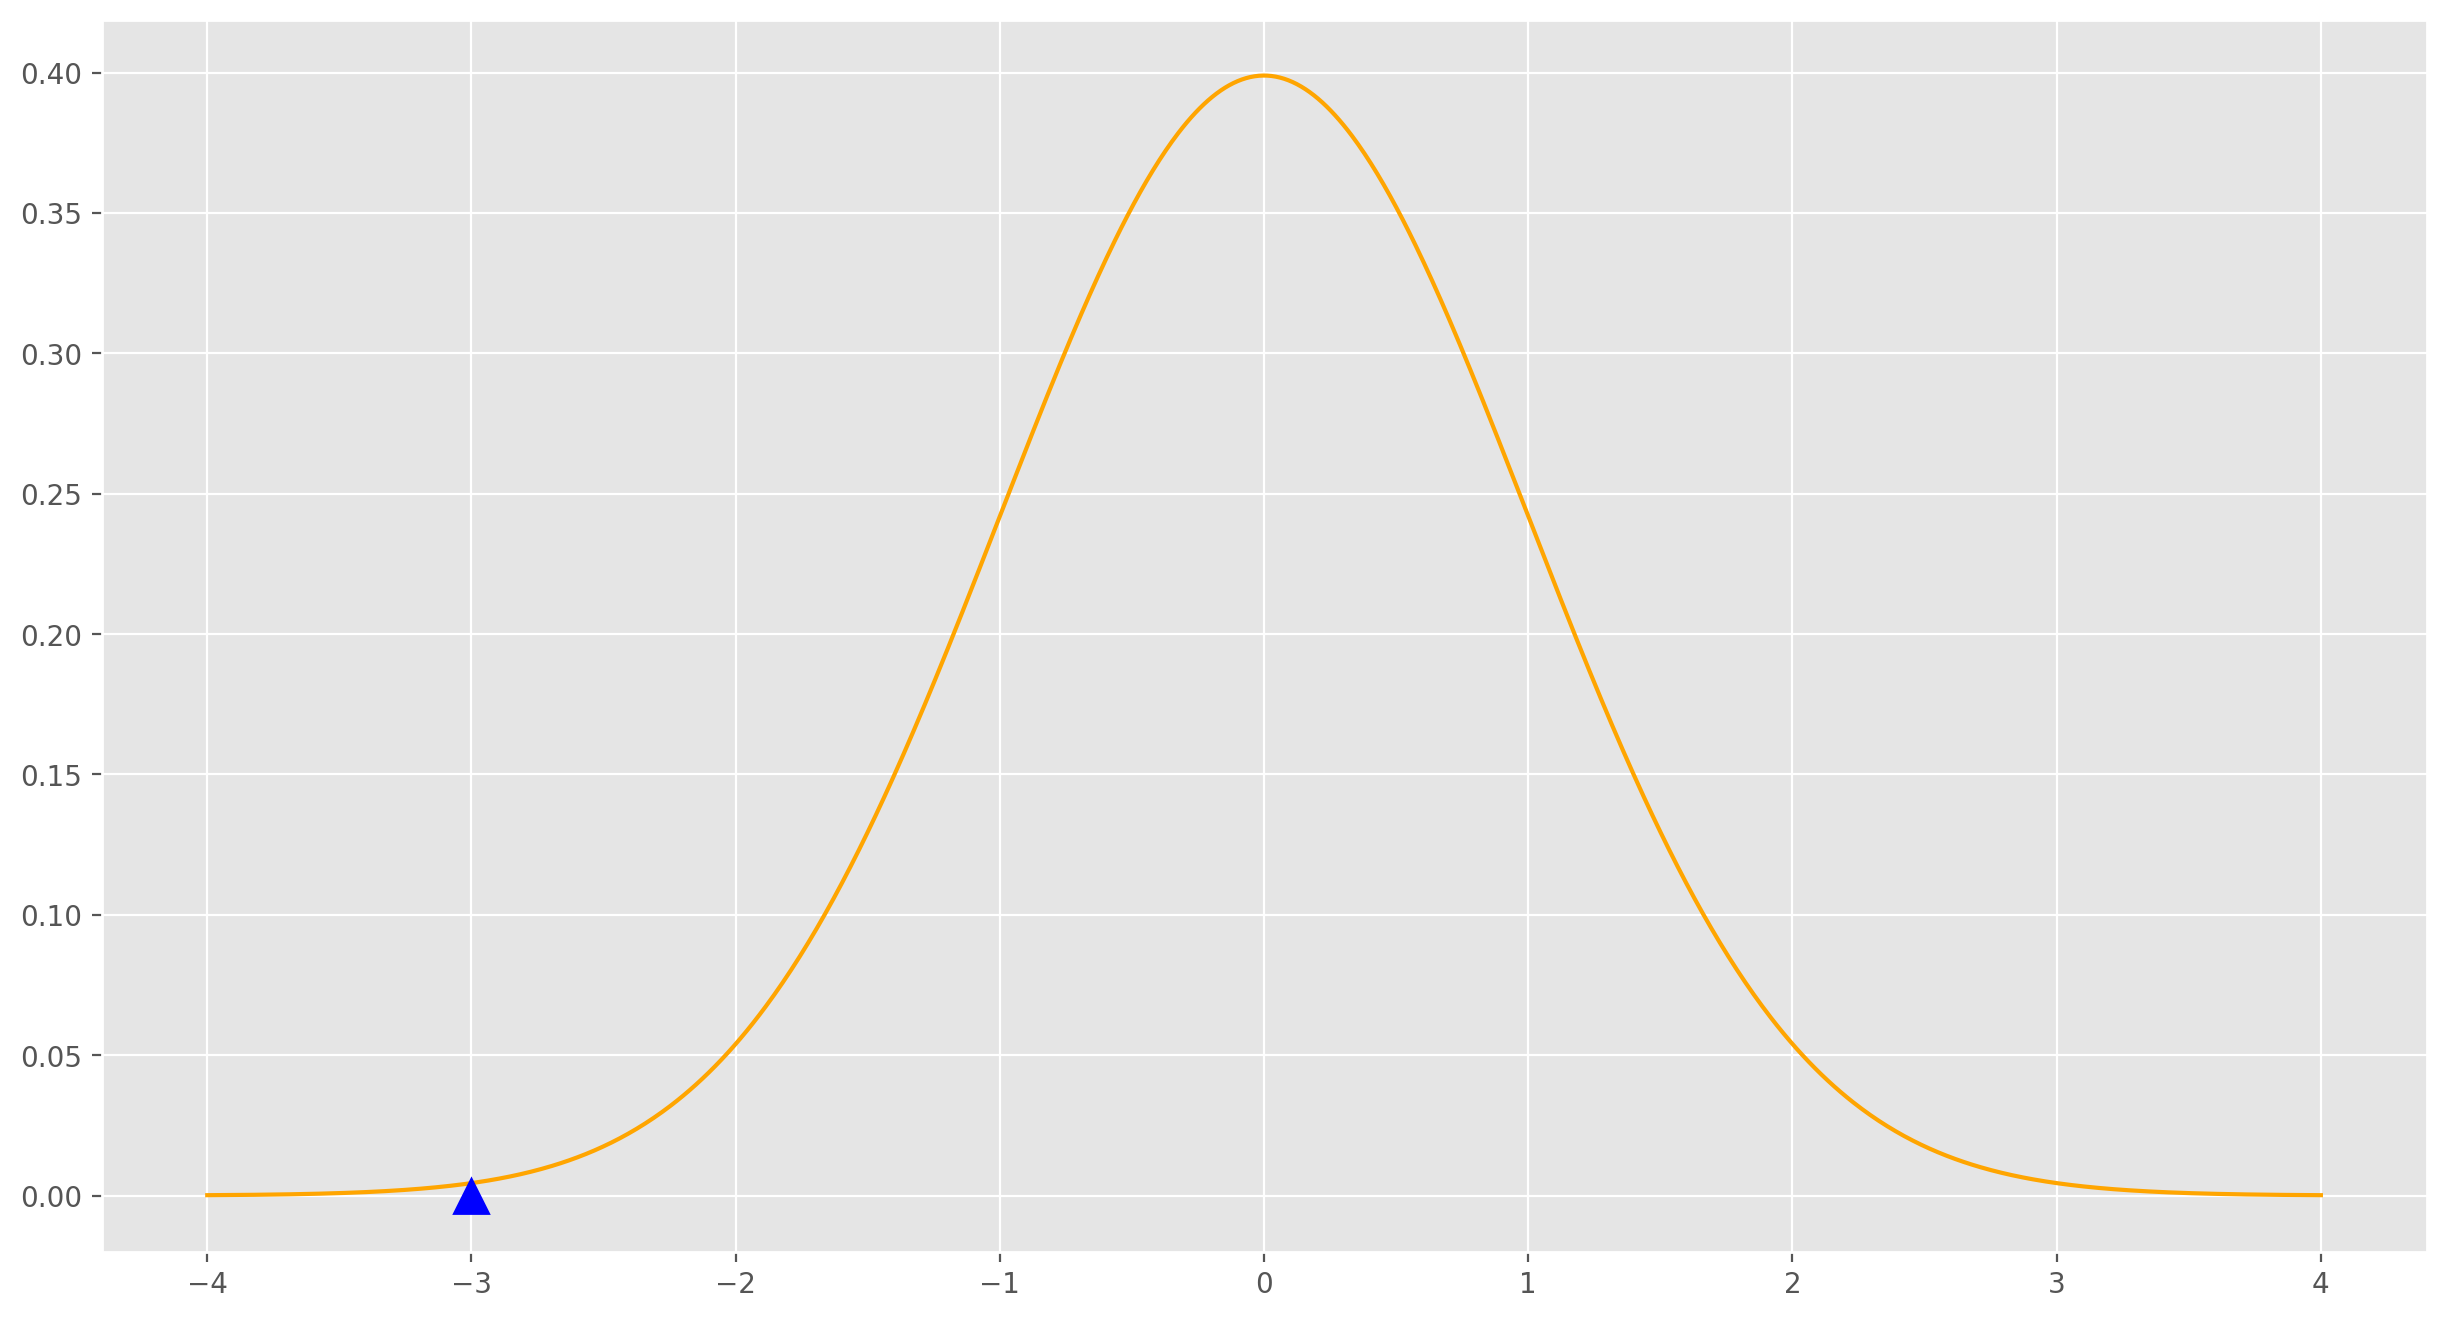

In [101]:
x = np.linspace(-4,4,1000)
y = st.norm(loc=0.,scale=1.).pdf(x)
fig, ax = plt.subplots(1,1,figsize=(15,8))
ax.plot(x,y,color='orange')
ax.plot(-3.,0, color='blue', marker='^', markersize=12);

Tenemos dos opciones:

1. Como todo lo anterior se ha hecho bajo el supuesto de que $H_0$ es cierto y el valor -3 es poco verosímil con el modelo, decidimos rechazar $H_0$. No obstante, como no es un valor imposible, podemos equivocarnos y cometer un error tipo I.

2. No rechazamos $H_0$ pensando que hemos tenido "mala suerte" con la muestra, y en ese caso podemos estar equivocándonos en un error de tipo II que no podemos evaluar directamente al no conocer cuál sería el verdadero valor de $\mu$.

Asumiendo el nivel de significación $\alpha = 0.05$ lo correcto sería **rechazar $H_0$** y pensar que $\mu < 25$, es decir, hay evidencia, con la muestra suministrada para pensar que el tiempo medio de atención al cliente ha bajado con los nuevos protocolos.



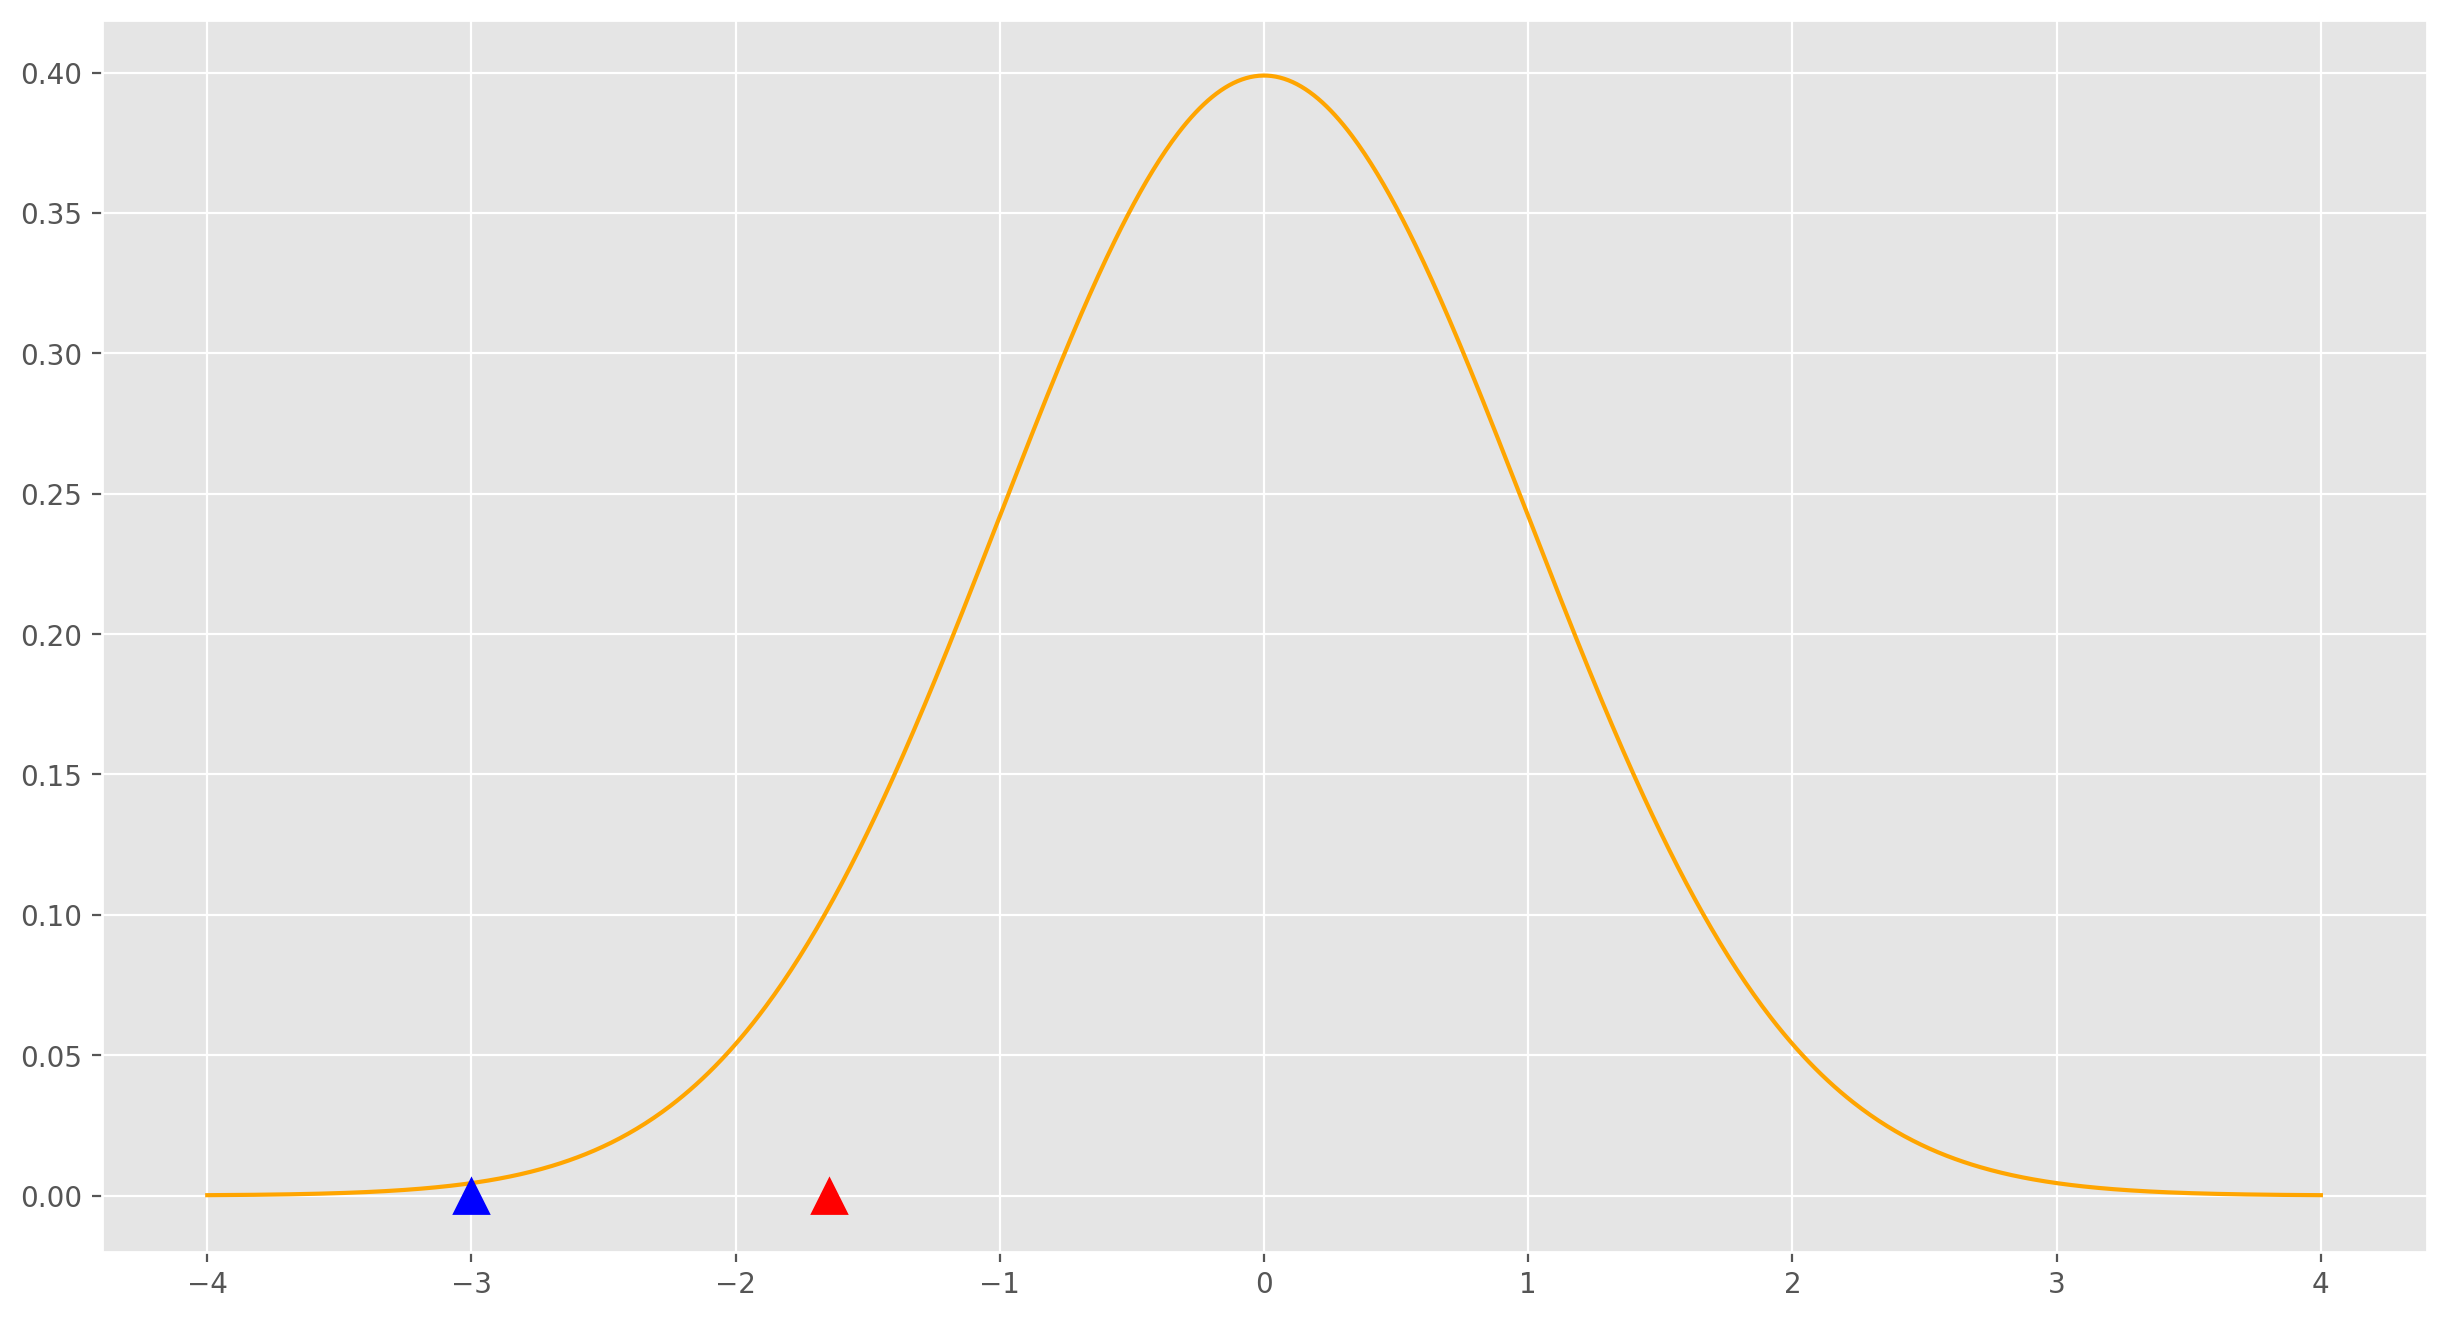

In [102]:
x = np.linspace(-4,4,1000)
y = st.norm(loc=0.,scale=1.).pdf(x)
fig, ax = plt.subplots(1,1,figsize=(15,8))
ax.plot(x,y,color='orange')
ax.plot(-3.,0, color='blue', marker='^', markersize=12);

alpha = 0.05
Z_alpha = st.norm(loc=0., scale=1.).ppf(alpha)

ax.plot(Z_alpha,0, color='red', marker='^', markersize=12);

¿Y utilizando una muestra de tamaño 100 de datos simulados a partir de una distribución $\mathcal{N}(24, 5)$?

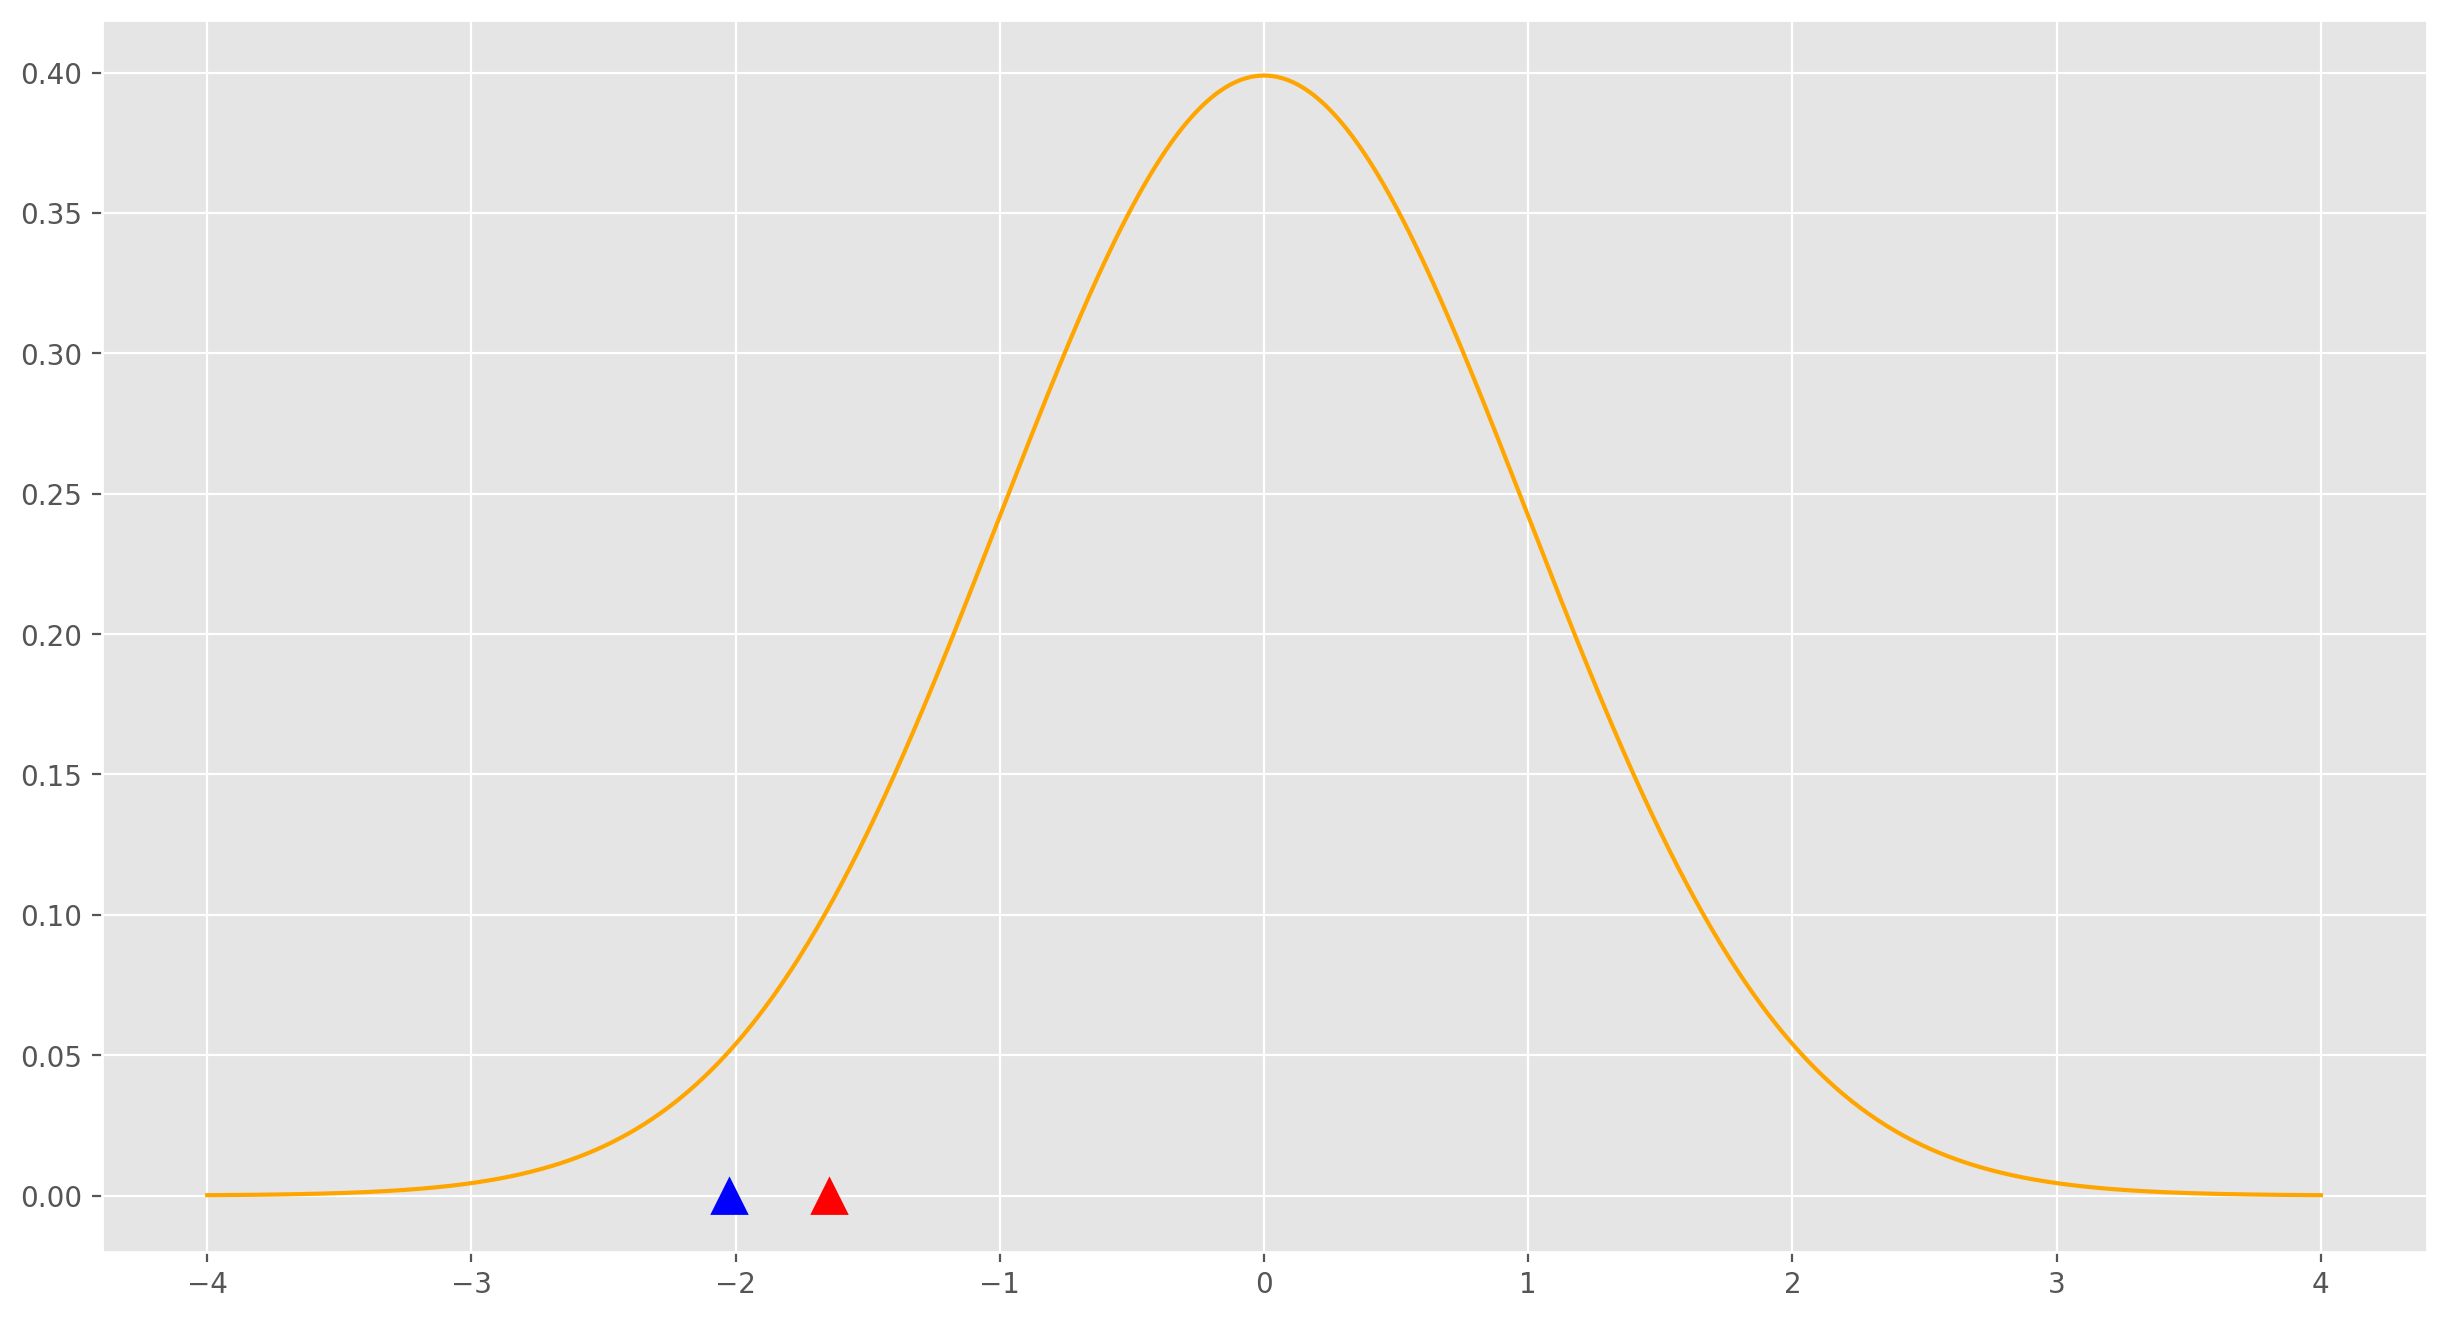

In [103]:
n = 100
X = st.norm(loc=24, scale=0.5)
sample = pd.DataFrame(X.rvs(size=n))

d = (sample.mean()-25.0)/(5.0/np.sqrt(sample.size)) # Estadístico de contraste

fig, ax = plt.subplots(1,1,figsize=(15,8))

ax.plot(x,y,color='orange');
ax.plot(d,0, color='blue', marker='^', markersize=12);
ax.plot(Z_alpha,0, color='red', marker='^', markersize=12);

__Ejercicio__ ¿Y si hubiéramos simulado datos a partir de una $\mathcal{N} (24.5, 5)$ ?

En lugar de mirar la región de rechazo vamos a mirar las probabilidades que acumulan dichos puntos. La primera la sabemos $\alpha = 0.05$, **nivel de significación**. La segunda es el **p-valor**.

$$\mbox{p-valor} = P(Z<d) = P \left( Z < \frac{\overline{x}-\mu}{\sigma/\sqrt{n}} \right)$$

In [104]:
st.norm(loc=0., scale=1.0).cdf(d)  # p-valor

array([0.02144988])

Si $\mbox{p-valor} < \alpha$ entonces **hay evidencia**, con la muestra suministrada, **para  rechar** $H_0$. Si $\mbox{p-valor} \geq \alpha$ entonces **no hay evidencia**, con la muestra suministrada **para rechazar** $H_0$.

**Hemos utilizado la medida $p-valor$, mínimo error $\alpha$ que tengo que aceptar para que el contraste sea significativo**. La siguiente tabla puede servir de ayuda a la decisión/conclusión de nuestros
contrastes:

  | Resultado | Decisión |
  |:-----------------|:-------------|
  |si $0.20<$ p-valor      |No significativo|
  |si $0.05<$ p-valor $<0.2$  |Dudoso|
  |si $0.01<$ p-valor $<0.05$ |Significativo|
  |si $0.001<$ p-valor $<0.01$|Muy significativo|
  |si p-valor $<0.001$ |Altamente significativo|

## Contrastes paramétricos en una población normal

**Suponemos** que la variable en estudio sigue una **distribución
normal**, es decir $X \sim \mathcal{N}(\mu,\sigma )$.

1.  Contrastes para el parámetro $\mu$

    -   Conocemos $\sigma ^2$. Debe utilizarse $d= \dfrac{(\overline{x}- \mu_0)\sqrt{n}}{\sigma}$
    
        $$\begin{array}{|c|c|c|}
        \hline
          H_0 & H_1 & \mbox{Región crítica}  \\
          \hline\hline
          \mu = \mu_0 & \mu = \mu_1> \mu_0 & d \geq z_{1- \alpha}  \\
          \hline
          \mu = \mu_0 & \mu = \mu_1< \mu_0 & d \leq z_{\alpha}  \\
          \hline
          \mu = \mu_0 & \mu \neq \mu_0 & \mbox{$d \geq z_{1- \alpha/2}$ ó $d\leq z_{\alpha/2}$} \\
          \hline
        \mbox{$\mu \leq \mu_0$} & \mu > \mu_0 & d \geq z_{1- \alpha} \\
          \hline
        \mbox{$\mu \geq \mu_0$} & \mu < \mu_0 & d \leq z_{\alpha} \\
          \hline
        \end{array}$$

    -   Desconocemos $\sigma ^2$. Debe utilizarse $d= \dfrac{(\overline{x}- \mu_0)\sqrt{n}}{s}$
        
        $$\begin{array}{|c|c|c|}
        \hline
          H_0 & H_1 & \mbox{Región crítica}  \\
          \hline\hline
          \mu = \mu_0 & \mu = \mu_1> \mu_0 & d \geq t_{n-1,1- \alpha}  \\
          \hline
          \mu = \mu_0 & \mu = \mu_1< \mu_0 & d \leq t_{n-1,\alpha}  \\
          \hline
          \mu = \mu_0 & \mu \neq \mu_0 & \mbox{$d \geq t_{n-1,1- \alpha/2}$ ó $d\leq t_{n-1,\alpha/2}$}  \\
          \hline
        \mbox{$\mu \leq \mu_0$}  & \mu > \mu_0 & d \geq t_{n-1,1- \alpha} \\
          \hline
        \mbox{$\mu \geq \mu_0$}  & \mu < \mu_0 & d \leq t_{n-1,\alpha} \\
          \hline
        \end{array}$$

2.  Contrastes para el parámetro $\sigma ^2$. Debe utilizarse $d=
    \dfrac{(n-1)s^2}{\sigma_0^2}$ $$\begin{array}{|c|c|c|}
    \hline
      H_0 & H_1 & \mbox{Región crítica}  \\
      \hline\hline
      \sigma^2 = \sigma_0^2 & \sigma^2 = \sigma_1^2> \sigma_0^2 & d \geq \chi_{n-1,1- \alpha}^2  \\
      \hline
      \sigma^2 = \sigma_0^2 & \sigma^2 = \sigma_1^2< \sigma_0^2 & d \leq \chi_{n-1,\alpha}^2  \\
      \hline
      \sigma^2 = \sigma_0^2 & \sigma^2 \neq \sigma_0^2 & \mbox{$d \geq \chi_{n-1,1- \alpha/2}^2$ ó $d\leq \chi_{n-1,\alpha/2}^2$}  \\
      \hline
    \mbox{$\sigma^2 \leq \sigma_0^2$}  & \sigma^2 > \sigma_0^2 & d \geq \chi_{n-1,1- \alpha}^2 \\
      \hline
    \mbox{$\sigma^2 \geq \sigma_0^2$}  & \sigma^2 < \sigma_0^2 & d \leq \chi_{n-1,\alpha}^2 \\
      \hline
    \end{array}$$



### Pasos necesarios para realizar un contraste de hipótesis 

---- 

__[Ejemplo]__ Después de varias campañas a nivel **Europeo** con las que se espera
se reduzca la ingesta de alcohol en los ciudadanos. Se han registrado el número de tercios de 
cerveza (```beer_servings```) en varios países de la UE. 

**Suponiendo que el número de tercios por año e individuo sigue una distribución
Normal**, ¿puede afirmarse que el número de tercios por año e individuo está por **debajo** de los 180?

__Paso 1. Planteamos el contraste__

Estamos ante un contraste unilateral 

$$
\begin{cases}
            H_0 :& \mu \geq 180 \\
            H_1 :& \mu < 180
\end{cases}$$

con una región crítica $RC = \{T_{exp} < t_{\alpha} (n-1) \}$

Usamos la notación $t_{\alpha} (n-1)$ ó $t_{n-1,\alpha}$ indistintamente.

**Ojo, he corregido el cuaderno porque figuraba $(1-\alpha)$**

__Paso 2. Calculamos el estadístico de contraste__

Puesto que la desviación típica ($\sigma$) no es conocida, tenemos

$$T_{exp} = \frac{\overline{x}- \mu_0}{s/\sqrt{n}} = 0.92765$$

En nuestro caso, $\mu_0 = 180$, $\overline{x}= 193.7777$, $s=99.6315$ con $n=45$.

__Paso 3. Decisión__

Fijamos el nivel de significación $\alpha = 0.05$. Si miramos en las tablas el **p-valor** en este caso es $P(t(45-1)<T_{exp})=0.820677$

En este caso $p-valor = 0.820677$ y como  $$p-valor = 0.820677 > 0.05 = \alpha$$

__Decidimos NO rechazar $H_0$, el contraste NO es significativo__.

__Paso 4. Conclusión__

Fijado $\alpha = 0.05$, no hay evidencia, con la muestra suministrada, para asegurar que la ingesta de alcohol está por debajo de los 180 tercios.

----

__Utilizando Python__, el contraste para la media poblacional (desconocemos $\sigma^2$):

$$
\begin{cases}
            H_0 :& \mu \geq 180 \\
            H_1 :& \mu < 180
\end{cases}$$

$$\begin{array}{|c|c|c|}
        \hline
          H_0 & H_1 & \mbox{Región crítica}  \\
          \hline\hline
          \mu = \mu_0 & \mu = \mu_1> \mu_0 & d \geq t_{n-1,1- \alpha}  \\
          \hline
          \mu = \mu_0 & \mu = \mu_1< \mu_0 & d \leq t_{n-1,\alpha}  \\
          \hline
          \mu = \mu_0 & \mu \neq \mu_0 & \mbox{$d \geq t_{n-1,1- \alpha/2}$ ó $d\leq t_{n-1,\alpha/2}$}  \\
          \hline
        \mbox{$\mu \leq \mu_0$}  & \mu > \mu_0 & d \geq t_{n-1,1- \alpha} \\
          \hline
        \mbox{$\mu \geq \mu_0$}  & \mu < \mu_0 & d \leq t_{n-1,\alpha} \\
          \hline
        \end{array}$$

In [105]:
drinks = pd.read_csv('https://raw.githubusercontent.com/luis-sarro/introstats/master/datasets/drinks.csv')
muestra1 = drinks[drinks.continent=='EU']

mu_0 = 180.0

sample_mean = muestra1.beer_servings.mean()
sample_std = muestra1.beer_servings.std()
n = muestra1.beer_servings.size

T=(sample_mean-mu_0)/(sample_std/np.sqrt(n))
p_value = st.t(n-1).cdf(T)

print("Estadísitico de contraste y p-valor:              T = %g  p-valor = %g" % (T, p_value))

Estadísitico de contraste y p-valor:              T = 0.927659  p-valor = 0.820677


Para el contraste 

$$
\begin{cases}
            H_0 :& \mu \leq 180 \\
            H_1 :& \mu > 180
\end{cases}$$



In [106]:
p_value = 1-st.t(n-1).cdf(T)

print("Estadístico de contraste y p-valor:              T = %g  p-valor = %g" % (T, p_value))

Estadístico de contraste y p-valor:              T = 0.927659  p-valor = 0.179323


En el caso de que tengamos un __contraste bilateral__, multiplicamos el p-valor por 2. Observad que estoy utilizando la función de supervivencia __(sf)__ que se define como 1-CDF(T).

$$\begin{cases}
            H_0 :& \mu = 180 \\
            H_1 :&  \mu \neq 180
\end{cases}$$


In [107]:
# Opción 1
p_value = 2.* (1 - st.t(n-1).cdf(T))

print("Estadísitico y p-valor:              T = %g  p-valor = %g" % (T, p_value))

# Opción 2
p_value = 2 * st.t(n-1).sf(T)
print(p_value)

Estadísitico y p-valor:              T = 0.927659  p-valor = 0.358645
0.35864535578528023


o con la biblioteca de scipy:

In [108]:
st.ttest_1samp(muestra1.beer_servings, 180.0)

Ttest_1sampResult(statistic=0.9276592169922304, pvalue=0.35864535578528034)

#### Contraste para la varianza poblacional

Contrastes para el parámetro $\sigma ^2$. Debe utilizarse $d=
    \dfrac{(n-1)s^2}{\sigma_0^2}$ $$\begin{array}{|c|c|c|}
    \hline
      H_0 & H_1 & \mbox{Región crítica}  \\
      \hline\hline
      \sigma^2 = \sigma_0^2 & \sigma^2 = \sigma_1^2> \sigma_0^2 & d \geq \chi_{n-1,1- \alpha}^2  \\
      \hline
      \sigma^2 = \sigma_0^2 & \sigma^2 = \sigma_1^2< \sigma_0^2 & d \leq \chi_{n-1,\alpha}^2  \\
      \hline
      \sigma^2 = \sigma_0^2 & \sigma^2 \neq \sigma_0^2 & \mbox{$d \geq \chi_{n-1,1- \alpha/2}^2$ ó $d\leq \chi_{n-1,\alpha/2}^2$}  \\
      \hline
    \mbox{$\sigma^2 \leq \sigma_0^2$}  & \sigma^2 > \sigma_0^2 & d \geq \chi_{n-1,1- \alpha}^2 \\
      \hline
    \mbox{$\sigma^2 \geq \sigma_0^2$}  & \sigma^2 < \sigma_0^2 & d \leq \chi_{n-1,\alpha}^2 \\
      \hline
    \end{array}$$



Para un contraste unilateral 

$$\begin{cases}
            H_0 :& \sigma^2 \geq 200 \\
            H_1 :& \sigma^2 < 200
\end{cases}$$

In [109]:
sigma_0 = 200.0

d = (n-1)*sample_std**2/(sigma_0)**2
st.chi2(n-1).cdf(d)

8.15937659690337e-08

Para un contraste unilateral 

$$\begin{cases}
            H_0 :& \sigma^2 \leq 200 \\
            H_1 :& \sigma^2 > 200
\end{cases}$$

In [110]:
st.chi2(n-1).sf(d) # survival function

0.999999918406234

Para un contraste bilateral

$$\begin{cases}
            H_0 :& \sigma^2 = 200 \\
            H_1 :& \sigma^2 \neq 200
\end{cases}$$

In [111]:
lower_quantile = st.chi2(n-1).ppf(alpha/2.0)
upper_quantile = st.chi2(n-1).ppf(1.0-alpha/2.0)
print("Región crítica y EC:              L = %g  U = %g Xi2 = %g " % (lower_quantile, upper_quantile,d))

Región crítica y EC:              L = 27.5746  U = 64.2015 Xi2 = 10.9191 


Ejercicio propuesto: Calculad el p-valor usando la distribución st.chi2

Ejercicio propuesto II: 

Imaginemos un experimento en el que tratamos de dilucidar si el rendimiento de dos clasificadores es o no igual. Para ello, disponemos de un conjunto de datos muy grande. 
1. Generad un conjunto de 50 tasas de acierto suponiendo que la fracción de aciertos verdadera del primer clasificador es $f_1$ y la del segundo, $f_2$. Elegid vosotros los valores de ambas proporciones. Se supone que los conjuntos de entrenamiento y test son el mismo para los dos clasificadores en cada uno de los 50 experimentos (pero diferentes de un experimento a otro) y que cada conjunto de test contiene 100 instancias. 
2. Realizad un test de hipótesis para la diferencia de las medias (¿es cero?) suponiendo que la distribución de las tasas de acierto es normal (haced una comprobación visual por ahora) y que las muestras son independientes (equivalente a suponer que los conjuntos de entrenamiento y test de los 50 experimentos tienen un grado de solape cero). 

